<a href="https://colab.research.google.com/github/dgizdevans/session-classification-enriched/blob/main/exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enriched Baselines for Prefix-Level Session Classification: Limits and Diagnostics

Experiment 2 evaluates whether enriching session prefix representations with
temporal intervals and global context improves early session classification
over the Experiment 1 baseline. Three model families are compared under a
unified evaluation protocol: higher-order Markov chains (Section 4), gradient
boosting with engineered features and SHAP analysis (Section 5), and SASRec
with temporal and contextual ablations (Section 6). Comparative diagnostics,
discussion, and limitations follow in Sections 7-9; artifact documentation in
Section 10.

**Dataset:** BigQuery public GA4 e-commerce sample - 360,129 sessions,
4,295,584 events. Sessions are labeled into 4 classes (Buyer, Intent,
Researcher, Browser) via a rule-based hierarchy defined in Section 1.3.

**Key result:** LightGBM achieved the best test Macro-F1 (0.5431), followed
by SASRec Base (0.4570) and Markov-3 (0.4221). Contextual and temporal
enrichment did not improve SASRec over the base variant. Buyer and Intent
remain the hardest classes across all models.

## 1. Data

Experiment 2 uses the same source dataset as Experiment 1: BigQuery's public GA4 e-commerce sample
(`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`), accessed via project `ga4sb-487512`.

Data is extracted with a single SQL query that flattens GA4's nested and repeated structures
(`event_params`, `device`, `geo`, `traffic_source`) into a flat tabular format,
selecting only the whitelisted fields required for this experiment.

All extracted fields are either identifiers (used only for session construction) or global
(session-level) attributes that remain constant throughout a session. For attributes that may
appear in multiple event rows, we take the first non-null value per field within the session
(fields may originate from different events within the session).

Extracted fields:
- **Keys and time:** `user_pseudo_id`, `ga_session_id`, `event_timestamp`, `event_bundle_sequence_id`
- **Event token:** `event_name` (raw, without additional cleaning, same as in Experiment 1)
- **Global context (session-level):** `platform`, `device_category`, `device_os`, `device_language`,
  `browser`, `continent`, `country`, `region`, `traffic_source`, `traffic_medium`, `traffic_campaign`

**Note:** Fields with high cardinality (`device_os`, `browser`, `continent`, `country`, `region`,
`traffic_campaign`) will require encoding at the feature engineering stage: either top-K encoding
(mapping rare values to a special `OTHER` token) or feature hashing. All transformations will be
fitted exclusively on the training set and applied to val/test without refitting.

By restricting to these session-stable attributes, we isolate the contribution of global context
and temporal intervals (derived from `event_timestamp`) while avoiding event-specific noise and
potential leakage from fields like `page_location` or `page_title`. This design ensures that any
performance gains observed in Experiment 2 can be attributed directly to the enriched feature set,
and the results will directly inform how to incorporate such features in more expressive model
architectures.

### 1.1 Data Extraction from BigQuery

We execute a single SQL query against the full available date range in the GA4 public sample dataset
(`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`) using project `ga4sb`.
No filter on `event_date` is applied; all available dates in the dataset are included.

This is an independent query from Experiment 1: it extracts a superset of fields, adding
global context and geo attributes that were not present in Experiment 1's input.

The query handles:
- Flattening of nested `event_params` to extract `ga_session_id` (key = `"ga_session_id"`)
- Flattening of `device` struct: `device_category`, `device_os`, `device_language`, `browser`
- Flattening of `traffic_source` struct: `traffic_source`, `traffic_medium`, `traffic_campaign`;
- Flattening of `geo` struct: `continent`, `country`, `region`
- Extraction of `platform` from the top-level row
- Filtering out rows where `user_pseudo_id`, `ga_session_id`, or `event_name` is NULL
- Sorting by `user_pseudo_id`, `ga_session_id`, `event_timestamp`, `event_bundle_sequence_id`

All whitelisted fields extracted:

| Field | Source | Role |
|---|---|---|
| `user_pseudo_id` | top-level | key |
| `ga_session_id` | event_params (`"ga_session_id"`) | key |
| `event_timestamp` | top-level | key / time |
| `event_bundle_sequence_id` | top-level | key |
| `event_name` | top-level | token |
| `platform` | top-level | context |
| `device_category` | device struct | context |
| `device_os` | device struct | context |
| `device_language` | device struct | context |
| `browser` | device struct | context |
| `continent` | geo struct | context |
| `country` | geo struct | context |
| `region` | geo struct | context |
| `traffic_source` | traffic_source struct | context |
| `traffic_medium` | traffic_source struct | context |
| `traffic_campaign` | traffic_source struct | context |

In [1]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 36.7 MB/s eta 0:00:00


In [2]:
# -- 1.1 Imports --
import optuna
import gc
import numpy as np
import pandas as pd
import math
import copy
from tqdm import tqdm
import time
import random
from datetime import datetime
import shutil
import pickle
import shap
import json
import os

from google.colab import auth, drive
from google.cloud import bigquery, storage

import matplotlib.pyplot as plt

import lightgbm as lgb

from collections import Counter, defaultdict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
# -- 1.1 Config --

PROJECT_ID = "ga4sb-487512"
DATASET = "bigquery-public-data.ga4_obfuscated_sample_ecommerce"
TABLE = f"{DATASET}.events_*"
GCS_BUCKET = "exp2data"

In [4]:
# -- 1.1 BigQuery client initialization --

# authenticate Colab session to access BigQuery
auth.authenticate_user()

client = bigquery.Client(project=PROJECT_ID)

In [5]:
# -- 1.1 SQL query --

query = f"""
SELECT
    user_pseudo_id,
    (SELECT MAX(value.int_value) FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS ga_session_id,
    event_timestamp,
    event_bundle_sequence_id,
    event_name,
    platform,
    device.category         AS device_category,
    device.operating_system AS device_os,
    device.language         AS device_language,
    device.web_info.browser AS browser,
    geo.continent           AS continent,
    geo.country             AS country,
    geo.region              AS region,
    traffic_source.source   AS traffic_source,
    traffic_source.medium   AS traffic_medium,
    traffic_source.name     AS traffic_campaign
FROM
    `{TABLE}`
WHERE
    user_pseudo_id IS NOT NULL
    AND (SELECT MAX(value.int_value) FROM UNNEST(event_params) WHERE key = 'ga_session_id') IS NOT NULL
    AND event_name IS NOT NULL
ORDER BY
    user_pseudo_id,
    (SELECT MAX(value.int_value) FROM UNNEST(event_params) WHERE key = 'ga_session_id'),
    event_timestamp,
    event_bundle_sequence_id
"""

prepared_data = client.query(query).to_dataframe()

print(f"Rows:    {prepared_data.shape[0]:,}")
print(f"Columns: {prepared_data.shape[1]}")
print(prepared_data.dtypes)
print(prepared_data.head())

Rows:    4,295,584
Columns: 16
user_pseudo_id              object
ga_session_id                Int64
event_timestamp              Int64
event_bundle_sequence_id     Int64
event_name                  object
platform                    object
device_category             object
device_os                   object
device_language             object
browser                     object
continent                   object
country                     object
region                      object
traffic_source              object
traffic_medium              object
traffic_campaign            object
dtype: object
          user_pseudo_id  ga_session_id   event_timestamp  \
0    10001363.4360935308     5983736405  1607746277508078   
1    10001363.4360935308     5983736405  1607746277508078   
2    10001363.4360935308     5983736405  1607746277508078   
3    10001363.4360935308     5983736405  1607746292809866   
4  1000223163.8035209215     6063162078  1610044534089387   

   event_bundle_sequence_id 

### 1.2 Session Construction

Each session is identified by a composite key combining `user_pseudo_id` and `ga_session_id`.
Within each session, events are assigned a sequential index based on a deterministic order
enforced during session construction by sorting on `event_timestamp`, `event_bundle_sequence_id`,
and `event_name`. The third tie-breaker (`event_name`) ensures a fully deterministic order
in cases where both timestamp and sequence ID are equal.

The following session-level attributes are derived:
- `session_id`: composite key `user_pseudo_id + "-" + ga_session_id`
- `user_pseudo_id`: retained at session level (first value within session)
- `event_index`: sequential position of each event within the session (1-based)
- `session_start_ts`: timestamp of the first event in the session
- `session_end_ts`: timestamp of the last event in the session
- `session_length`: total number of events in the session

In [6]:
# -- 1.2 Session ID and sort order --

prepared_data["session_id"] = (
    prepared_data["user_pseudo_id"] + "-" + prepared_data["ga_session_id"].astype(str)
)

prepared_data = prepared_data.sort_values(
    by=["session_id", "event_timestamp", "event_bundle_sequence_id", "event_name"],
    ascending=True
).reset_index(drop=True)

In [7]:
# -- 1.2 Event index and session-level attributes --

prepared_data["event_index"] = (
    prepared_data.groupby("session_id").cumcount() + 1
)

session_agg = prepared_data.groupby("session_id").agg(
    user_pseudo_id=("user_pseudo_id", "first"),
    session_start_ts=("event_timestamp", "min"),
    session_end_ts=("event_timestamp", "max"),
    session_length=("event_index", "max")
).reset_index()

prepared_data = prepared_data.merge(session_agg, on="session_id", how="left")

print(f"Sessions: {session_agg.shape[0]:,}")
print(f"Rows:     {prepared_data.shape[0]:,}")
print(prepared_data[["session_id", "event_index", "session_start_ts", "session_end_ts", "session_length"]].head())

Sessions: 360,129
Rows:     4,295,584
                         session_id  event_index  session_start_ts  \
0    10001363.4360935308-5983736405            1  1607746277508078   
1    10001363.4360935308-5983736405            2  1607746277508078   
2    10001363.4360935308-5983736405            3  1607746277508078   
3    10001363.4360935308-5983736405            4  1607746277508078   
4  1000223163.8035209215-6063162078            1  1610044534089387   

     session_end_ts  session_length  
0  1607746292809866               4  
1  1607746292809866               4  
2  1607746292809866               4  
3  1607746292809866               4  
4  1610044544561794               6  


**1.2 Result:**

Constructed **360,129 unique sessions** from 4,295,584 events.
Row count unchanged; merge introduced no duplicates or row loss.

Each event is assigned a deterministic `event_index` (1-based) within its session,
with ties broken by `event_bundle_sequence_id` and `event_name`.
Session-level attributes (`session_start_ts`, `session_end_ts`, `session_length`)
are derived per session from the constructed event sequence. Train-only constraints
(where applicable) are applied at the splitting and feature-engineering stages.

### 1.3 Session Labeling

Each session is assigned a single target label `y` based on the events present in the
**full session** (not the prefix). Labels are derived from the following hierarchy:

- **Buyer**: session contains at least one `purchase` event
- **Intent**: session contains at least one of `add_to_cart`, `begin_checkout`,
  `add_payment_info`, `add_shipping_info` (but no purchase)
- **Researcher**: session has no purchase and no intent events, but contains
  at least 3 product interactions from the allowlist:
  `view_item`, `view_item_list`, `select_item` (`product_interaction_count >= 3`)
- **Browser**: all remaining sessions

Labels are assigned exclusively from full session data and are never exposed as model input.
This ensures no leakage when training on prefixes.

In [8]:
# -- 1.3 Session labeling --

BUYER_EVENTS      = {"purchase"}
INTENT_EVENTS     = {"add_to_cart", "begin_checkout", "add_payment_info", "add_shipping_info"}
RESEARCHER_EVENTS = {"view_item", "view_item_list", "select_item"}
RESEARCHER_MIN    = 3

def assign_label(row) -> str:
    events = row["event_set"]
    if events & BUYER_EVENTS:
        return "Buyer"
    if events & INTENT_EVENTS:
        return "Intent"
    if row["product_interaction_count"] >= RESEARCHER_MIN:     # at this point: no purchase, no intent events
        return "Researcher"
    return "Browser"

session_events = (
    prepared_data
    .groupby("session_id")["event_name"]
    .apply(set)
    .reset_index()
    .rename(columns={"event_name": "event_set"})
)

product_counts = (
    prepared_data[prepared_data["event_name"].isin(RESEARCHER_EVENTS)]
    .groupby("session_id")["event_name"]
    .count()
    .reset_index()
    .rename(columns={"event_name": "product_interaction_count"})
)

session_events = session_events.merge(product_counts, on="session_id", how="left")
session_events["product_interaction_count"] = (
    session_events["product_interaction_count"].fillna(0).astype(int)
)

session_events["y"] = session_events.apply(assign_label, axis=1)

labels = session_events[["session_id", "y"]]

prepared_data = prepared_data.merge(labels, on="session_id", how="left")

In [9]:
# -- 1.3 Session-level label distribution --

print(labels["y"].value_counts())
print(labels["y"].value_counts(normalize=True).round(4))

y
Browser       319848
Researcher     19943
Intent         15490
Buyer           4848
Name: count, dtype: int64
y
Browser       0.8881
Researcher    0.0554
Intent        0.0430
Buyer         0.0135
Name: proportion, dtype: float64


**1.3 Result:**

Assigned labels to **360,129 sessions** using a strict priority hierarchy
(Buyer → Intent → Researcher → Browser).

| Label      | Sessions | Share  |
|------------|----------|--------|
| Browser    | 319,848  | 88.81% |
| Researcher |  19,943  |  5.54% |
| Intent     |  15,490  |  4.30% |
| Buyer      |   4,848  |  1.35% |

The dataset is severely imbalanced. Browser dominates at ~89%, while Buyer accounts
for only ~1.35% of sessions. This confirms the need for class-weighted loss functions
and macro-F1 as the primary evaluation metric, consistent with Experiment 1.

### 1.4 Temporal Split

Sessions are split into train, validation, and test sets using a temporal split based on
`session_end_ts`. This approach prevents data leakage by ensuring that all sessions in
validation and test sets occur strictly after all sessions in the training set.

Split proportions: **70% train / 15% validation / 15% test**, applied at the session level.
No session appears in more than one split.

Cutoff timestamps are computed from the distribution of `session_end_ts` across all
**360,129 sessions**, using the 70th and 85th percentiles as boundaries.
Split boundaries are defined as follows:

- **train:** `session_end_ts <= p70`
- **val:** `p70 < session_end_ts <= p85`
- **test:** `session_end_ts > p85`

Conditions are applied in strict hierarchical order to prevent any session from appearing
in more than one split.

In [10]:
# -- 1.4 Build sessions dataframe --

sessions = labels.merge(session_agg, on="session_id", how="left")

print(f"Sessions: {sessions.shape[0]:,}")
print(sessions.head())

Sessions: 360,129
                         session_id        y         user_pseudo_id  \
0    10001363.4360935308-5983736405  Browser    10001363.4360935308   
1  1000223163.8035209215-6063162078  Browser  1000223163.8035209215   
2     1000299.7413851356-3338398581  Browser     1000299.7413851356   
3     1000300.3223254235-3614622791  Browser     1000300.3223254235   
4     1000300.3223254235-9350310735  Browser     1000300.3223254235   

   session_start_ts    session_end_ts  session_length  
0  1607746277508078  1607746292809866               4  
1  1610044534089387  1610044544561794               6  
2  1611140699887247  1611140705779925               5  
3  1604497410570448  1604497410570448               2  
4  1604481671657014  1604481678760672               4  


In [11]:
# -- 1.4 Temporal split cutoffs --

p70 = sessions["session_end_ts"].quantile(0.70)
p85 = sessions["session_end_ts"].quantile(0.85)

p70 = int(round(p70))
p85 = int(round(p85))

assert p70 < p85, f"p70 ({p70}) must be less than p85 ({p85})"

print(f"p70 cutoff: {p70}")
print(f"p85 cutoff: {p85}")

p70 cutoff: 1609784310696110
p85 cutoff: 1610923126380055


In [12]:
# -- 1.4 Assign split labels --

def assign_split(ts):
    if ts <= p70:
        return "train"
    elif ts <= p85:
        return "val"
    else:
        return "test"

sessions["split"] = sessions["session_end_ts"].apply(assign_split)

print(sessions["split"].value_counts())
print(sessions["split"].value_counts(normalize=True).round(4))

split
train    252090
test      54020
val       54019
Name: count, dtype: int64
split
train    0.70
test     0.15
val      0.15
Name: proportion, dtype: float64


**1.4 Result:**

Sessions split into train / val / test using `session_end_ts` percentile boundaries
(p70 = 1609784310696110, p85 = 1610923126380055).

| Split | Sessions | Share |
|-------|----------|-------|
| train | 252,090  | 70.0% |
| val   |  54,019  | 15.0% |
| test  |  54,020  | 15.0% |

Split proportions match the target 70/15/15. No session appears in more than one split.

### 1.5 Prefix Construction

For each session, we define prefixes of length `t = 1 … session_length`.
Each prefix represents the first `t` events of the session and carries the
session's full-session label `y`. This simulates the early classification setting,
where the model must predict the final session outcome from partial observation.

Prefixes are not materialized — they are generated on the fly from the session-level
dataset during training and evaluation. Each prefix is defined by the following
attributes:
- `session_id` — session identifier
- `t` — prefix length (number of events observed so far)
- `y` — session label (derived from full session, not the prefix)
- `tokens[:t]` — first `t` event names from the session sequence
- `dt[:t]` — first `t` time deltas (in seconds); `dt[0] = 0`
- `split` — train / val / test assignment inherited from the session

Global context fields (`platform`, `device_category`, `device_os`, `device_language`,
`browser`, `continent`, `country`, `region`, `traffic_source`, `traffic_medium`,
`traffic_campaign`) are session-level attributes in the GA4 export that remain constant
throughout a session. They are attached per session as a single value, taken as the first
non-null value per field within the session (after sorting by `event_timestamp`,
`event_bundle_sequence_id`, `event_name`). Different fields may originate from different
events within the session. If all values for a field within a session are null,
the field is left as null.

All prefix datasets are constructed before any model-specific transformations.
Vocab and quantile boundaries are fitted exclusively on the training split in subsequent steps.

In [13]:
# -- 1.5 Extract session-level context (first non-null value per session) --

CONTEXT_FIELDS = [
    "platform", "device_category", "device_os", "device_language",
    "browser", "continent", "country", "region",
    "traffic_source", "traffic_medium", "traffic_campaign"
]

session_context = (
    prepared_data
    .sort_values(["session_id", "event_timestamp", "event_bundle_sequence_id", "event_name"])
    .groupby("session_id")[CONTEXT_FIELDS]
    .first()
    .reset_index()
)

print(f"Sessions with context: {session_context.shape[0]:,}")
print(session_context.head())

Sessions with context: 360,129
                         session_id platform device_category device_os  \
0    10001363.4360935308-5983736405      WEB         desktop       Web   
1  1000223163.8035209215-6063162078      WEB          mobile       Web   
2     1000299.7413851356-3338398581      WEB         desktop       Web   
3     1000300.3223254235-3614622791      WEB         desktop       Web   
4     1000300.3223254235-9350310735      WEB         desktop       Web   

  device_language browser continent    country                region  \
0           en-us  Chrome    Europe     Sweden      Stockholm County   
1           en-gb  Chrome   Oceania  Australia       New South Wales   
2           en-us  Chrome      Asia      India             Karnataka   
3              de  Chrome    Europe     France  Auvergne-Rhone-Alpes   
4           en-us  Chrome    Europe     France  Auvergne-Rhone-Alpes   

                    traffic_source traffic_medium traffic_campaign  
0                     

In [14]:
# -- 1.5 Build token sequences and time deltas per session --

def build_tokens_and_dt(group):
    tokens = group["event_name"].tolist()
    timestamps = group["event_timestamp"].tolist()
    dt = [0] + [
        (timestamps[i] - timestamps[i - 1]) / 1e6  # microseconds to seconds
        for i in range(1, len(timestamps))
    ]
    return pd.Series({"tokens": tokens, "dt": dt})

session_sequences = (
    prepared_data
    .sort_values(["session_id", "event_timestamp", "event_bundle_sequence_id", "event_name"])
    .groupby("session_id")[["event_name", "event_timestamp"]]
    .apply(build_tokens_and_dt, include_groups=False)
    .reset_index()
)

min_dt = session_sequences["dt"].apply(lambda x: min(x)).min()
assert min_dt >= 0, f"Negative dt detected: {min_dt}"

print(f"Sessions: {session_sequences.shape[0]:,}")
print(f"Min dt:   {min_dt:.2f} seconds")
print(session_sequences.head())

Sessions: 360,129
Min dt:   0.00 seconds
                         session_id  \
0    10001363.4360935308-5983736405   
1  1000223163.8035209215-6063162078   
2     1000299.7413851356-3338398581   
3     1000300.3223254235-3614622791   
4     1000300.3223254235-9350310735   

                                              tokens  \
0  [first_visit, page_view, session_start, user_e...   
1  [first_visit, page_view, session_start, page_v...   
2  [first_visit, page_view, session_start, page_v...   
3                   [session_start, user_engagement]   
4  [first_visit, page_view, session_start, view_p...   

                                       dt  
0                [0, 0.0, 0.0, 15.301788]  
1  [0, 0.0, 0.0, 5.004893, 0.0, 5.467514]  
2        [0, 0.0, 0.0, 5.11513, 0.777548]  
3                                [0, 0.0]  
4                 [0, 0.0, 0.0, 7.103658]  


In [15]:
# -- 1.5 Assemble session-level dataset --

sessions = (
    sessions
    .merge(session_sequences, on="session_id", how="left")
    .merge(session_context, on="session_id", how="left")
)

print(f"Sessions: {sessions.shape[0]:,}")
print(f"Columns:  {sessions.shape[1]}")
print(sessions.dtypes)
print(sessions.head())

Sessions: 360,129
Columns:  20
session_id          object
y                   object
user_pseudo_id      object
session_start_ts     Int64
session_end_ts       Int64
session_length       int64
split               object
tokens              object
dt                  object
platform            object
device_category     object
device_os           object
device_language     object
browser             object
continent           object
country             object
region              object
traffic_source      object
traffic_medium      object
traffic_campaign    object
dtype: object
                         session_id        y         user_pseudo_id  \
0    10001363.4360935308-5983736405  Browser    10001363.4360935308   
1  1000223163.8035209215-6063162078  Browser  1000223163.8035209215   
2     1000299.7413851356-3338398581  Browser     1000299.7413851356   
3     1000300.3223254235-3614622791  Browser     1000300.3223254235   
4     1000300.3223254235-9350310735  Browser     1000300.322

**1.5 Result:**

Assembled a session-level dataset of **360,129 sessions** × **20 columns**.
Each session stores the full event sequence (`tokens`) and time deltas (`dt`) as lists.
Prefixes will be generated on the fly during model training and evaluation.

All session-level attributes are present: label `y`, temporal split assignment,
full token and dt sequences, and global context fields (11 attributes).
No row loss detected across merges.

### 1.6 Vocabulary Construction

The event vocabulary is built exclusively from the **training set** to prevent leakage.
All events observed in validation or test sets that are absent from the training vocabulary
are mapped to `<UNK>`.

Vocabulary construction:
- Collect all unique `event_name` values across training sessions
- Add two reserved tokens: `<PAD>` (index 0) and `<UNK>` (index 1)
- No frequency-based truncation — all events seen in train are retained

This follows the same approach as Experiment 1 (no truncation; train-only + PAD/UNK).
The resulting vocab size is reported and saved as an artifact reused across all models
in Experiment 2.

In [16]:
# -- 1.6 Vocabulary construction --

train_sessions = sessions[sessions["split"] == "train"]

train_events = set(
    event
    for tokens in train_sessions["tokens"]
    for event in tokens
)

vocab = {"<PAD>": 0, "<UNK>": 1}
for i, event in enumerate(sorted(train_events), start=2):
    vocab[event] = i

print(f"Vocab size: {len(vocab)} (including <PAD> and <UNK>)")
print(f"Events in train: {len(train_events)}")

Vocab size: 19 (including <PAD> and <UNK>)
Events in train: 17


**1.6 Result:**

Vocabulary built from training sessions: **19 tokens** total
(17 unique event types + `<PAD>` at index 0 + `<UNK>` at index 1).

All events present in train are retained without truncation.
Unseen events in val/test will be mapped to `<UNK>` at inference time.

### 1.7 Save Artifacts

All artifacts produced in Section 1 are saved locally to avoid redundant recomputation
in subsequent sections and to ensure reproducibility.

Artifacts saved:
- `sessions.parquet` — session-level dataset (360,129 sessions × 20 columns, includes `split` column)
- `vocab.json` — event vocabulary (19 tokens, including `<PAD>` and `<UNK>`)
- `split_boundaries.json` — temporal split cutoffs (p70, p85) for reproducibility

In [17]:
# -- 1.7 Save artifacts to local and GCS --

OUTPUT_DIR = "/content/exp2_artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

# -- sessions --
sessions.to_parquet(f"{OUTPUT_DIR}/sessions.parquet", index=False)
_bucket.blob(f"sessions_{_ts}.parquet").upload_from_filename(
    f"{OUTPUT_DIR}/sessions.parquet")

# -- vocabulary --
with open(f"{OUTPUT_DIR}/vocab.json", "w") as f:
    json.dump(vocab, f, indent=2)
_bucket.blob(f"vocab_{_ts}.json").upload_from_filename(
    f"{OUTPUT_DIR}/vocab.json")

# -- split boundaries --
split_boundaries = {"p70": p70, "p85": p85}
with open(f"{OUTPUT_DIR}/split_boundaries.json", "w") as f:
    json.dump(split_boundaries, f, indent=2)
_bucket.blob(f"split_boundaries_{_ts}.json").upload_from_filename(
    f"{OUTPUT_DIR}/split_boundaries.json")

print(f"Saved to {OUTPUT_DIR}/ and gs://{GCS_BUCKET}/:")
print(f"  sessions.parquet       — {sessions.shape[0]:,} rows x {sessions.shape[1]} cols")
print(f"  vocab.json             — {len(vocab)} tokens")
print(f"  split_boundaries.json  — p70={p70}, p85={p85}")

del _ts, _gcs_client, _bucket

Saved to /content/exp2_artifacts/ and gs://exp2data/:
  sessions.parquet       — 360,129 rows x 20 cols
  vocab.json             — 19 tokens
  split_boundaries.json  — p70=1609784310696110, p85=1610923126380055


**1.7 Result:**

All Section 1 artifacts saved to `/content/exp2_artifacts`:

| Artifact | Description |
|---|---|
| `sessions.parquet` | 360,129 sessions × 20 columns, includes `split` column |
| `vocab.json` | 19 tokens (`<PAD>`, `<UNK>`, 17 event types) |
| `split_boundaries.json` | p70=1609784310696110, p85=1610923126380055 |

### Section 1 Summary

Section 1 established the complete data pipeline for Experiment 2, from raw BigQuery
extraction to saved artifacts ready for modeling.

**Data extraction:** 4,295,584 events pulled from
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` using a single flattening
SQL query. 16 fields extracted: identifiers, event token, and 11 global context attributes
(platform + device + geo + traffic). Row count matches Experiment 1 under identical
filtering criteria.

**Session construction:** 360,129 unique sessions formed via composite key
`user_pseudo_id + ga_session_id`. Events ordered deterministically by
`event_timestamp`, `event_bundle_sequence_id`, `event_name`.

**Session labeling:** Labels assigned using a strict priority hierarchy
(Buyer → Intent → Researcher → Browser) based on full session event sets.
Researcher requires ≥3 product interactions from allowlist (`view_item`, `view_item_list`, `select_item`).

| Label      | Sessions | Share  |
|------------|----------|--------|
| Browser    | 319,848  | 88.81% |
| Researcher |  19,943  |  5.54% |
| Intent     |  15,490  |  4.30% |
| Buyer      |   4,848  |  1.35% |

**Temporal split (70/15/15):** Sessions split by `session_end_ts` percentile boundaries
(p70=1609784310696110, p85=1610923126380055). Train: 252,090 / Val: 54,019 / Test: 54,020.

**Prefix strategy:** Full token sequences and time deltas stored per session.
Prefixes generated on the fly during training and evaluation to avoid memory overhead.

**Vocabulary:** 19 tokens (17 unique event types + `<PAD>` + `<UNK>`), built exclusively
on the training set.

**Artifacts saved:** `sessions.parquet`, `vocab.json`, `split_boundaries.json`.

In [18]:
# --- Intermediate cleanup: free raw/prepared session tables after artifacts are saved ---
# These objects are no longer needed for Section 5, keeping them may cause Colab OOM.
to_del = [
    "prepared_data",
    "session_agg",
    "session_events",
    "product_counts",
    "labels",
    "session_context",
    "session_sequences",
]
for name in to_del:
    if name in globals():
        del globals()[name]
gc.collect()

160

## 2. Exploratory Data Analysis

Before proceeding to model development, we conduct a structured EDA over the session-level
dataset produced in Section 1. The goal is not descriptive statistics for their own sake,
but targeted diagnostics that directly inform decisions made in Blocks A, B, and C.

Specifically, we examine:

- **Split integrity:** verify that the temporal split is leak-free and quantify user overlap
  across splits, replicating the sanity check from Experiment 1.
- **Class distribution:** confirm severe imbalance across splits, motivating class-weighted
  training and macro-F1 as the primary metric.
- **Session length distribution:** establish `Tmax` for prefix construction and characterize
  structural differences between classes, which explain why early classification is hard.
- **Event vocabulary:** verify UNK coverage across splits and examine token frequency skew,
  which informs sparsity considerations for Markov-n models.
- **Temporal intervals (Δt):** analyze inter-event timing distributions per class, which
  directly informs discrete time encoding design for SASRec+.
- **Global context features:** assess cardinality, missing rates, and distributions across
  11 context attributes extracted (platform + device + geo + traffic); `platform` is
  constant across all sessions and will be dropped before modeling.
- **Key event positions:** quantify how late purchase-related events appear in sessions,
  providing empirical grounding for the early classification challenge identified in Experiment 1.

### 2.0 Split Sanity Check

Before EDA, we verify two properties of the temporal split:

1. **Temporal integrity:** no leakage between splits, i.e., the latest session end timestamp in train is strictly earlier than the earliest in val and test.
2. **User overlap:** users can appear in multiple splits (sessions are the split unit, not users). We report the overlap as-is, without filtering.

In [19]:
# -- 2.0 Split Sanity Check --

# -- Load sessions --
sessions = pd.read_parquet("/content/exp2_artifacts/sessions.parquet")

with open("/content/exp2_artifacts/split_boundaries.json") as f:
    split_boundaries = json.load(f)

# -- Temporal integrity --
max_train_ts = sessions.loc[sessions["split"] == "train", "session_end_ts"].max()
min_val_ts   = sessions.loc[sessions["split"] == "val",   "session_end_ts"].min()
min_test_ts  = sessions.loc[sessions["split"] == "test",  "session_end_ts"].min()

print("Temporal integrity:")
print(f"  max train session_end_ts : {max_train_ts}")
print(f"  min val  session_end_ts  : {min_val_ts}")
print(f"  min test session_end_ts  : {min_test_ts}")
print(f"  train < val  : {max_train_ts < min_val_ts}")
print(f"  train < test : {max_train_ts < min_test_ts}")

# -- User overlap --
users_train = set(sessions.loc[sessions["split"] == "train", "user_pseudo_id"])
users_val   = set(sessions.loc[sessions["split"] == "val",   "user_pseudo_id"])
users_test  = set(sessions.loc[sessions["split"] == "test",  "user_pseudo_id"])

val_in_train  = len(users_val  & users_train) / len(users_val)  * 100
test_in_train = len(users_test & users_train) / len(users_test) * 100

users_per_split = sessions.groupby("user_pseudo_id")["split"].nunique()
users_multi     = (users_per_split > 1).sum() / len(users_per_split) * 100

print("\nUser overlap:")
print(f"  % val  users also in train : {val_in_train:.1f}%")
print(f"  % test users also in train : {test_in_train:.1f}%")
print(f"  % users in more than 1 split : {users_multi:.1f}%")

Temporal integrity:
  max train session_end_ts : 1609784307313730
  min val  session_end_ts  : 1609784312951030
  min test session_end_ts  : 1610923126473697
  train < val  : True
  train < test : True

User overlap:
  % val  users also in train : 5.9%
  % test users also in train : 3.5%
  % users in more than 1 split : 1.9%


**Result:**

Temporal split is leak-free: max train `session_end_ts` (1609784307313730) is strictly less
than min val (1609784312951030) and min test (1610923126473697).

User overlap is low: 5.9% of val users and 3.5% of test users also appear in train;
1.9% of all users span more than one split. This is expected given that sessions,
not users, are the split unit.

### 2.1 Class Distribution

We report the distribution of session classes overall and by split to confirm
that the temporal split preserves relative class proportions.

In [20]:
# -- 2.1 Class distribution overall and by split --

class_order = ["Buyer", "Intent", "Researcher", "Browser"]

# -- Overall --
overall = (
    sessions["y"]
    .value_counts()
    .reindex(class_order)
)
overall_pct = overall / overall.sum() * 100

print("Overall class distribution:")
for cls in class_order:
    print(f"  {cls:<12} {overall[cls]:>7,}  ({overall_pct[cls]:.2f}%)")
print(f"  {'Total':<12} {overall.sum():>7,}")

# -- By split --
print("\nClass distribution by split:")
by_split = (
    sessions.groupby(["split", "y"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=class_order)
)
by_split_pct = by_split.div(by_split.sum(axis=1), axis=0) * 100

for split in ["train", "val", "test"]:
    total = by_split.loc[split].sum()
    print(f"\n  {split} (n={total:,}):")
    for cls in class_order:
        n   = by_split.loc[split, cls]
        pct = by_split_pct.loc[split, cls]
        print(f"    {cls:<12} {n:>7,}  ({pct:.2f}%)")

Overall class distribution:
  Buyer          4,848  (1.35%)
  Intent        15,490  (4.30%)
  Researcher    19,943  (5.54%)
  Browser      319,848  (88.81%)
  Total        360,129

Class distribution by split:

  train (n=252,090):
    Buyer          3,786  (1.50%)
    Intent        11,698  (4.64%)
    Researcher    14,560  (5.78%)
    Browser      222,046  (88.08%)

  val (n=54,019):
    Buyer            375  (0.69%)
    Intent         1,815  (3.36%)
    Researcher     2,407  (4.46%)
    Browser       49,422  (91.49%)

  test (n=54,020):
    Buyer            687  (1.27%)
    Intent         1,977  (3.66%)
    Researcher     2,976  (5.51%)
    Browser       48,380  (89.56%)


**2.1 Result:**

The dataset contains 360,129 sessions with a severe class imbalance: Browser dominates
at 88.81%, while Buyer represents only 1.35% of all sessions.

Class proportions are broadly consistent across splits, with one notable pattern:
val has a lower Buyer share (0.69%) compared to train (1.50%) and test (1.27%),
reflecting the temporal nature of the split rather than random sampling.

| Class      | Train         | Val          | Test         | Overall      |
|------------|---------------|--------------|--------------|--------------|
| Buyer      | 3,786 (1.50%) | 375 (0.69%)  | 687 (1.27%)  | 4,848 (1.35%)|
| Intent     | 11,698 (4.64%)| 1,815 (3.36%)| 1,977 (3.66%)| 15,490 (4.30%)|
| Researcher | 14,560 (5.78%)| 2,407 (4.46%)| 2,976 (5.51%)| 19,943 (5.54%)|
| Browser    | 222,046 (88.08%)| 49,422 (91.49%)| 48,380 (89.56%)| 319,848 (88.81%)|

### 2.2 Session Length Distribution

We examine the distribution of session lengths (number of events per session)
overall, by split, and by class. This informs the choice of `Tmax` for prefix
construction and highlights structural differences between classes.

In [21]:
# -- 2.2 Session length distribution by split and by class --

# -- Overall percentiles --
lengths = sessions["session_length"]
percentiles = [50, 75, 90, 95, 99]

print("Overall session length:")
print(f"  min={lengths.min()}, max={lengths.max()}, mean={lengths.mean():.1f}, median={lengths.median():.0f}")
print(f"  percentiles: { {p: int(np.percentile(lengths, p)) for p in percentiles} }")

# -- By split --
print("\nSession length by split (mean / median / p95 / max):")
for split in ["train", "val", "test"]:
    s = sessions.loc[sessions["split"] == split, "session_length"]
    print(f"  {split:<6}  mean={s.mean():.1f}  median={s.median():.0f}  p95={int(np.percentile(s, 95))}  max={s.max()}")

# -- By class --
print("\nSession length by class (mean / median / p95 / max):")
for cls in ["Buyer", "Intent", "Researcher", "Browser"]:
    s = sessions.loc[sessions["y"] == cls, "session_length"]
    print(f"  {cls:<12}  mean={s.mean():.1f}  median={s.median():.0f}  p95={int(np.percentile(s, 95))}  max={s.max()}")

Overall session length:
  min=1, max=1007, mean=11.9, median=5
  percentiles: {50: 5, 75: 9, 90: 22, 95: 39, 99: 125}

Session length by split (mean / median / p95 / max):
  train   mean=12.6  median=5  p95=43  max=1007
  val     mean=9.7  median=6  p95=30  max=453
  test    mean=10.9  median=6  p95=36  max=739

Session length by class (mean / median / p95 / max):
  Buyer         mean=107.3  median=84  p95=256  max=942
  Intent        mean=65.0  median=36  p95=290  max=1007
  Researcher    mean=33.2  median=26  p95=81  max=739
  Browser       mean=6.6  median=5  p95=17  max=401


**2.2 Result:**

Session lengths are heavily right-skewed: median is 5 events, mean 11.9, but p99 reaches 125
and the maximum is 1,007. All splits share the same right-skewed shape, but val is shorter
on average (mean 9.7, p95 30 vs. mean 12.6, p95 43 in train).

Class differences are substantial and diagnostically important:

| Class      | Mean  | Median | p95 | Max   |
|------------|-------|--------|-----|-------|
| Buyer      | 107.3 | 84     | 256 | 942   |
| Intent     | 65.0  | 36     | 290 | 1,007 |
| Researcher | 33.2  | 26     | 81  | 739   |
| Browser    | 6.6   | 5      | 17  | 401   |

Buyer and Intent sessions are dramatically longer than Browser sessions (median 84 and 36
vs. 5), which reflects that purchase-related activity requires more interactions.
This also means that at early prefixes (t < 10), the majority of Buyer and Intent sessions
are still in progress, making early classification inherently difficult.

`Tmax` for prefix construction will be set based on p95 of the train split (43 events),
capping the long tail while retaining 95% of sessions at full length.

### 2.3 Event Vocabulary Analysis

We report token frequencies in the training set and verify UNK coverage across splits.
Since the vocabulary is built from all unique event types observed in train, UNK rate
in val and test is expected to be near zero.

In [22]:
# -- 2.3 Event vocabulary analysis --

with open("/content/exp2_artifacts/vocab.json") as f:
    vocab = json.load(f)

# -- Token frequencies on train --
train_events = sessions.loc[sessions["split"] == "train", "tokens"].explode()
token_counts = train_events.value_counts()

print(f"Vocabulary size: {len(vocab)} tokens (incl. <PAD>, <UNK>)")
print(f"\nToken frequencies in train:")
for token, count in token_counts.items():
    pct = count / len(train_events) * 100
    print(f"  {token:<35} {count:>9,}  ({pct:.2f}%)")

# -- UNK coverage by split --
print("\nUNK coverage by split:")
known_tokens = set(vocab.keys()) - {"<PAD>", "<UNK>"}
for split in ["train", "val", "test"]:
    events = sessions.loc[sessions["split"] == split, "tokens"].explode()
    unk_count = (~events.isin(known_tokens)).sum()
    unk_pct = unk_count / len(events) * 100
    print(f"  {split:<6}  total events={len(events):>10,}  UNK={unk_count:>6,}  ({unk_pct:.4f}%)")

Vocabulary size: 19 tokens (incl. <PAD>, <UNK>)

Token frequencies in train:
  page_view                             964,809  (30.35%)
  user_engagement                       827,611  (26.03%)
  scroll                                363,501  (11.43%)
  view_item                             305,104  (9.60%)
  session_start                         248,649  (7.82%)
  first_visit                           177,021  (5.57%)
  view_promotion                        139,849  (4.40%)
  add_to_cart                            44,162  (1.39%)
  begin_checkout                         28,329  (0.89%)
  select_item                            21,481  (0.68%)
  view_search_results                    18,980  (0.60%)
  add_shipping_info                      15,974  (0.50%)
  add_payment_info                       11,197  (0.35%)
  select_promotion                        6,751  (0.21%)
  purchase                                4,543  (0.14%)
  click                                   1,254  (0.04%)
  view_i

**2.3 Result:**

The vocabulary contains 19 tokens: 17 event types plus `<PAD>` and `<UNK>`.
UNK rate is exactly 0% across all splits, confirming that all event types in val and test
are covered by the train vocabulary.

Token distribution in train is highly skewed: three events (`page_view`, `user_engagement`,
`scroll`) account for 67.8% of train events,, while purchase-related events are rare
(`purchase` 0.14%, `add_to_cart` 1.39%). This mirrors the class imbalance and reinforces
that key intent signals are sparse in the event stream.

| Token                  | Count     | % of train |
|------------------------|-----------|------------|
| page_view              | 964,809   | 30.35%     |
| user_engagement        | 827,611   | 26.03%     |
| scroll                 | 363,501   | 11.43%     |
| view_item              | 305,104   | 9.60%      |
| session_start          | 248,649   | 7.82%      |
| first_visit            | 177,021   | 5.57%      |
| view_promotion         | 139,849   | 4.40%      |
| add_to_cart            | 44,162    | 1.39%      |
| begin_checkout         | 28,329    | 0.89%      |
| select_item            | 21,481    | 0.68%      |
| view_search_results    | 18,980    | 0.60%      |
| add_shipping_info      | 15,974    | 0.50%      |
| add_payment_info       | 11,197    | 0.35%      |
| select_promotion       | 6,751     | 0.21%      |
| purchase               | 4,543     | 0.14%      |
| click                  | 1,254     | 0.04%      |
| view_item_list         | 64        | 0.00%      |

### 2.4 Temporal Intervals

We analyze the distribution of inter-event intervals (Δt) within sessions.
Δt is defined as the difference in `event_timestamp` between consecutive events
within the same session (in seconds). The first event of each session has no preceding
event and is excluded from the Δt distribution.

This analysis informs the quantile boundaries used for discrete time encoding in Block C (SASRec+).

In [23]:
# -- 2.4 Temporal intervals (delta-t) between consecutive events --
# -- dt is stored as a list column in sessions.parquet
# -- first event of each session has dt=0 and is excluded

dt_series = (
    sessions["dt"]
    .explode()
    .astype(float)
)
dt_series = dt_series[dt_series > 0]

print(f"Total Δt values: {len(dt_series):,}")
print(f"\nOverall Δt distribution (seconds):")
print(f"  min    = {dt_series.min():.2f}")
print(f"  mean   = {dt_series.mean():.2f}")
print(f"  median = {dt_series.median():.2f}")
print(f"  p75    = {np.percentile(dt_series, 75):.2f}")
print(f"  p90    = {np.percentile(dt_series, 90):.2f}")
print(f"  p95    = {np.percentile(dt_series, 95):.2f}")
print(f"  p99    = {np.percentile(dt_series, 99):.2f}")
print(f"  max    = {dt_series.max():.2f}")

# -- Δt by class --
dt_df = (
    sessions[["session_id", "y", "dt"]]
    .explode("dt")
    .assign(dt=lambda x: x["dt"].astype(float))
    .query("dt > 0")
)

print("\nΔt by class (median / p95 / mean, seconds):")
for cls in ["Buyer", "Intent", "Researcher", "Browser"]:
    s = dt_df.loc[dt_df["y"] == cls, "dt"]
    print(f"  {cls:<12}  median={s.median():.1f}  p95={np.percentile(s, 95):.1f}  mean={s.mean():.1f}")

Total Δt values: 2,542,150

Overall Δt distribution (seconds):
  min    = 0.00
  mean   = 28.80
  median = 6.17
  p75    = 11.93
  p90    = 33.79
  p95    = 74.06
  p99    = 605.64
  max    = 402477.09

Δt by class (median / p95 / mean, seconds):
  Buyer         median=6.0  p95=53.0  mean=17.8
  Intent        median=6.3  p95=42.1  mean=17.1
  Researcher    median=6.6  p95=84.4  mean=29.4
  Browser       median=6.0  p95=136.5  mean=42.2


**2.4 Result:**

The dataset contains 2,542,150 inter-event intervals (first-event dt=0 excluded).
The distribution is heavily right-skewed: median is 6.2 seconds, but p99 reaches 606 seconds
and the maximum is ~402,000 seconds (~4.6 days), indicating extreme outliers.

| Statistic | Value (sec) |
|-----------|-------------|
| min       | ~0          |
| median    | 6.17        |
| p75       | 11.93       |
| p90       | 33.79       |
| p95       | 74.06       |
| p99       | 605.64      |
| max       | 402,477     |

Class differences are modest at the median (6.0-6.6 sec across all classes), but diverge
at p95: Buyer and Intent sessions have tighter intervals (53 and 42 sec) compared to
Browser (137 sec), suggesting faster interaction pace in purchase-oriented sessions.

Due to the extreme tail, discrete time encoding in Block C will use quantile-based bins
computed on train. Capping at p99 will be considered to prevent outliers from dominating
the bin boundaries.

### 2.5 Global Context Features

We report the distribution of session-level context features across the full dataset
and by split. These features are available from the start of each session and will be
used as global context in Blocks B and C.

Features examined: `platform`, `device_category`, `device_os`, `device_language`,
`browser`, `traffic_source`, `traffic_medium`, `traffic_campaign`,
`continent`, `country`, `region`.

In [24]:
# -- 2.5 Global context feature distributions --

context_features = [
    "platform", "device_category", "device_os", "device_language",
    "browser", "traffic_source", "traffic_medium", "traffic_campaign",
    "continent", "country", "region"
]

for feat in context_features:
    if feat not in sessions.columns:
        print(f"{feat}: NOT FOUND in sessions\n")
        continue

    total = len(sessions)
    missing = sessions[feat].isna().sum()
    n_unique = sessions[feat].nunique()
    top5 = sessions[feat].value_counts().head(5)

    print(f"{feat}  (unique={n_unique}, missing={missing/total*100:.1f}%):")
    for val, cnt in top5.items():
        print(f"  {str(val):<40} {cnt:>8,}  ({cnt/total*100:.2f}%)")
    print()

platform  (unique=1, missing=0.0%):
  WEB                                       360,129  (100.00%)

device_category  (unique=3, missing=0.0%):
  desktop                                   208,942  (58.02%)
  mobile                                    143,185  (39.76%)
  tablet                                      8,002  (2.22%)

device_os  (unique=6, missing=0.0%):
  Web                                       209,949  (58.30%)
  iOS                                        41,532  (11.53%)
  Windows                                    41,524  (11.53%)
  Android                                    31,244  (8.68%)
  Macintosh                                  26,789  (7.44%)

device_language  (unique=9, missing=32.7%):
  en-us                                     164,748  (45.75%)
  en-gb                                      25,516  (7.09%)
  zh                                         12,586  (3.49%)
  en                                         11,886  (3.30%)
  en-ca                             

**2.5 Result:**

All 11 context features are present in sessions. Key observations:

**Constant feature:** `platform` is 100% WEB across all sessions and carries no signal;
it will be dropped from the feature set in Blocks B and C.

**Low-cardinality, no missing values:** `device_category` (3), `device_os` (6), `browser` (6),
`traffic_source` (5), `traffic_medium` (6), `traffic_campaign` (5), `continent` (6).
These are well-suited for one-hot encoding or categorical embeddings.

**Missing values:** `device_language` has 32.7% missing and requires an explicit
"missing" category rather than imputation.

**High-cardinality:** `country` (109 unique) and `region` (367 unique) will require
cardinality reduction via top-K + `<OTHER>` bucketing or hashing before encoding.
Note that `region` contains "(not set)" in 9.4% of sessions; this is a valid category
value, not a NULL, and will be treated as such.

**Notable distributions:**
- Desktop dominates (58%), mobile is substantial (40%)
- Chrome and Safari together cover 92% of sessions
- Organic search is the top traffic source (34%), followed by direct (23%)
- US accounts for 44% of sessions; top-5 countries cover 66%

### 2.6 Key Event Flags

We examine the frequency of purchase-related events by class and their position
within sessions (at what prefix length t they first appear). This establishes
how late in the session these signals become available, directly motivating
the early classification challenge.

Events examined: `purchase`, `add_to_cart`, `begin_checkout`,
`add_shipping_info`, `add_payment_info`.

In [25]:
# -- 2.6 Key event flags: frequency and first occurrence position by class --

key_events = ["purchase", "add_to_cart", "begin_checkout", "add_shipping_info", "add_payment_info"]

def first_occurrence(tokens, event):
    idx = np.where(np.array(tokens) == event)[0]
    return int(idx[0]) + 1 if len(idx) > 0 else None

for event in key_events:
    sessions[f"has_{event}"] = sessions["tokens"].apply(lambda t: event in t)
    sessions[f"first_t_{event}"] = sessions["tokens"].apply(lambda t: first_occurrence(t, event))

# -- Frequency by class --
print("Frequency of key events by class (% of sessions in class):")
print(f"  {'Class':<12}", end="")
for event in key_events:
    print(f"  {event:<20}", end="")
print()

for cls in ["Buyer", "Intent", "Researcher", "Browser"]:
    subset = sessions[sessions["y"] == cls]
    n = len(subset)
    print(f"  {cls:<12}", end="")
    for event in key_events:
        pct = subset[f"has_{event}"].sum() / n * 100
        print(f"  {pct:>18.1f}%", end="")
    print()

# -- First occurrence position by class --
print("\nMedian first occurrence (t) of key events by class (sessions where event present):")
print(f"  {'Class':<12}", end="")
for event in key_events:
    print(f"  {event:<20}", end="")
print()

for cls in ["Buyer", "Intent", "Researcher", "Browser"]:
    subset = sessions[sessions["y"] == cls]
    print(f"  {cls:<12}", end="")
    for event in key_events:
        vals = subset[f"first_t_{event}"].dropna()
        median_t = vals.median() if len(vals) > 0 else float("nan")
        print(f"  {median_t:>18.1f}", end="")
    print()

Frequency of key events by class (% of sessions in class):
  Class         purchase              add_to_cart           begin_checkout        add_shipping_info     add_payment_info    
  Buyer                      100.0%                58.7%                99.9%                99.9%                99.9%
  Intent                       0.0%                79.7%                40.4%                40.4%                12.7%
  Researcher                   0.0%                 0.0%                 0.0%                 0.0%                 0.0%
  Browser                      0.0%                 0.0%                 0.0%                 0.0%                 0.0%

Median first occurrence (t) of key events by class (sessions where event present):
  Class         purchase              add_to_cart           begin_checkout        add_shipping_info     add_payment_info    
  Buyer                       77.0                14.0                53.0                52.0                61.0
  Intent    

**2.6 Result:**

Key events are strictly confined to Buyer and Intent classes, with zero occurrence
in Researcher and Browser sessions by construction of the labeling scheme.

**Frequency by class:**

| Event              | Buyer   | Intent  | Researcher | Browser |
|--------------------|---------|---------|------------|---------|
| purchase           | 100.0%  | 0.0%    | 0.0%       | 0.0%    |
| add_to_cart        | 58.7%   | 79.7%   | 0.0%       | 0.0%    |
| begin_checkout     | 99.9%   | 40.4%   | 0.0%       | 0.0%    |
| add_shipping_info  | 99.9%   | 40.4%   | 0.0%       | 0.0%    |
| add_payment_info   | 99.9%   | 12.7%   | 0.0%       | 0.0%    |

**Median first occurrence (t) in sessions where event is present:**

| Event              | Buyer | Intent |
|--------------------|-------|--------|
| add_to_cart        | 14    | 12     |
| begin_checkout     | 53    | 39     |
| add_shipping_info  | 52    | 38     |
| add_payment_info   | 61    | 51     |
| purchase           | 77    | n/a    |

The critical finding: key signals appear very late in sessions. The median
`add_to_cart` occurs at t=14 for Buyer and t=12 for Intent, while `purchase`
occurs at median t=77. Given these medians, at early prefixes (t < 10) the vast majority of sessions have not yet produced these signals, confirming the fundamental challenge of early classification for Buyer and Intent classes.

Notably, 41.3% of Buyer sessions have no `add_to_cart` event, suggesting
some users skip directly to checkout, or the event was not captured in the
GA4 event stream (possible shortcut flow).

### Section 2 Summary

EDA confirms the dataset structure and surfaces key properties that directly
inform feature engineering and model design in subsequent sections.

**Split integrity:** Temporal split is leak-free (max train end_ts < min val/test end_ts).
User overlap exists by design (sessions are the split unit): 5.9% of val users and 3.5%
of test users also appear in train; 1.9% of all users span more than one split.

**Class imbalance:** Browser dominates at 88.81%. Buyer is the rarest class at 1.35%.
Proportions are broadly stable across splits, with val showing a slightly lower Buyer share (0.69%).

**Session lengths:** Heavily right-skewed (median 5, p95 overall=39, p95 train=43). Buyer and Intent
sessions are dramatically longer (median 84 and 36) than Browser (median 5), reflecting
the extended interaction required for purchase-oriented behavior. `Tmax` is set to 43
(p95 of train).

**Vocabulary:** 17 event types, zero UNK across all splits. Distribution is highly skewed:
three events (`page_view`, `user_engagement`, `scroll`) account for 67.8% of train events,
while purchase-related events are rare (`purchase` 0.14%, `add_to_cart` 1.39%).

**Temporal intervals:** Median Δt is 6.2 seconds with an extreme tail (max ~402k sec, p99 606 sec).
Class differences are modest at the median but diverge at p95: Buyer/Intent sessions have
tighter intervals than Browser. Discrete time encoding will use quantile-based bins computed on train.

**Global context:** `platform` is constant (100% WEB) and will be dropped. Low-cardinality
features (`device_category`, `browser`, `traffic_source`, etc.) are directly usable as
categorical embeddings. `device_language` has 32.7% missing and requires an explicit
missing category. `country` (109) and `region` (367) require cardinality reduction.

**Key event positions:** Purchase-related events appear very late: median `add_to_cart`
at t=12-14, `begin_checkout` at t=39-53, `purchase` at t=77. Given median first occurrences of t=12-77, these signals are almost never present at t < 10,
confirming the fundamental early classification challenge for Buyer and Intent classes.

## 3. Evaluation Protocol

This section defines the evaluation framework used consistently across all models in Sections 4, 5, and 6.

The primary metric is **Macro-F1**, which averages F1 scores equally across all four classes regardless of their frequency. Given the severe class imbalance (Browser: 88.81%, Buyer: 1.35%), accuracy would be misleading -- a model predicting Browser for every session would score above 88%. Macro-F1 penalizes failure on minority classes equally, making it the appropriate metric for this task.

Per-class Precision, Recall, and F1 are reported alongside Macro-F1 to diagnose model behavior on each class, with particular attention to Buyer and Intent -- the commercially relevant classes that are hardest to predict from early prefixes.

All models are evaluated on the same temporal split (70/15/15 by session end time), with the test set never used for tuning or model selection. Performance is analyzed both overall and as a function of prefix length `t`, where Macro-F1(t) is computed over all prefixes at fixed `t` (not averaged over sessions), revealing how early in a session each model can reliably distinguish session types.

Class label order is fixed throughout: **Buyer, Intent, Researcher, Browser**.

### 3.1 Metrics Definition

We report the following metrics for every model:

- **Macro-F1**: arithmetic mean of per-class F1 scores, weighted equally across Buyer, Intent, Researcher, and Browser. This is the primary ranking metric.
- **Per-class Precision, Recall, F1**: reported for each class in fixed order (Buyer, Intent, Researcher, Browser) to diagnose where each model fails.
- **Macro-F1(t)**: Macro-F1 computed separately for each prefix length `t = 1 … T_max`, over all test prefixes at that fixed `t`. Accompanied by `n_prefixes(t)` -- the number of prefixes contributing to each point -- to flag where sample size drops due to short sessions.

All reported metrics are computed on the test set. Where hyperparameter tuning is required, the same metrics are computed on the validation set; the test set is not accessed during tuning or model selection.

### 3.2 Evaluation Functions

We implement a single `evaluate()` function used by all models in Sections 4, 5, and 6.

**Signature:** `evaluate(y_true, y_pred=None, y_proba=None, labels=None)`

**Contract:**
- Exactly one of `y_pred` or `y_proba` must be provided; passing both or neither raises an error.
- `y_proba`: array of shape `(n, n_classes)`, columns must correspond to `labels` order exactly; shape is validated (`n_classes == len(labels)`), and argmax is applied internally.
- `y_pred`: array-like of hard predictions.
- `y_true` and `y_pred` may be class strings or integer indices 0..K-1; integer indices must correspond to `labels` order exactly (0=Buyer, 1=Intent, 2=Researcher, 3=Browser); both are mapped to strings before computation.
- `labels` defaults to `["Buyer", "Intent", "Researcher", "Browser"]`.
- Returns `(macro_f1: float, per_class_df: DataFrame)` with rows in fixed label order.

In [26]:
# -- 3.2 Evaluation function --

LABELS = ["Buyer", "Intent", "Researcher", "Browser"]

def evaluate(y_true, y_pred=None, y_proba=None, labels=None):
    if labels is None:
        labels = LABELS

    # -- Validate inputs --
    if (y_pred is None) == (y_proba is None):
        raise ValueError("Provide exactly one of y_pred or y_proba.")

    # -- Validate y_proba shape before argmax --
    if y_proba is not None:
        y_proba = np.array(y_proba)
        if y_proba.ndim != 2 or y_proba.shape[1] != len(labels):
            raise ValueError(
                f"y_proba must have shape (n, {len(labels)}), got {y_proba.shape}."
            )

    y_true = np.array(y_true)

    # -- Validate y_proba row count matches y_true --
    if y_proba is not None:
        if y_proba.shape[0] != len(y_true):
            raise ValueError(
                f"y_proba.shape[0]={y_proba.shape[0]} does not match len(y_true)={len(y_true)}."
            )
        y_pred = np.array(labels)[np.argmax(y_proba, axis=1)]

    y_pred = np.array(y_pred)

    # -- Validate lengths match --
    if len(y_true) != len(y_pred):
        raise ValueError(
            f"Length mismatch: y_true has {len(y_true)} elements, y_pred has {len(y_pred)}."
        )

    # -- Normalize y_true and y_pred to string labels --
    def to_labels(arr, name):
        arr = np.array(arr)

        # -- Forbid bool dtype explicitly --
        if arr.dtype == bool:
            raise ValueError(
                f"{name} has bool dtype; expected string labels or integer indices."
            )

        # -- Forbid float dtype explicitly --
        if np.issubdtype(arr.dtype, np.floating):
            raise ValueError(
                f"{name} has float dtype; expected string labels or integer indices."
            )

        # -- Check for NaN before any conversion --
        try:
            if pd.isnull(arr).any():
                raise ValueError(f"{name} contains NaN values.")
        except TypeError:
            pass

        # -- Handle integer dtype --
        if np.issubdtype(arr.dtype, np.integer):
            if arr.min() < 0 or arr.max() >= len(labels):
                raise ValueError(
                    f"{name} integer indices must be in range 0..{len(labels) - 1}."
                )
            return np.array(labels)[arr]

        # -- Handle object dtype: safe int-like check --
        if arr.dtype == object:
            try:
                numeric = pd.to_numeric(pd.Series(arr), errors="raise")
                if not (numeric % 1 == 0).all():
                    raise ValueError(
                        f"{name} contains non-integer numeric values (e.g. floats)."
                    )
                arr_int = numeric.astype(int).values
                if arr_int.min() < 0 or arr_int.max() >= len(labels):
                    raise ValueError(
                        f"{name} integer indices must be in range 0..{len(labels) - 1}."
                    )
                return np.array(labels)[arr_int]
            except (ValueError, TypeError):
                pass

        return arr.astype(str)

    y_true = to_labels(y_true, "y_true")
    y_pred = to_labels(y_pred, "y_pred")

    # -- Validate all values are within labels --
    unknown_true = set(np.unique(y_true)) - set(labels)
    unknown_pred = set(np.unique(y_pred)) - set(labels)
    if unknown_true:
        raise ValueError(f"y_true contains values not in labels: {unknown_true}")
    if unknown_pred:
        raise ValueError(f"y_pred contains values not in labels: {unknown_pred}")

    # -- Compute metrics --
    macro_f1 = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)

    report = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )
    per_class_df = pd.DataFrame(
        {cls: report[cls] for cls in labels}
    ).T[["precision", "recall", "f1-score", "support"]]

    return macro_f1, per_class_df

In [27]:
# -- 3.2 Smoke test on synthetic data (sanity check only) --

_y_true = ["Buyer", "Intent", "Researcher", "Browser", "Browser", "Buyer"]
_y_pred = ["Buyer", "Browser",  "Researcher", "Browser", "Intent",  "Buyer"]

_macro_f1, _per_class_df = evaluate(_y_true, y_pred=_y_pred)

print(f"Macro-F1: {_macro_f1:.4f}")
print(_per_class_df)

Macro-F1: 0.6250
            precision  recall  f1-score  support
Buyer             1.0     1.0       1.0      2.0
Intent            0.0     0.0       0.0      1.0
Researcher        1.0     1.0       1.0      1.0
Browser           0.5     0.5       0.5      2.0


**3.2 Result:**

`evaluate()` is defined and verified via smoke test (synthetic labels only, no dataset access). Macro-F1 and per-class Precision / Recall / F1 are returned in fixed label order (Buyer, Intent, Researcher, Browser). Function is ready for use in Sections 4, 5, and 6.

### 3.3 Prefix-Length Analysis

To assess how early each model can reliably classify a session, we compute Macro-F1 as a function of prefix length `t`. For each value of `t = 1 … T_max`, Macro-F1 is computed over all test prefixes at that fixed `t` -- not averaged over sessions.

We implement `evaluate_by_t(predictions_df)` with the following contract:

**Input:** DataFrame with columns `[session_id, t, y_true, y_pred]`, where:
- `t` is an integer in range 1..T_max.
- `y_pred` contains hard predictions as labels from {Buyer, Intent, Researcher, Browser}.
- `y_true` must be consistent across all prefixes of the same `session_id`; inconsistency raises an error.

**Output:** DataFrame with columns `[t, macro_f1, n_prefixes]`, sorted by `t` ascending, where `n_prefixes` is the number of prefixes contributing to each point. Sessions shorter than `t` are excluded without filling.

In [28]:
# -- 3.3 Prefix-length analysis function --

def evaluate_by_t(predictions_df, t_max=None):
    # -- Validate required columns --
    required = {"session_id", "t", "y_true", "y_pred"}
    missing = required - set(predictions_df.columns)
    if missing:
        raise ValueError(f"predictions_df is missing columns: {missing}")

    # -- Validate no NaN in t --
    if predictions_df["t"].isnull().any():
        raise ValueError("Column 't' contains NaN values; ensure no missing prefix indices.")

    # -- Validate t is integer --
    if not np.issubdtype(predictions_df["t"].dtype, np.integer):
        raise ValueError("Column 't' must be integer dtype.")

    # -- Validate t range --
    if predictions_df["t"].min() < 1:
        raise ValueError("Column 't' contains values < 1.")
    if t_max is not None and predictions_df["t"].max() > t_max:
        raise ValueError(
            f"Column 't' contains values > t_max={t_max}: {predictions_df['t'].max()}."
        )

    # -- Validate y_true consistency per session_id --
    inconsistent = (
        predictions_df.groupby("session_id")["y_true"]
        .nunique()
        .gt(1)
    )
    if inconsistent.any():
        bad = inconsistent[inconsistent].index.tolist()
        raise ValueError(f"Inconsistent y_true for session_ids: {bad[:5]} ...")

    # -- Compute Macro-F1 and n_prefixes per t --
    records = []
    for t_val, group in predictions_df.groupby("t"):
        macro_f1, _ = evaluate(group["y_true"].values, y_pred=group["y_pred"].values)
        records.append({
            "t": t_val,
            "macro_f1": macro_f1,
            "n_prefixes": len(group)
        })

    result = (
        pd.DataFrame(records)
        .sort_values("t")
        .reset_index(drop=True)
    )

    return result

print("evaluate_by_t() defined.")

evaluate_by_t() defined.


In [29]:
# -- 3.3 Smoke test on synthetic data (sanity check only) --

_preds = pd.DataFrame({
    "session_id": ["s1", "s1", "s1", "s2", "s2", "s3"],
    "t":          [1,    2,    3,    1,    2,    1],
    "y_true":     ["Buyer", "Buyer", "Buyer", "Browser", "Browser", "Intent"],
    "y_pred":     ["Buyer", "Browser", "Buyer", "Browser", "Browser", "Intent"],
})

_result = evaluate_by_t(_preds)
print(_result)

   t  macro_f1  n_prefixes
0  1  0.750000           3
1  2  0.166667           2
2  3  0.250000           1


**3.3 Result:**

`evaluate_by_t()` is defined and verified via smoke test (synthetic labels only, no dataset access). Returns a DataFrame with columns `[t, macro_f1, n_prefixes]` sorted by `t` ascending. Macro-F1(t) uses the fixed 4-class label set, so classes with zero support at a given `t` contribute F1=0. Short sessions are excluded at larger `t` values, visible in decreasing `n_prefixes`. Function is ready for use in Sections 4, 5, and 6.

### 3.4 Class Weights

Class weights are computed once from session-level training labels using `compute_class_weight('balanced', ...)` from sklearn. Weights are not recomputed on prefixes to avoid drift: the class distribution at prefix level depends on `t` and would produce inconsistent weights across models.

The result is a dictionary `{class: weight}` keyed by class name; label order is enforced separately where required (e.g., PyTorch weight tensor). Usage by model type:

- **sklearn models:** passed as `class_weight` dict.
- **XGBoost (multiclass):** `scale_pos_weight` is not applicable; instead, each training prefix is assigned a `sample_weight` equal to its session class weight from the dictionary.
- **PyTorch:** passed as `weight` tensor to `CrossEntropyLoss`, in strict label order (Buyer, Intent, Researcher, Browser).

In [30]:
# -- 3.4 Class weights --

# -- Load sessions if not in memory --
sessions = pd.read_parquet("/content/exp2_artifacts/sessions.parquet")

# -- Extract train session-level labels --
train_labels = sessions[sessions["split"] == "train"]["y"].values
train_labels = np.array(train_labels).astype(str)

# -- Validate all 4 classes are present --
missing_classes = set(LABELS) - set(np.unique(train_labels))
if missing_classes:
    raise ValueError(f"Missing classes in train labels: {missing_classes}")

unknown_classes = set(np.unique(train_labels)) - set(LABELS)
if unknown_classes:
    raise ValueError(f"Unknown classes in train labels: {unknown_classes}")

# -- Compute class weights --
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(LABELS),
    y=train_labels
)

class_weight_dict = dict(zip(LABELS, class_weights))

print("Class weights (session-level train):")
for cls, w in class_weight_dict.items():
    print(f"  {cls}: {w:.4f}")

Class weights (session-level train):
  Buyer: 16.6462
  Intent: 5.3875
  Researcher: 4.3285
  Browser: 0.2838


**3.4 Result:**

Class weights computed from **252,090** train sessions using `compute_class_weight('balanced')`. Weights reflect the severe class imbalance: Buyer receives the highest weight (16.65), Browser the lowest (0.28). Weights are computed at session level and then applied to all prefixes of the corresponding session class during training.

| Class      | Weight  |
|------------|---------|
| Buyer      | 16.6462 |
| Intent     |  5.3875 |
| Researcher |  4.3285 |
| Browser    |  0.2838 |

In [31]:
# -- 3.4 Save class weights to local and GCS --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

with open("/content/exp2_artifacts/class_weights.json", "w") as f:
    json.dump(class_weight_dict, f, indent=2)
_bucket.blob(f"class_weights_{_ts}.json").upload_from_filename(
    "/content/exp2_artifacts/class_weights.json")

print(f"Saved to /content/exp2_artifacts/ and gs://{GCS_BUCKET}/:")
print(f"  class_weights.json — {len(class_weight_dict)} classes")

del _ts, _gcs_client, _bucket

Saved to /content/exp2_artifacts/ and gs://exp2data/:
  class_weights.json — 4 classes


### Section 3 Summary

Section 3 establishes the evaluation framework used consistently across all models in Sections 4, 5, and 6.

**Metric:** Macro-F1 is the primary metric, averaging F1 equally across all four classes. Given severe class imbalance (Browser: 88.81%, Buyer: 1.35%), accuracy would be misleading. Per-class Precision, Recall, and F1 are reported alongside for diagnostic purposes. Class label order is fixed throughout: Buyer, Intent, Researcher, Browser.

**Evaluation functions:** `evaluate()` accepts hard predictions or class probabilities, enforces label order, and returns `(macro_f1, per_class_df)`. `evaluate_by_t()` computes Macro-F1(t) over all prefixes at fixed `t`, returning a DataFrame `[t, macro_f1, n_prefixes]` sorted ascending. Classes absent at a given `t` contribute F1=0. Both functions include input validation and are verified via smoke tests on synthetic data.

**Class weights:** Computed once from 252,090 train sessions using `compute_class_weight('balanced')`. Applied to all prefixes of the corresponding session class during training. Buyer receives the highest weight (16.65), Browser the lowest (0.28).

## 4. Higher-Order Markov (n = 2, 3)

Section 4 extends the Markov-1 baseline from Experiment 1 by increasing the order of the n-gram Markov classifier to n = 2 and n = 3. Instead of conditioning on a single last event, higher-order models condition on the last n events (the state), capturing short-range sequential patterns that a first-order model cannot distinguish.

The central question is whether a larger local context window meaningfully improves classification quality, and at what cost in terms of state space sparsity. As order increases, the number of possible states grows as $|V|^n$, where V = 17 observed event types (excluding `<PAD>` and `<UNK>`), and an increasing fraction of test states is expected to be unseen during training. This tension between expressiveness and sparsity is the diagnostic target of this section, and its outcome motivates the need for more generalizable representations in subsequent models.

All models in this section use the same data, temporal split, vocabulary, and T_max=43 as established in Section 1. Stepwise backoff is used to handle unseen states. Evaluation follows the protocol defined in Section 3.

### 4.1 Model Description

Each model assigns a class label to a session prefix of length `t` by estimating the posterior distribution over session classes given the last `n` events of the prefix:

$$P(y \mid s_t, s_{t-1}, \ldots, s_{t-n+1})$$

The sequence of last `n` events is referred to as the **state**. For each state observed in the training set, the class distribution is estimated from empirical counts:

$$\hat{P}(y \mid \text{state}) = \frac{\text{count}(\text{state}, y)}{\text{count}(\text{state})}$$

The predicted class is the argmax of this distribution. For states not seen during training, a **stepwise backoff** strategy is applied: starting from the highest available order, the model descends to lower-order states until a seen state is found, falling back to the class prior $P(y)$ if no seen state exists at any order.

We evaluate orders n = 2 and n = 3. Order 2 captures local bigram patterns; order 3 captures local trigram patterns. Both remain interpretable and computationally tractable, while exposing the sparsity problem that motivates more powerful approaches.

For prefixes of length $t < n$, the full state is unavailable. In this case the model uses the available tokens and backs off to lower-order distributions, including the class prior $P(y)$ if necessary.

### 4.2 Vocabulary Definition

The event vocabulary is loaded from the artifact produced in Section 1: `vocab.json`. It contains **19 tokens**: 17 unique event types observed in the training set, plus `<PAD>` and `<UNK>`. `<PAD>` is part of the shared vocabulary but is not used anywhere in Section 4: for prefixes of length $t < n$, the model uses only the available tokens and falls back via stepwise backoff rather than padding (see Section 4.1).

All tokens in sessions (train, val, test) are mapped to this vocabulary before state construction. Events not present in the vocabulary are mapped to `<UNK>`. This ensures that state spaces for n = 2 and n = 3 are built exclusively over the training vocabulary, and that unseen event types at inference time are handled consistently.

The vocabulary is not rebuilt or extended in this section.

In [32]:
# -- 4.2 Vocabulary loading and token mapping --

# -- Load vocabulary --
with open("/content/exp2_artifacts/vocab.json", "r") as f:
    vocab_list = json.load(f)

token2idx = {token: idx for idx, token in enumerate(vocab_list)}

UNK_TOKEN = "<UNK>"
UNK_IDX   = token2idx[UNK_TOKEN]

print(f"Vocabulary size: {len(token2idx)} tokens (UNK index: {UNK_IDX})")

# -- Load sessions if not in memory --
if "sessions" not in globals() or "tokens" not in sessions.columns:
    sessions = pd.read_parquet("/content/exp2_artifacts/sessions.parquet")

# -- Validate tokens column --
assert "tokens" in sessions.columns, "Column 'tokens' not found in sessions."
assert isinstance(sessions["tokens"].iloc[0], (list, tuple, np.ndarray)), \
    "Column 'tokens' must contain list, tuple, or ndarray per row."

# -- Map token sequences to vocab indices --
def map_tokens(token_list):
    return [token2idx.get(t, UNK_IDX) for t in token_list]

sessions["tokens_idx"] = sessions["tokens"].apply(map_tokens)

print(f"Token sequences mapped for {len(sessions):,} sessions.")

Vocabulary size: 19 tokens (UNK index: 1)
Token sequences mapped for 360,129 sessions.


**4.2 Result:**

Vocabulary loaded from `vocab.json`: 19 tokens (17 event types + `<UNK>` + `<PAD>`). `<PAD>` is present in the shared vocabulary but not used in state construction. Token sequences mapped to vocabulary indices for all 360,129 sessions. Events absent from the vocabulary are mapped to `<UNK>` (index 1).

### 4.3 State Construction & Transition Counts

For each session prefix of length `t`, the state is defined as the last `n` tokens of the prefix, represented as vocabulary indices. For prefixes where `t < n`, only the available tokens are used; no padding is applied.

Transition counts `count(state, y)` are accumulated over all prefixes of all training sessions only. For each (state, class) pair observed in the training set, we store the raw count. These counts form the basis for estimating the conditional class distribution $P(y \mid \text{state})$ in Section 4.4.

States are represented as tuples of integer indices for efficient hashing and lookup.

In [33]:
# -- 4.3 State construction and transition counts --

def build_transition_counts(sessions_df, n, t_max):
    # -- counts[order][state][y] = count, order == len(state) strictly --
    counts = {order: defaultdict(lambda: defaultdict(int)) for order in range(1, n + 1)}

    train = sessions_df[sessions_df["split"] == "train"]

    for row in train.itertuples(index=False):
        tokens = row.tokens_idx
        y = str(row.y)
        seq_len = min(len(tokens), t_max)

        for t in range(1, seq_len + 1):
            prefix = tokens[:t]
            for order in range(1, n + 1):
                # -- only add if prefix is long enough for this order --
                if t < order:
                    continue
                state = tuple(prefix[-order:])
                counts[order][state][y] += 1

    return counts

T_MAX = 43

print("Building transition counts for n=2 and n=3 ...")
transition_counts = build_transition_counts(sessions, n=3, t_max=T_MAX)

for order in [1, 2, 3]:
    n_states = len(transition_counts[order])
    print(f"  Order {order}: {n_states:,} unique states")

Building transition counts for n=2 and n=3 ...
  Order 1: 17 unique states
  Order 2: 151 unique states
  Order 3: 725 unique states


**4.3 Result:**

Transition counts built from train prefixes only (no val/test leakage). States are tuples of vocabulary indices of exact length equal to order. Counts for order n are only accumulated when prefix length $t \geq n$.

| Order | Unique states |
|-------|--------------|
| 1     | 17           |
| 2     | 151          |
| 3     | 725          |

State space grows rapidly with order, consistent with $|V|^n$ upper bound(V=17 event types).

### 4.4 Stepwise Backoff Strategy

To handle unseen states at prediction time, we use a **stepwise backoff** strategy: starting from the highest available order, we descend until a seen state is found.

Formally, for a prefix of length `t` and maximum order `n`, define:

$$k^* = \max\{k : 1 \leq k \leq \min(t,\, n),\ \text{count}_k(\text{state}_k) > 0\}$$

where $\text{count}_k(\text{state}_k) > 0$ means the state was observed in training prefixes for order $k$.

The predicted class distribution is:

$$\hat{P}(y \mid \text{prefix}) = \begin{cases} \hat{P}_{k^*}(y \mid \text{state}_{k^*}) & \text{if } k^* \geq 1 \\ P(y) & \text{if no state is seen} \end{cases}$$

where $\hat{P}_k$ is the empirical estimate from transition counts and $P(y)$ is the class prior estimated from train session-level label frequencies.

The predicted class is $\hat{y} = \arg\max_y \hat{P}(y \mid \text{prefix})$.

**Optional smoothing:** when $k^* \geq 1$, the empirical estimate can be smoothed with the prior using a mixing coefficient $\alpha$:

$$\hat{P}_{k^*}^{\text{smooth}}(y) = (1 - \alpha)\,\hat{P}_{k^*}(y \mid \text{state}_{k^*}) + \alpha\, P(y)$$

The value of $\alpha$ is selected by grid search on val by Macro-F1; the test set is not accessed during selection.

In [34]:
# -- 4.4 Backoff prediction --

def compute_prior(sessions_df):
    # -- Estimate P(y) from train session-level label frequencies --
    train_labels = sessions_df[sessions_df["split"] == "train"]["y"].astype(str)
    counts = train_labels.value_counts()

    # -- Validate all 4 classes are present --
    missing = set(LABELS) - set(counts.index)
    if missing:
        raise ValueError(f"Missing classes in train labels: {missing}")

    total = counts.sum()
    return {cls: counts[cls] / total for cls in LABELS}

def predict_markov(tokens_idx, n, transition_counts, prior, alpha=0.0):
    if not (0.0 <= alpha <= 1.0):
        raise ValueError(f"alpha must be in [0, 1], got {alpha}.")

    t = len(tokens_idx)
    k_max = min(t, n)

    # -- Stepwise backoff: find highest order with seen state --
    k_star = 0
    for k in range(k_max, 0, -1):
        state = tuple(tokens_idx[-k:])
        if state in transition_counts[k]:
            k_star = k
            break

    if k_star == 0:
        # -- No seen state: use prior --
        dist = prior
    else:
        state = tuple(tokens_idx[-k_star:])
        state_counts = transition_counts[k_star][state]
        total = sum(state_counts.values())

        # -- Guard against empty counts --
        if total == 0:
            dist = prior
        else:
            empirical = {cls: state_counts.get(cls, 0) / total for cls in LABELS}
            if alpha > 0.0:
                dist = {cls: (1 - alpha) * empirical[cls] + alpha * prior[cls] for cls in LABELS}
            else:
                dist = empirical

    return max(dist, key=dist.get)

# -- Compute class prior from train --
prior = compute_prior(sessions)

print("Class prior P(y) from train sessions:")
for cls, p in prior.items():
    print(f"  {cls}: {p:.4f}")

Class prior P(y) from train sessions:
  Buyer: 0.0150
  Intent: 0.0464
  Researcher: 0.0578
  Browser: 0.8808


**4.4 Result:**

Class prior $P(y)$ estimated from 252,090 train sessions. Backoff prediction function defined with stepwise fallback to prior when no seen state is found. Smoothing coefficient `alpha` validated in [0, 1].

| Class      | P(y)   |
|------------|--------|
| Buyer      | 0.0150 |
| Intent     | 0.0464 |
| Researcher | 0.0578 |
| Browser    | 0.8808 |

### 4.5 Smoothing & Alpha Selection

The stepwise backoff strategy in Section 4.4 supports optional smoothing of the empirical estimate with the class prior using a mixing coefficient `alpha`. This section selects the optimal `alpha` for each model variant by grid search on the validation set.

For each candidate `alpha`, we apply `predict_markov()` across all prefixes of all validation sessions and evaluate Macro-F1 using `evaluate()`. The `alpha` value yielding the highest val Macro-F1 is selected. The test set is not accessed during this process.

The output predictions DataFrame contains columns `[session_id, t, y_true, y_pred]`, where `y_true` is the session-level label (constant across all prefixes of the same session), compatible with `evaluate()` and `evaluate_by_t()`.

We select `alpha` separately for Markov-2 (n=2) and Markov-3 (n=3).

In [35]:
# -- 4.5 Alpha selection on val by Macro-F1 --

ALPHA_GRID = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]

# -- Validate required columns --
required_cols = {"session_id", "tokens_idx", "y", "split"}
missing_cols = required_cols - set(sessions.columns)
if missing_cols:
    raise ValueError(f"sessions is missing columns: {missing_cols}")

def precompute_prefix_distributions(sessions_df, split, n, transition_counts, prior, t_max):
    # -- Precompute (session_id, t, y_true, empirical_tuple, k_star) for all prefixes --
    # -- empirical stored as tuple of floats in LABELS order for memory efficiency --
    records = []
    subset = sessions_df[sessions_df["split"] == split]

    for row in subset.itertuples(index=False):
        tokens = row.tokens_idx
        y_true = str(row.y)
        seq_len = min(len(tokens), t_max)

        for t in range(1, seq_len + 1):
            prefix = tokens[:t]
            k_max = min(t, n)

            # -- Stepwise backoff --
            k_star = 0
            empirical = None
            for k in range(k_max, 0, -1):
                state = tuple(prefix[-k:])
                if state in transition_counts[k]:
                    state_counts = transition_counts[k][state]
                    total = sum(state_counts.values())
                    if total > 0:
                        empirical = tuple(state_counts.get(cls, 0) / total for cls in LABELS)
                        k_star = k
                    break

            records.append((row.session_id, t, y_true, k_star, empirical))

    return records

def evaluate_alpha(records, alpha, prior):
    if not (0.0 <= alpha <= 1.0):
        raise ValueError(f"alpha must be in [0, 1], got {alpha}.")

    prior_tuple = tuple(prior[cls] for cls in LABELS)
    y_true_list, y_pred_list = [], []

    for session_id, t, y_true, k_star, empirical in records:
        if k_star == 0 or empirical is None:
            dist = prior_tuple
        elif alpha > 0.0:
            dist = tuple((1 - alpha) * e + alpha * p for e, p in zip(empirical, prior_tuple))
        else:
            dist = empirical

        y_true_list.append(y_true)
        y_pred_list.append(LABELS[dist.index(max(dist))])

    macro_f1, _ = evaluate(y_true_list, y_pred=y_pred_list)
    return macro_f1

best_alphas = {}

for n in [2, 3]:
    print(f"Precomputing val distributions for Markov-{n} ...")
    val_records = precompute_prefix_distributions(sessions, "val", n, transition_counts, prior, T_MAX)

    best_alpha, best_f1 = None, -1.0
    for alpha in ALPHA_GRID:
        f1 = evaluate_alpha(val_records, alpha, prior)
        if f1 > best_f1:
            best_f1, best_alpha = f1, alpha

    best_alphas[n] = best_alpha
    print(f"  Markov-{n}: best alpha={best_alpha}, val Macro-F1={best_f1:.4f}")

Precomputing val distributions for Markov-2 ...
  Markov-2: best alpha=0.0, val Macro-F1=0.3927
Precomputing val distributions for Markov-3 ...
  Markov-3: best alpha=0.0, val Macro-F1=0.4348


**4.5 Result:**

Smoothing coefficient $\alpha$  selected by grid search on val. Mixing with the prior does not improve Macro-F1 on val in the tested grid; best alpha is 0.0 for both models.

| Model    | Best alpha | Val Macro-F1 |
|----------|------------|--------------|
| Markov-2 | 0.0        | 0.3927       |
| Markov-3 | 0.0        | 0.4348       |

Markov-3 outperforms Markov-2 on val, suggesting trigram patterns carry additional discriminative signal.

In [36]:
# -- 4.5 Save best alphas to local and GCS --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

_alphas = {1: 0.0}
_alphas.update({str(k): v for k, v in best_alphas.items()})

with open("/content/exp2_artifacts/markov_best_alphas.json", "w") as f:
    json.dump(_alphas, f, indent=2)
_bucket.blob(f"markov_best_alphas_{_ts}.json").upload_from_filename(
    "/content/exp2_artifacts/markov_best_alphas.json")

print(f"Saved to /content/exp2_artifacts/ and gs://{GCS_BUCKET}/:")
print(f"  markov_best_alphas.json — {_alphas}")

del _ts, _gcs_client, _bucket, _alphas

Saved to /content/exp2_artifacts/ and gs://exp2data/:
  markov_best_alphas.json — {1: 0.0, '2': 0.0, '3': 0.0}


### 4.6 Coverage Analysis

Coverage analysis measures how often the backoff model actually uses higher-order states versus falling back to lower orders or the prior. With stepwise backoff, overall coverage (k* ≥ 1) is near 1 for most prefixes and does not reveal sparsity. More informative metrics are:

**Coverage at target order:** fraction of test prefixes where the model uses the highest available order ($k^*$ = n), meaning the full n-gram state was seen in training.

**Backoff depth distribution:** fraction of test prefixes at each backoff level k* = n, n-1, ..., 1, 0, reported overall and as a function of prefix length `t`. This directly shows how often the model relies on lower-order fallbacks.

We report both metrics for Markov-2 (n=2) and Markov-3 (n=3).

In [37]:
# -- 4.6 Coverage analysis --

def compute_coverage(sessions_df, split, n, transition_counts, t_max):
    records = []
    subset = sessions_df[sessions_df["split"] == split]

    for row in subset.itertuples(index=False):
        tokens = row.tokens_idx
        seq_len = min(len(tokens), t_max)

        for t in range(1, seq_len + 1):
            prefix = tokens[:t]
            k_max = min(t, n)

            # -- Stepwise backoff: find k_star --
            k_star = 0
            for k in range(k_max, 0, -1):
                state = tuple(prefix[-k:])
                if state in transition_counts[k]:
                    k_star = k
                    break

            records.append({"t": t, "k_star": k_star})

    return pd.DataFrame(records)

coverage_dfs = {}
for n in [2, 3]:
    coverage_dfs[n] = compute_coverage(sessions, "test", n, transition_counts, T_MAX)

# -- Overall backoff depth distribution --
print("Backoff depth distribution (% of test prefixes):")
for n in [2, 3]:
    df = coverage_dfs[n]
    total = len(df)
    print(f"\n  Markov-{n}:")
    for k in range(n, -1, -1):
        pct = (df["k_star"] == k).sum() / total * 100
        label = f"k*={k} (target order)" if k == n else f"k*={k}"
        print(f"    {label}: {pct:.2f}%")

# -- Coverage at target order --
print("\nCoverage at target order (k* = n):")
for n in [2, 3]:
    df = coverage_dfs[n]
    cov = (df["k_star"] == n).sum() / len(df) * 100
    print(f"  Markov-{n}: {cov:.2f}%")

# -- Coverage at target order by t --
print("\nCoverage at target order by t (k* = n, % of prefixes at each t):")
for n in [2, 3]:
    df = coverage_dfs[n]
    by_t = (
        df.assign(is_target=(df["k_star"] == n))
        .groupby("t")["is_target"]
        .mean()
        .mul(100)
        .reset_index()
        .rename(columns={"is_target": "coverage_pct"})
    )
    print(f"\n  Markov-{n}:")
    print(by_t.to_string(index=False))

Backoff depth distribution (% of test prefixes):

  Markov-2:
    k*=2 (target order): 89.15%
    k*=1: 10.85%
    k*=0: 0.00%

  Markov-3:
    k*=3 (target order): 78.35%
    k*=2: 10.80%
    k*=1: 10.85%
    k*=0: 0.00%

Coverage at target order (k* = n):
  Markov-2: 89.15%
  Markov-3: 78.35%

Coverage at target order by t (k* = n, % of prefixes at each t):

  Markov-2:
 t  coverage_pct
 1      0.000000
 2    100.000000
 3    100.000000
 4     99.997890
 5     99.997615
 6    100.000000
 7    100.000000
 8    100.000000
 9    100.000000
10    100.000000
11    100.000000
12    100.000000
13    100.000000
14    100.000000
15    100.000000
16    100.000000
17    100.000000
18    100.000000
19    100.000000
20    100.000000
21    100.000000
22    100.000000
23    100.000000
24    100.000000
25    100.000000
26    100.000000
27    100.000000
28    100.000000
29    100.000000
30    100.000000
31    100.000000
32    100.000000
33    100.000000
34    100.000000
35    100.000000
36    100.000

**4.6 Result:**

Coverage at target order overall: 89.15% for Markov-2 and 78.35% for Markov-3. However, overall coverage is misleading: the gap from 100% is fully explained by the structural constraint that the full n-gram state is unavailable for short prefixes ($t=1$ for Markov-2, $t=1,2$ for Markov-3). These early prefixes are numerous (one $t=1$ prefix per session), pulling overall coverage down. The per-t view is more informative: from $t \geq 2$ (Markov-2) and $t \geq 3$ (Markov-3), target-order coverage is effectively 100%.

| Model    | $k^*=n$ (target) | $k^*=n-1$ | $k^*=1$ | $k^*=0$ |
|----------|-----------------|-----------|---------|---------|
| Markov-2 | 89.15%          | 10.85%    | --      | 0.00%   |
| Markov-3 | 78.35%          | 10.80%    | 10.85%  | 0.00%   |

The observed state space is compact: 151 unique bigrams and 725 unique trigrams (Section 4.3). With target-order coverage near 100% for $t \geq n$, unseen-state sparsity is negligible for the current vocabulary; the expected drop in coverage does not appear. Notably, $k^*=0$ is 0% across both models, meaning no test prefix ended with an event unseen at the unigram level in training -- this directly explains why even order-1 backoff always finds a seen state. If Markov-3 still produces low Macro-F1, the likely limiting factor is label ambiguity (the same n-gram appearing across multiple classes) rather than unseen states, though this remains a hypothesis until Section 4.7.

### 4.7 Model Evaluation & Prefix-Length Analysis

We evaluate Markov-2 and Markov-3 on the test set using the protocol defined in Section 3: Macro-F1 overall, per-class Precision/Recall/F1, and Macro-F1(t) as a function of prefix length. Markov-1 is included as the internal baseline, recomputed under the same Experiment 2 protocol. Best alpha values from Section 4.5 are used; Markov-1 uses alpha=0.0 (fixed).

In [38]:
# -- 4.7 Build predictions DataFrame for evaluation --

def build_predictions_df(sessions_df, split, n, transition_counts, prior, alpha, t_max):
    # -- Returns DataFrame [session_id, t, y_true, y_pred] for evaluate() and evaluate_by_t() --
    records = []
    subset = sessions_df[sessions_df["split"] == split]

    for row in subset.itertuples(index=False):
        tokens = row.tokens_idx
        y_true = str(row.y)
        seq_len = min(len(tokens), t_max)

        for t in range(1, seq_len + 1):
            y_pred = predict_markov(tokens[:t], n, transition_counts, prior, alpha)
            records.append({
                "session_id": row.session_id,
                "t":          t,
                "y_true":     y_true,
                "y_pred":     y_pred,
            })

    return pd.DataFrame(records)

In [39]:
# -- 4.7 Evaluation on test set --

# -- Build separate transition counts for n=1 and n=2 for clarity --
print("Building Markov-1 transition counts ...")
transition_counts_1 = build_transition_counts(sessions, n=1, t_max=T_MAX)

print("Building Markov-2 transition counts ...")
transition_counts_2 = build_transition_counts(sessions, n=2, t_max=T_MAX)

# -- All models use the same train prior --
models = {
    "Markov-1": (1, transition_counts_1, best_alphas.get(1, 0.0)),
    "Markov-2": (2, transition_counts_2, best_alphas[2]),
    "Markov-3": (3, transition_counts,   best_alphas[3]),
}

results = {}
for name, (n, tc, alpha) in models.items():
    print(f"Evaluating {name} on test ...")
    preds_df = build_predictions_df(sessions, "test", n, tc, prior, alpha, T_MAX)
    macro_f1, per_class_df = evaluate(preds_df["y_true"].values, y_pred=preds_df["y_pred"].values)
    by_t_df = evaluate_by_t(preds_df)
    results[name] = {
        "macro_f1":  macro_f1,
        "per_class": per_class_df,
        "by_t":      by_t_df,
    }
    print(f"  {name}: test Macro-F1={macro_f1:.4f}")
    print(per_class_df.to_string())

Building Markov-1 transition counts ...
Building Markov-2 transition counts ...
Evaluating Markov-1 on test ...
  Markov-1: test Macro-F1=0.3186
            precision    recall  f1-score   support
Buyer        0.784314  0.015412  0.030229   28550.0
Intent       0.656803  0.082758  0.146995   62761.0
Researcher   0.416200  0.205531  0.275174   77448.0
Browser      0.710873  0.974500  0.822068  329093.0
Evaluating Markov-2 on test ...
  Markov-2: test Macro-F1=0.3794
            precision    recall  f1-score   support
Buyer        0.775846  0.029702  0.057214   28550.0
Intent       0.658187  0.144692  0.237232   62761.0
Researcher   0.455290  0.334625  0.385741   77448.0
Browser      0.741977  0.960555  0.837235  329093.0
Evaluating Markov-3 on test ...
  Markov-3: test Macro-F1=0.4221
            precision    recall  f1-score   support
Buyer        0.667054  0.060280  0.110569   28550.0
Intent       0.657521  0.181371  0.284316   62761.0
Researcher   0.488227  0.403187  0.441650   77448

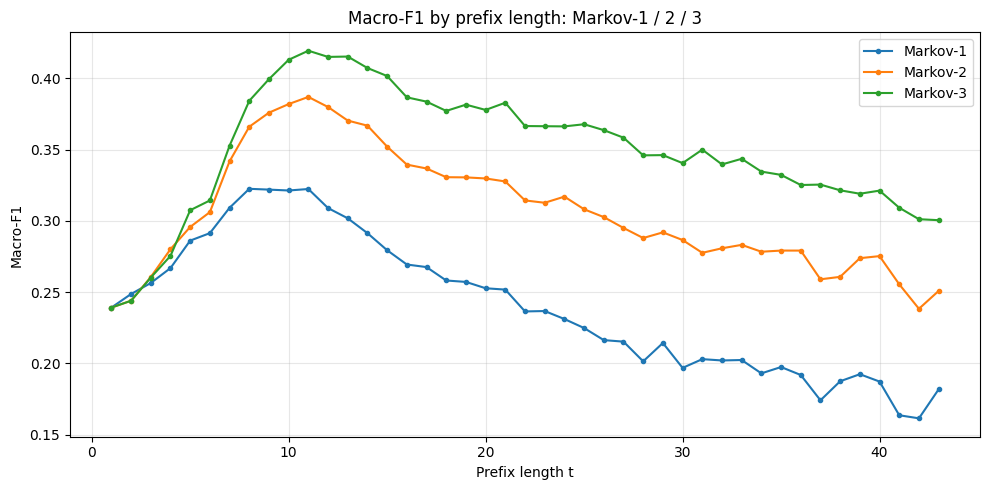


n_prefixes by t (same for all models):
 t  n_prefixes
 1       54020
 2       53751
 3       50152
 4       47400
 5       41926
 6       29118
 7       19148
 8       16751
 9       14780
10       12835
11       11588
12       10449
13        9465
14        8675
15        8049
16        7449
17        6938
18        6427
19        6029
20        5693
21        5364
22        5046
23        4756
24        4504
25        4308
26        4092
27        3898
28        3709
29        3573
30        3428
31        3309
32        3185
33        3067
34        2927
35        2810
36        2708
37        2612
38        2523
39        2429
40        2348
41        2273
42        2204
43        2136


In [40]:
# -- 4.7 Macro-F1 by prefix length t --

fig, ax = plt.subplots(figsize=(10, 5))

for name, res in results.items():
    by_t = res["by_t"]
    ax.plot(by_t["t"], by_t["macro_f1"], label=name, marker="o", markersize=3)

ax.set_xlabel("Prefix length t")
ax.set_ylabel("Macro-F1")
ax.set_title("Macro-F1 by prefix length: Markov-1 / 2 / 3")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -- Print n_prefixes to show support drop --
print("\nn_prefixes by t (same for all models):")
print(results["Markov-1"]["by_t"][["t", "n_prefixes"]].to_string(index=False))

In [41]:
# -- 4.7 Save Markov-3 test predictions to local and GCS --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

markov3_preds = build_predictions_df(
    sessions, "test", 3, transition_counts, prior, best_alphas[3], T_MAX)
markov3_preds.to_parquet(
    "/content/exp2_artifacts/markov3_test_predictions.parquet", index=False)
_bucket.blob(f"markov3_test_predictions_{_ts}.parquet").upload_from_filename(
    "/content/exp2_artifacts/markov3_test_predictions.parquet")

print(f"Saved to /content/exp2_artifacts/ and gs://{GCS_BUCKET}/:")
print(f"  markov3_test_predictions.parquet — {len(markov3_preds):,} rows")

del markov3_preds, _ts, _gcs_client, _bucket

Saved to /content/exp2_artifacts/ and gs://exp2data/:
  markov3_test_predictions.parquet — 497,852 rows


**4.7 Result:**

All three models evaluated on the test set using the same data, split, vocabulary, and T_max=43. Markov-1 alpha=0.0 (fixed); Markov-2/3 best $\alpha$ in the tested grid is 0.0.

| Model    | Macro-F1 |
|----------|----------|
| Markov-1 | 0.3186   |
| Markov-2 | 0.3794   |
| Markov-3 | 0.4221   |

**Per-class F1:**

| Class      | Markov-1 | Markov-2 | Markov-3 |
|------------|----------|----------|----------|
| Buyer      | 0.030    | 0.057    | 0.111    |
| Intent     | 0.147    | 0.237    | 0.284    |
| Researcher | 0.275    | 0.386    | 0.442    |
| Browser    | 0.822    | 0.837    | 0.852    |

Higher order improves Macro-F1 and per-class F1 for all classes. Gains from Markov-1 to Markov-3 are driven primarily by recall on minority classes: Buyer recall increases from 1.5% to 6.0% (x3.9), Intent from 8.3% to 18.1%, Researcher from 20.6% to 40.3%. Buyer precision decreases (0.784 to 0.667) as the model predicts Buyer more often, introducing more false positives; Macro-F1 still improves because the recall gain dominates. Buyer F1 remains the lowest across all orders (0.111 at Markov-3).

**Macro-F1(t):** all three models peak around t=8-11 and decline steadily at longer prefixes. This pattern is consistent with the session length distribution: at large t, only long (atypical) sessions contribute, which may be harder to classify. Markov-3 maintains a consistent advantage over Markov-2 and Markov-1 across all t values.

Note: Markov-1 here (0.3186) is recomputed under the Experiment 2 protocol. Cross-experiment comparisons are deferred to Section 7.

### Section 4 Summary

Section 4 evaluated higher-order n-gram Markov classifiers (n=2, n=3) as an extension of the Markov-1 baseline, using the same data, splits, vocabulary, and T_max=43 as the rest of Experiment 2.

**Coverage:** unseen-state sparsity is negligible for t≥n. The observed state space is compact (151 bigrams, 725 trigrams), and target-order coverage reaches ~100% for all but the shortest prefixes. The anticipated sparsity problem does not materialize at this vocabulary size; results suggest label ambiguity may be a stronger limitation than unseen states.

**Quality:** increasing order consistently improves Macro-F1: Markov-1 (0.3186) → Markov-2 (0.3794) → Markov-3 (0.4221). Gains are driven by recall improvements on minority classes, at the cost of lower precision for Buyer. Buyer F1 remains critically low (0.111 at Markov-3), confirming that n-gram patterns alone are insufficient to discriminate the most commercially relevant class.

**Macro-F1(t):** all models peak at t=8-11 and decline at longer prefixes. Markov-3 maintains a consistent advantage across all t values, but the absolute level remains low at early prefixes (t<5), where the commercially important classes Buyer and Intent are hardest to identify.

**Diagnostic implication:** higher-order local context helps, but the improvement saturates. The state space is well covered, yet quality remains below SASRec reported in Experiment 1; however, cross-experiment comparison is not yet controlled and will be addressed in Section 7 under a unified protocol. This points to label ambiguity as a likely core limitation: the same n-gram sequences appear across multiple classes, and local context expansion alone cannot resolve this without representations that generalize across rare and overlapping patterns.

## 5. Gradient Boosting + SHAP

Section 4 established the best result within the Markov family under this
protocol: even with stepwise backoff, Markov-3 reaches Macro-F1 of $0.4221$,
suggesting limitations beyond pure state sparsity. Markov models are inherently
constrained to local n-gram statistics and cannot incorporate temporal dynamics
or session-level context.

Section 5 addresses this gap by training a gradient boosting classifier
(LightGBM) on manually engineered prefix features. For each session prefix of
length `t`, we construct a fixed-width feature vector encoding sequence
statistics, key event flags, inter-event timing, recent n-gram suffixes, and
global session context. This allows the model to combine signals from multiple
feature groups that Markov models cannot represent.

Beyond predictive performance, the primary diagnostic goal of this section is
interpretability: SHAP analysis over the trained model provides diagnostic
guidance on which feature groups and individual features drive classification
decisions. These insights are used to characterize which event transitions,
temporal patterns, and contextual attributes carry the most signal within this
experiment.

LightGBM is selected for its native support for categorical features, efficient
handling of large prefix datasets, and compatibility with sample-level weighting,
which is required by the training protocol defined in Section 5.3.

### 5.1 Model Description

We train a multiclass LightGBM classifier on prefix-level feature vectors. Each
prefix of length `t` is treated as an independent observation for training
purposes, with a fixed-width feature vector constructed from the first `t` events
of the session. The model predicts the final session label
$y \in \{\text{Buyer}, \text{Intent}, \text{Researcher}, \text{Browser}\}$.

This formulation differs from sequential models (Markov, SASRec) in two
important ways. First, the input is a flat feature vector rather than an event
sequence, so the model has no notion of event order beyond what is explicitly
encoded in features (e.g., n-gram suffixes, `time_since_last_event_type`,
`has_{event}_occurred`). Second, all prefixes across all sessions are treated as
independent rows during training, which requires explicit sample weighting to
prevent long sessions from dominating the loss (see Section 5.3).

The model is trained with multiclass cross-entropy loss. Class imbalance is
handled through sample-level weights rather than `class_weight` parameter, as
the weighting scheme combines both class and session-length correction
(Section 5.3). Categorical context features are passed to LightGBM as
categorical features. All feature transformations and encoding artifacts,
including top-$K$ and top-$M$ selection, are fitted exclusively on the training
set and applied to validation and test sets without refitting.

### 5.2 Feature Engineering

For each session prefix of length `t`, we construct a fixed-width feature vector
from five groups. All transformations are fitted exclusively on the training set.

**Sequence features.**
Basic statistics over the first `t` events: prefix length `t`, absolute count of
each vocabulary token, and normalized frequency (count divided by `t`). Both
representations are retained intentionally: absolute counts encode scale, while
normalized frequencies encode composition independently of `t`. Shannon entropy
of the token frequency distribution:
$$H = -\sum_{e} \hat{p}(e) \log \hat{p}(e)$$
where $\hat{p}(e)$ is the normalized frequency of event type $e$ in the prefix
and $\log$ denotes the natural logarithm.

**Key event flags.**
Binary indicator `has_{event}` for each of the following events:
`purchase`, `add_to_cart`, `begin_checkout`, `add_payment_info`,
`add_shipping_info`, computed strictly over the first `t` events. These flags
are informative at large `t` by construction; the primary diagnostic focus for
this feature group is $t < 10$ and classes Buyer and Intent.

**Time features.**
Three temporal features per prefix:
- `avg_dt`: mean inter-event interval between consecutive events in the prefix,
  averaged over $t - 1$ intervals (in seconds); defined as $0$ for $t = 1$.
- `time_since_start`: elapsed time from the first to the last event in the
  prefix, $\tau_t - \tau_1$ (in seconds).
- `time_since_last_event_type_e`: time elapsed since the most recent occurrence
  of event type `e` in the prefix (in seconds), for each key event type `e`
  listed above.

For cases where event type `e` has not yet occurred in the prefix,
`time_since_last_{event}` is set to `MAX_DT`, defined as the $p99$ of the
inter-event interval distribution on the training set (in seconds). A companion
binary flag `has_{event}_occurred` is defined per event type `e`,
distinguishing "not yet seen" from "seen long ago".

**N-gram features.**
Bigram and trigram extracted from the **last $n$ events of the prefix (suffix)**,
not from arbitrary positions within the first `t` events. Each n-gram is
represented as a binary indicator. The vocabulary of n-grams is built from the
training set; the top-$M$ most frequent bigrams and trigrams are retained
separately, where $M$ is chosen to cover $95\%$ of all n-gram occurrences in
train. Remaining n-gra

In [42]:
# -- 5.2 Constants: key events and context fields --

KEY_EVENTS = [
    "purchase",
    "add_to_cart",
    "begin_checkout",
    "add_payment_info",
    "add_shipping_info",
]

# -- Group A: low cardinality --
CONTEXT_FIELDS_A = [
    "device_category",
    "continent",
    "traffic_source",
    "traffic_medium",
]

# -- Group B: medium cardinality --
CONTEXT_FIELDS_B = [
    "device_os",
    "browser",
    "device_language",
]

# -- Group C: high cardinality, top-K + <OTHER> encoding (K=50) --
CONTEXT_FIELDS_C = [
    "country",
    "region",
    "traffic_campaign",
]

# -- Field order is fixed; feature matrix must follow this order --
CONTEXT_FIELDS_ALL = CONTEXT_FIELDS_A + CONTEXT_FIELDS_B + CONTEXT_FIELDS_C

TOP_K = 50              # top-K threshold for group C fields, as defined in Section 5.2
NGRAM_COVERAGE = 0.95   # retain top-M n-grams covering this fraction of train occurrences

# -- categorical columns in the feature matrix (ctx_ prefix matches build_prefix_features output) --
CATEGORICAL_COLS = [f"ctx_{f}" for f in CONTEXT_FIELDS_ALL]

In [43]:
# -- 5.2 MAX_DT: p99 of inter-event intervals on train --
# -- dt[0] is defined as 0 (first event has no preceding event); excluded explicitly --

train_sessions = sessions[sessions["split"] == "train"]

train_dt_values = []
for dt in train_sessions["dt"]:
    # -- skip missing or non-list values --
    if not isinstance(dt, (list, np.ndarray)):
        continue
    arr = np.array(dt, dtype=float)
    # -- exclude dt[0] (defined as 0 by construction) and non-positive values --
    valid = arr[1:]
    valid = valid[valid > 0]
    if len(valid) > 0:
        train_dt_values.append(valid)

assert len(train_dt_values) > 0, "No valid inter-event intervals found in train set"

train_dt_values = np.concatenate(train_dt_values)

MAX_DT = float(np.percentile(train_dt_values, 99))

print(f"Train inter-event intervals: {len(train_dt_values):,} values")
print(f"MAX_DT (p99): {MAX_DT:.2f} seconds")

Train inter-event intervals: 1,941,865 values
MAX_DT (p99): 585.71 seconds


In [44]:
# -- 5.2 N-gram vocabulary: top-M bigrams and trigrams on train --

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
SKIP_TOKENS = {PAD_TOKEN, UNK_TOKEN}

bigram_counter  = Counter()
trigram_counter = Counter()

for tokens in train_sessions["tokens"]:
    if not isinstance(tokens, (list, np.ndarray)):
        continue
    # -- filter PAD/UNK tokens before counting --
    filtered = [t for t in tokens if t not in SKIP_TOKENS]
    # -- one pass over positions; suffix n-gram at position i is equivalent
    #    to all prefix suffix n-grams across all prefixes ending at i --
    for i in range(len(filtered)):
        if i >= 1:
            bigram_counter[(filtered[i - 1], filtered[i])] += 1
        if i >= 2:
            trigram_counter[(filtered[i - 2], filtered[i - 1], filtered[i])] += 1

def select_top_m(counter, coverage):
    # -- select top-M n-grams covering `coverage` fraction of total occurrences --
    total = sum(counter.values())
    if total == 0:
        return []
    threshold = total * coverage
    cumsum = 0
    top_m = []
    for ngram, count in counter.most_common():
        cumsum += count
        top_m.append(ngram)
        if cumsum >= threshold:
            break
    return top_m

bigram_vocab  = select_top_m(bigram_counter,  NGRAM_COVERAGE)
trigram_vocab = select_top_m(trigram_counter, NGRAM_COVERAGE)

# -- index: n-gram -> feature column index; OTHER_NGRAM gets last index --
bigram_index  = {ng: i for i, ng in enumerate(bigram_vocab)}
trigram_index = {ng: i for i, ng in enumerate(trigram_vocab)}

BIGRAM_OTHER_IDX  = len(bigram_vocab)
TRIGRAM_OTHER_IDX = len(trigram_vocab)

print(f"Bigram  vocab size (top-M at {NGRAM_COVERAGE:.0%} coverage): {len(bigram_vocab)}")
print(f"Trigram vocab size (top-M at {NGRAM_COVERAGE:.0%} coverage): {len(trigram_vocab)}")
print(f"Bigram  <OTHER_NGRAM> index: {BIGRAM_OTHER_IDX}")
print(f"Trigram <OTHER_NGRAM> index: {TRIGRAM_OTHER_IDX}")

Bigram  vocab size (top-M at 95% coverage): 36
Trigram vocab size (top-M at 95% coverage): 118
Bigram  <OTHER_NGRAM> index: 36
Trigram <OTHER_NGRAM> index: 118


In [45]:
# -- 5.2 Context encoding artifacts: top-K for group C fields --

top_k_artifacts = {}

for field in CONTEXT_FIELDS_C:
    # -- fill missing with MISSING, cast to str to avoid mixed types --
    values = train_sessions[field].fillna("MISSING").astype(str)
    counts = values.value_counts()
    # -- exclude MISSING from top-K slots --
    counts_no_missing = counts.drop("MISSING", errors="ignore")
    top_values = set(counts_no_missing.iloc[:TOP_K].index.tolist())
    top_k_artifacts[field] = top_values
    n_unique = len(counts_no_missing)
    print(f"{field}: {n_unique} non-missing unique values in train, retaining top {TOP_K}")

print(f"\nTop-K artifacts fitted on train for: {list(top_k_artifacts.keys())}")
print("Missing values will be mapped to 'MISSING' at encoding time (not included in top-K slots)")

country: 109 non-missing unique values in train, retaining top 50
region: 367 non-missing unique values in train, retaining top 50
traffic_campaign: 5 non-missing unique values in train, retaining top 50

Top-K artifacts fitted on train for: ['country', 'region', 'traffic_campaign']
Missing values will be mapped to 'MISSING' at encoding time (not included in top-K slots)


In [46]:
# -- 5.2 Feature construction function for a single prefix --

def build_prefix_features(tokens, dt, context, t, vocab, bigram_index, trigram_index,
                          top_k_artifacts):
    # -- tokens and dt are full session lists; prefix is first t elements --
    # -- dt[j] = interval from event j-1 to event j (dt[0] = 0 by construction) --
    assert t >= 1, f"Prefix length must be >= 1, got {t}"

    prefix_tokens = tokens[:t]
    prefix_dt     = dt[:t]
    features      = {}

    # -- Sequence features --
    features["prefix_len"] = t
    token_counts = Counter(prefix_tokens)
    for token in vocab:
        if token in ("<PAD>", "<UNK>"):
            continue
        features[f"count_{token}"] = token_counts.get(token, 0)
        features[f"freq_{token}"]  = token_counts.get(token, 0) / t

    token_freqs = np.array([token_counts.get(tok, 0) / t for tok in vocab
                            if tok not in ("<PAD>", "<UNK>")])
    token_freqs = token_freqs[token_freqs > 0]
    features["entropy"] = float(-np.sum(token_freqs * np.log(token_freqs))) if len(token_freqs) > 0 else 0.0

    # -- Key event flags --
    prefix_set = set(prefix_tokens)
    for event in KEY_EVENTS:
        features[f"has_{event}"] = int(event in prefix_set)

    # -- Time features --
    # -- avg_dt: mean over positive intervals only (dt[0]=0 excluded by [1:]) --
    valid_dt = [d for d in prefix_dt[1:] if d > 0]
    features["avg_dt"] = float(np.mean(valid_dt)) if valid_dt else 0.0

    # -- time_since_start: sum of dt[1:t], non-positive values clamped to 0 --
    features["time_since_start"] = float(sum(max(d, 0) for d in prefix_dt[1:]))

    # -- time_since_last_{event}: sum of dt[last_idx+1 .. t-1]
    #    dt[j] is the interval from event j-1 to event j, so summing dt from
    #    last_idx+1 to t-1 gives elapsed time from last occurrence to end of prefix --
    for event in KEY_EVENTS:
        occurred = False
        time_acc = 0.0
        for i in range(t - 1, -1, -1):
            if prefix_tokens[i] == event:
                occurred = True
                break
            time_acc += max(prefix_dt[i], 0)
        features[f"has_{event}_occurred"]    = int(occurred)
        features[f"time_since_last_{event}"] = time_acc if occurred else MAX_DT

    # -- N-gram features (suffix): only set indicator for matched index; absent keys = 0 --
    filtered = [tok for tok in prefix_tokens if tok not in SKIP_TOKENS]

    bg = tuple(filtered[-2:]) if len(filtered) >= 2 else None
    tg = tuple(filtered[-3:]) if len(filtered) >= 3 else None

    if bg is not None:
        idx = bigram_index.get(bg, BIGRAM_OTHER_IDX)
        features[f"bigram_{idx}"] = 1

    if tg is not None:
        idx = trigram_index.get(tg, TRIGRAM_OTHER_IDX)
        features[f"trigram_{idx}"] = 1

    # -- Context features --
    for field in CONTEXT_FIELDS_ALL:
        raw = context.get(field, None)
        if raw is None or (isinstance(raw, float) and np.isnan(raw)):
            val = "MISSING"
        else:
            val = str(raw)
        if field in CONTEXT_FIELDS_C:
            val = val if val in top_k_artifacts[field] else "<OTHER>"
        features[f"ctx_{field}"] = val

    return features

In [47]:
# -- 5.2 Smoke test: feature construction on single prefix --

_row = train_sessions.iloc[0]
_feats = build_prefix_features(
    _row["tokens"], _row["dt"],
    {f: _row.get(f) for f in CONTEXT_FIELDS_ALL},
    t=1, vocab=vocab,
    bigram_index=bigram_index,
    trigram_index=trigram_index,
    top_k_artifacts=top_k_artifacts
)
print(f"Feature count (t=1): {len(_feats)}")
print(f"Sample keys: {list(_feats.keys())[:8]}")

Feature count (t=1): 63
Sample keys: ['prefix_len', 'count_add_payment_info', 'freq_add_payment_info', 'count_add_shipping_info', 'freq_add_shipping_info', 'count_add_to_cart', 'freq_add_to_cart', 'count_begin_checkout']


> Smoke test passed: feature construction verified on a single prefix (`63` features at `t=1`).
Proceeding to full prefix dataset generation for train / val / test — this may take several minutes.

In [48]:
  # -- 5.2 Prefix dataset generation for train / val / test --

T_MAX = 43  # p95 train session length, fixed in Section 1.5

def build_prefix_dataset(sessions_df, split, vocab, bigram_index, trigram_index,
                         top_k_artifacts, max_t=T_MAX):
    split_sessions = sessions_df[sessions_df["split"] == split].copy()
    records = []

    for _, row in split_sessions.iterrows():
        tokens = row["tokens"]
        dt     = row["dt"]

        # -- validate types before accessing len --
        if not isinstance(tokens, (list, np.ndarray)):
            continue
        if not isinstance(dt, (list, np.ndarray)):
            continue

        session_len = len(tokens)
        if session_len == 0:
            continue

        y          = row["y"]
        session_id = row["session_id"]
        context    = {field: row.get(field, None) for field in CONTEXT_FIELDS_ALL}

        for t in range(1, min(session_len, max_t) + 1):
            feats = build_prefix_features(
                tokens, dt, context, t, vocab,
                bigram_index, trigram_index, top_k_artifacts
            )
            feats["session_id"]  = session_id
            feats["t"]           = t
            feats["y_true"]      = y
            feats["session_len"] = session_len
            records.append(feats)

    prefix_df = pd.DataFrame(records)
    # -- fill absent n-gram indicator columns with 0 --
    ngram_cols = [c for c in prefix_df.columns
                  if c.startswith("bigram_") or c.startswith("trigram_")]
    prefix_df[ngram_cols] = prefix_df[ngram_cols].fillna(0).astype(int)

    print(f"[{split}] sessions: {len(split_sessions):,} | prefixes: {len(prefix_df):,}")
    return prefix_df


prefix_train = build_prefix_dataset(sessions, "train", vocab, bigram_index,
                                    trigram_index, top_k_artifacts)
prefix_val   = build_prefix_dataset(sessions, "val",   vocab, bigram_index,
                                    trigram_index, top_k_artifacts)
prefix_test  = build_prefix_dataset(sessions, "test",  vocab, bigram_index,
                                    trigram_index, top_k_artifacts)

[train] sessions: 252,090 | prefixes: 2,362,299
[val] sessions: 54,019 | prefixes: 465,782
[test] sessions: 54,020 | prefixes: 497,852


In [49]:
# -- 5.2 TEMPORARY: save prefix datasets locally and to GCS; delete after final run --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

for _name, _df in [("prefix_train", prefix_train), ("prefix_val", prefix_val), ("prefix_test", prefix_test)]:
    _local_path = f"/content/exp2_artifacts/{_name}.parquet"
    _df.to_parquet(_local_path, index=False)
    _bucket.blob(f"{_name}_{_ts}.parquet").upload_from_filename(_local_path)

print(f"Saved prefix datasets to /content/exp2_artifacts/ and gs://{GCS_BUCKET}/:")
print(f"  prefix_train.parquet: {len(prefix_train):,} rows")
print(f"  prefix_val.parquet:   {len(prefix_val):,} rows")
print(f"  prefix_test.parquet:  {len(prefix_test):,} rows")

Saved prefix datasets to /content/exp2_artifacts/ and gs://exp2data/:
  prefix_train.parquet: 2,362,299 rows
  prefix_val.parquet:   465,782 rows
  prefix_test.parquet:  497,852 rows


In [50]:
# -- 5.2 TEMPORARY: backup feature engineering artifacts to local and GCS; delete after final run --

_ts = datetime.now().strftime("%d%m%y_%H%M")

_fe_artifacts = {
    "MAX_DT": MAX_DT,
    "BIGRAM_OTHER_IDX": BIGRAM_OTHER_IDX,
    "TRIGRAM_OTHER_IDX": TRIGRAM_OTHER_IDX,
    "top_k_artifacts": {k: list(v) for k, v in top_k_artifacts.items()},
    "bigram_vocab": [list(ng) for ng in bigram_index.keys()],
    "trigram_vocab": [list(ng) for ng in trigram_index.keys()],
}

# -- local --
_local_fe = f"/content/exp2_artifacts/fe_artifacts.json"
with open(_local_fe, "w") as f:
    json.dump(_fe_artifacts, f, indent=2)

# -- GCS --
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)
_bucket.blob(f"fe_artifacts_{_ts}.json").upload_from_filename(_local_fe)

print(f"Backed up fe_artifacts_{_ts}.json locally and to gs://{GCS_BUCKET}/")
print(f"  MAX_DT: {MAX_DT:.2f}")
print(f"  bigram vocab: {len(bigram_index)}, trigram vocab: {len(trigram_index)}")

Backed up fe_artifacts_250226_0513.json locally and to gs://exp2data/
  MAX_DT: 585.71
  bigram vocab: 36, trigram vocab: 118


In [51]:
# --- Intermediate cleanup: free heavy prefix-generation intermediates ---
# Prefix dataset is built, so release counters/scratch arrays/temporary session holders.
to_del = [
    "train_sessions", "val_sessions", "test_sessions",
    "bigram_counter", "trigram_counter",
    "train_dt_values",
    "records",  # if it exists in the global scope
]
for name in to_del:
    if name in globals():
        del globals()[name]
gc.collect()

589

### 5.3 Training Protocol

Each prefix is treated as an independent training row. To ensure that every
session contributes equally to the loss regardless of its length, each prefix
is assigned a sample weight:

$$w = \frac{\text{class\_weight}[y]}{T}$$

where $\text{class\_weight}[y]$ is the session-level class weight from
Section 3.4, computed from train session-level labels (one label per session)
via `compute_class_weight`, and $T$ is the full session length. Prefixes are
generated up to $t = T\_MAX = 43$, so for sessions with $T > T\_MAX$ the sum
of weights across all prefixes equals $\text{class\_weight}[y] \cdot T\_MAX /
T$ rather than $\text{class\_weight}[y]$. This is consistent with the prefix
truncation applied uniformly across all models in this experiment.

Sample weights are passed to LightGBM via the `sample_weight` parameter of
the training dataset. The built-in `class_weight` parameter is not used, as
the weighting scheme combines both class imbalance and session-length
correction.

All feature encoding artifacts (vocabulary, top-$M$ n-gram indices,
top-$K$ context mappings, `MAX_DT`) are fitted exclusively on the training
set and applied to validation and test sets without refitting.

In [52]:
# -- 5.3 Defragment prefix DataFrames after column-wise construction --

prefix_train = prefix_train.copy()
prefix_val   = prefix_val.copy()
prefix_test  = prefix_test.copy()

print("DataFrames defragmented.")

DataFrames defragmented.


In [53]:
# -- 5.3 Compute sample weights for train prefixes --

train_labels = sessions[sessions["split"] == "train"]["y"].values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(LABELS),
    y=train_labels
)
class_weight_dict = dict(zip(LABELS, class_weights))

# -- vectorized: class_weight[y] / session_length (full session length T) --
prefix_train["sample_weight"] = (
    prefix_train["y_true"].map(class_weight_dict) / prefix_train["session_len"]
)

print("Class weights:")
for label, w in class_weight_dict.items():
    print(f"  {label}: {w:.4f}")
print(f"\nSample weights assigned to {len(prefix_train):,} train prefixes")
print(f"Weight range: [{prefix_train['sample_weight'].min():.6f}, {prefix_train['sample_weight'].max():.4f}]")

Class weights:
  Buyer: 16.6462
  Intent: 5.3875
  Researcher: 4.3285
  Browser: 0.2838

Sample weights assigned to 2,362,299 train prefixes
Weight range: [0.000708, 8.3231]


**5.3 Result:**

Class weights recomputed from 252,090 train session-level labels, consistent
with Section 3.4:

| Class | Class Weight |
|---|---|
| Buyer | 16.6462 |
| Intent | 5.3875 |
| Researcher | 4.3285 |
| Browser | 0.2838 |

Sample weights assigned to all 2,362,299 train prefixes via
`sample_weight = class_weight[y] / T`, where $T$ is the full session length.
Weight range: [0.000708, 8.3231].

### 5.4 Hyperparameter Tuning

Hyperparameters are selected via Bayesian optimization (Optuna TPE) on a
temporal validation subset held out from the training set. To prevent leakage,
the split is performed at the session level: train sessions are sorted by
`session_end_ts` and the first 80% are used for fitting, the remaining 20% for
evaluation. All prefixes of a given session appear in exactly one subset.

Categorical context features are label-encoded prior to tuning: encoders are
fitted on the full training set and treated as fixed preprocessing artifacts.

The selection criterion is Macro-F1 computed over all prefix rows in the
holdout subset, evaluated via `evaluate()` from Section 3.2. The test set is
not accessed at any point during tuning.

The following hyperparameters are searched over 50 trials using the LightGBM
sklearn API (`LGBMClassifier`). Early stopping (30 rounds) is applied within
each trial on `multi_logloss` to avoid over-estimating `n_estimators`.
Trials are run sequentially (`n_jobs=1`, `TPESampler(seed=42)`) to ensure
full reproducibility. Within each trial, LightGBM is trained with `n_jobs=1`:

| Parameter | Search Space |
|---|---|
| `num_leaves` | {31, 63, 127, 255} |
| `max_depth` | {-1, 8, 16} |
| `learning_rate` | log-uniform $[0.02,\ 0.15]$ |
| `n_estimators` | uniform int $[200,\ 800]$ |
| `min_child_samples` | {20, 50, 100} |
| `subsample` | uniform $[0.7,\ 1.0]$ |
| `colsample_bytree` | uniform $[0.7,\ 1.0]$ |
| `reg_lambda` | log-uniform $[10^{-3},\ 10.0]$ |

The best configuration is used for final training in Section 5.5.

In [54]:
# -- 5.4 Temporal holdout split within train (session-level, 80/20) --

train_sessions_sorted = (
    sessions[sessions["split"] == "train"]
    .sort_values("session_end_ts")
    .reset_index(drop=True)
)

assert train_sessions_sorted["session_end_ts"].notna().all(), \
    "session_end_ts contains NaN in train sessions"

cutoff_idx = int(len(train_sessions_sorted) * 0.80)
tune_train_ids = set(train_sessions_sorted.iloc[:cutoff_idx]["session_id"])
tune_val_ids   = set(train_sessions_sorted.iloc[cutoff_idx:]["session_id"])

tune_train = prefix_train[prefix_train["session_id"].isin(tune_train_ids)].reset_index(drop=True)
tune_val   = prefix_train[prefix_train["session_id"].isin(tune_val_ids)].reset_index(drop=True)

print(f"Tune train: {len(tune_train_ids):,} sessions | {len(tune_train):,} prefixes")
print(f"Tune val:   {len(tune_val_ids):,} sessions | {len(tune_val):,} prefixes")

Tune train: 201,672 sessions | 1,953,552 prefixes
Tune val:   50,418 sessions | 408,747 prefixes


In [55]:
# -- 5.4 Label-encode categorical context columns (fitted on full train) --
# -- encoding artifacts are preprocessing, fitted prior to tuning --

MISSING_LABEL = "MISSING"
label_encoders = {}

for col in CATEGORICAL_COLS:
    # -- fillna before astype(str) to guarantee MISSING is a real category if present --
    prefix_train[col] = prefix_train[col].fillna(MISSING_LABEL).astype(str)

    # -- most frequent class in train (post-fillna) used as fallback if MISSING absent --
    most_freq = prefix_train[col].value_counts().idxmax()

    le = LabelEncoder()
    le.fit(prefix_train[col])
    known    = set(le.classes_)
    fallback = MISSING_LABEL if MISSING_LABEL in known else most_freq

    # -- transform: unseen values mapped to fallback before encoding --
    for df in [prefix_train, prefix_val, prefix_test]:
        df[col] = df[col].fillna(MISSING_LABEL).astype(str).map(
            lambda x, k=known, f=fallback: x if x in k else f
        )
        df[col] = le.transform(df[col])
    label_encoders[col] = le

# -- rebuild tune subsets after encoding --
tune_train = prefix_train[prefix_train["session_id"].isin(tune_train_ids)].reset_index(drop=True)
tune_val   = prefix_train[prefix_train["session_id"].isin(tune_val_ids)].reset_index(drop=True)

print(f"Label-encoded {len(CATEGORICAL_COLS)} categorical columns on full train.")
print(f"Unseen values mapped to MISSING (if present) or most frequent class.")

Label-encoded 10 categorical columns on full train.
Unseen values mapped to MISSING (if present) or most frequent class.


In [56]:
# -- 5.4 TEMPORARY: backup label encoders to local and GCS; delete after final run --

_ts = datetime.now().strftime("%d%m%y_%H%M")

# -- local --
_local_le = f"/content/exp2_artifacts/label_encoders.pkl"
with open(_local_le, "wb") as f:
    pickle.dump(label_encoders, f)

# -- GCS --
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)
_bucket.blob(f"label_encoders_{_ts}.pkl").upload_from_filename(_local_le)

print(f"Backed up label_encoders_{_ts}.pkl locally and to gs://{GCS_BUCKET}/")
print(f"  Columns: {list(label_encoders.keys())}")

Backed up label_encoders_250226_0513.pkl locally and to gs://exp2data/
  Columns: ['ctx_device_category', 'ctx_continent', 'ctx_traffic_source', 'ctx_traffic_medium', 'ctx_device_os', 'ctx_browser', 'ctx_device_language', 'ctx_country', 'ctx_region', 'ctx_traffic_campaign']


In [57]:
# --- Intermediate cleanup: release tuning intermediates (keep only what is required) ---
# After tune_train/tune_val and X/y/w are created, old split frames can be dropped.
to_del = [
    "tune_df", "tune_train_df", "tune_val_df",
    "tune_train_sessions", "tune_val_sessions",
]
for name in to_del:
    if name in globals():
        del globals()[name]
import gc
gc.collect()

80

In [58]:
# -- 5.4 Prepare feature matrices after label encoding --

FEATURE_COLS = [c for c in prefix_train.columns
                if c not in ("session_id", "t", "y_true", "session_len", "sample_weight")]

X_tune_train = tune_train[FEATURE_COLS]
y_tune_train = tune_train["y_true"]
w_tune_train = tune_train["sample_weight"]

X_tune_val = tune_val[FEATURE_COLS]
y_tune_val = tune_val["y_true"]

print(f"X_tune_train shape: {X_tune_train.shape}")
print(f"X_tune_val shape:   {X_tune_val.shape}")
print(f"Dtypes sample: {X_tune_train.dtypes.value_counts().to_dict()}")

X_tune_train shape: (1953552, 219)
X_tune_val shape:   (408747, 219)
Dtypes sample: {dtype('int64'): 194, dtype('float64'): 25}


In [59]:
# -- 5.4 Smoke test: single LGBMClassifier fit before grid search --

_model = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=50,
    objective="multiclass",
    class_weight=None,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)
_model.fit(
    X_tune_train, y_tune_train,
    sample_weight=w_tune_train,
    categorical_feature=CATEGORICAL_COLS,
)
_y_pred = _model.predict(X_tune_val)
_macro_f1, _ = evaluate(y_tune_val.values, y_pred=_y_pred, labels=LABELS)

print(f"Smoke test passed: macro_f1={_macro_f1:.4f}")
print(f"Feature matrix shape: {X_tune_train.shape}")
print(f"Categorical features: {len(CATEGORICAL_COLS)} columns verified")

Smoke test passed: macro_f1=0.5362
Feature matrix shape: (1953552, 219)
Categorical features: 10 columns verified


In [60]:
# --- Intermediate cleanup: free smoke-test objects ---
# Smoke test is finished, keep only tuning datasets in memory.
to_del = [
    "smoke_model",
    "y_smoke_pred",
    "y_smoke_proba",
    "smoke_report",
    "X_smoke_train", "y_smoke_train", "w_smoke_train",
    "X_smoke_val",   "y_smoke_val",   "w_smoke_val",
    "df_smoke_train", "df_smoke_val",
]
for name in to_del:
    if name in globals():
        del globals()[name]

gc.collect()

48

In [61]:
# --- Intermediate cleanup: reduce duplicated prefix/tuning frames before Optuna ---
to_del = ["tune_train", "tune_val", "df"]
for name in to_del:
    if name in globals():
        del globals()[name]

# -- release sessions and sort buffer; prefix_train kept for 5.5 --
to_del2 = ["sessions", "dt_df", "subset", "train_sessions_sorted"]
for name in to_del2:
    if name in globals():
        del globals()[name]

gc.collect()

0

In [62]:
# -- 5.4 Hyperparameter tuning via Optuna TPE search (LGBMClassifier, sklearn API) --
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        "num_leaves":        trial.suggest_categorical("num_leaves", [31, 63, 127, 255]),
        "max_depth":         trial.suggest_categorical("max_depth", [-1, 8, 16]),
        "learning_rate":     trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "n_estimators":      trial.suggest_int("n_estimators", 200, 800),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [20, 50, 100]),
        "subsample":         trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_lambda":        trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }
    model = lgb.LGBMClassifier(
        **params,
        objective="multiclass",
        class_weight=None,
        random_state=42,
        n_jobs=1,
        verbose=-1,
    )
    model.fit(
        X_tune_train, y_tune_train,
        sample_weight=w_tune_train,
        categorical_feature=CATEGORICAL_COLS,
        eval_set=[(X_tune_val, y_tune_val)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
    )
    y_pred = model.predict(X_tune_val)
    macro_f1, _ = evaluate(y_tune_val.values, y_pred=y_pred, labels=LABELS)
    print(f"  trial {trial.number}: macro_f1={macro_f1:.4f} | {params}")
    return macro_f1

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=50, n_jobs=1)

print(f"\nBest macro_f1: {study.best_value:.4f}")
print(f"Best params:   {study.best_params}")

  trial 0: macro_f1=0.5389 | {'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.11454791487656053, 'n_estimators': 561, 'min_child_samples': 100, 'subsample': 0.9497327922401265, 'colsample_bytree': 0.7637017332034828, 'reg_lambda': 0.005337032762603957}
  trial 1: macro_f1=0.5386 | {'num_leaves': 127, 'max_depth': 8, 'learning_rate': 0.03603084612270474, 'n_estimators': 420, 'min_child_samples': 50, 'subsample': 0.8542703315240835, 'colsample_bytree': 0.8777243706586128, 'reg_lambda': 0.0015339162591163618}
  trial 2: macro_f1=0.5453 | {'num_leaves': 255, 'max_depth': -1, 'learning_rate': 0.02435000636897718, 'n_estimators': 611, 'min_child_samples': 100, 'subsample': 0.7103165563345655, 'colsample_bytree': 0.9727961206236346, 'reg_lambda': 0.010842262717330166}
  trial 3: macro_f1=0.5378 | {'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.13278503317665077, 'n_estimators': 737, 'min_child_samples': 50, 'subsample': 0.7587948587257435, 'colsample_bytree': 0.7135681866731614, '

In [63]:
# -- 5.4 TEMPORARY: save best params locally and to GCS; delete after final run --

import json, os

_ts = datetime.now().strftime("%d%m%y_%H%M")

best_params_to_save = study.best_params.copy()
best_params_to_save["best_macro_f1"] = study.best_value

# -- local --
_local_bp = f"/content/exp2_artifacts/lgbm_best_params.json"
os.makedirs("/content/exp2_artifacts", exist_ok=True)
with open(_local_bp, "w") as f:
    json.dump(best_params_to_save, f, indent=2)

# -- GCS --
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)
_bucket.blob(f"lgbm_best_params_{_ts}.json").upload_from_filename(_local_bp)

print(f"Saved lgbm_best_params_{_ts}.json locally and to gs://{GCS_BUCKET}/")
print(json.dumps(best_params_to_save, indent=2))

Saved lgbm_best_params_250226_1253.json locally and to gs://exp2data/
{
  "num_leaves": 255,
  "max_depth": -1,
  "learning_rate": 0.07485577425778983,
  "n_estimators": 653,
  "min_child_samples": 20,
  "subsample": 0.7441241599830011,
  "colsample_bytree": 0.8114395914980221,
  "reg_lambda": 0.013339277593852828,
  "best_macro_f1": 0.5511726887725104
}


In [64]:
# -- TEMPORARY: manually restore lgbm_best_params.json when study is not in memory;
# -- delete after final run where 5.4 Optuna cell saves this automatically --

import json, os

best_params = {
    "num_leaves": 255,
    "max_depth": -1,
    "learning_rate": 0.07485577425778983,
    "n_estimators": 653,
    "min_child_samples": 20,
    "subsample": 0.7441241599830011,
    "colsample_bytree": 0.8114395914980221,
    "reg_lambda": 0.013339277593852828,
    "best_macro_f1": 0.5511726887725104
}

os.makedirs("/content/exp2_artifacts", exist_ok=True)
with open("/content/exp2_artifacts/lgbm_best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

print("Saved.")

Saved.


**5.4 Result:**

Hyperparameter search via Optuna TPE (50 trials, sequential, `TPESampler(seed=42)`).

| Parameter | Value |
|---|---|
| `num_leaves` | 255 |
| `max_depth` | -1 |
| `learning_rate` | 0.0749 |
| `n_estimators` | 653 |
| `min_child_samples` | 20 |
| `subsample` | 0.744 |
| `colsample_bytree` | 0.811 |
| `reg_lambda` | 0.0133 |

Best tune Macro-F1: **0.5512**. The search is fully deterministic (`TPESampler(seed=42)`, `n_jobs=1`).

### 5.5 Model Training

The final model is trained on the full training set using the best
hyperparameters identified in Section 5.4. All 2,362,299 train prefixes are
used for fitting, with sample weights from Section 5.3. Categorical context
features are provided to LightGBM as categorical using label encoders fitted
on the full training set prior to tuning.

No validation set is used during final training: early stopping is disabled
and `n_estimators` is fixed to the best value from Optuna.

In [65]:
# -- 5.5 Prepare full train feature matrix --

FEATURE_COLS = [c for c in prefix_train.columns
                if c not in ("session_id", "t", "y_true", "session_len", "sample_weight")]

X_train = prefix_train[FEATURE_COLS]
y_train = prefix_train["y_true"].map({label: i for i, label in enumerate(LABELS)})
w_train = prefix_train["sample_weight"]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2362299, 219)
y_train shape: (2362299,)


In [66]:
# -- 5.5 Final model training on full train set --

with open("/content/exp2_artifacts/lgbm_best_params.json") as f:
    best_params = json.load(f)
best_params.pop("best_macro_f1", None)

lgbm_final = lgb.LGBMClassifier(
    **best_params,
    objective="multiclass",
    class_weight=None,
    random_state=42,
    n_jobs=1,
    verbose=-1,
)

lgbm_final.fit(
    X_train, y_train,
    sample_weight=w_train,
    categorical_feature=CATEGORICAL_COLS,
)

print("Final model trained.")
print(f"  n_estimators (fixed): {best_params['n_estimators']}")
print(f"  num_trees (booster):  {lgbm_final.booster_.num_trees()}")
print(f"  num_leaves:           {best_params['num_leaves']}")
print(f"  Train prefixes:       {len(X_train):,}")

Final model trained.
  n_estimators (fixed): 653
  num_trees (booster):  2612
  num_leaves:           255
  Train prefixes:       2,362,299


In [67]:
# -- 5.5 Save final model to local and GCS --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

# -- local --
_local_model = f"/content/exp2_artifacts/lgbm_final.pkl"
with open(_local_model, "wb") as f:
    pickle.dump(lgbm_final, f)

# -- GCS --
_bucket.blob(f"lgbm_final_{_ts}.pkl").upload_from_filename(_local_model)
print(f"Saved lgbm_final_{_ts}.pkl locally and to gs://{GCS_BUCKET}/")

Saved lgbm_final_250226_1300.pkl locally and to gs://exp2data/


**5.5 Result:**

The final LightGBM model was trained on all 2,362,299 train prefixes using the hyperparameters selected in Section 5.4 (e.g., `num_leaves=255`, `learning_rate=0.0749`, `n_estimators=653`, `min_child_samples=20`). With the multiclass objective, LightGBM builds one tree per class per boosting round, resulting in 2,612 total trees (653 rounds x 4 classes). The configuration selected in Section 5.4 achieved Macro-F1 = 0.5512 on the tuning holdout. The trained model is saved to `lgbm_final.pkl` for evaluation in Section 5.6.

In [68]:
# --- Intermediate cleanup: free full train matrices after model is saved ---
to_del = ["X_train", "y_train", "w_train"]
for name in to_del:
    if name in globals():
        del globals()[name]
gc.collect()

239

### 5.6 Evaluation

We evaluate the trained LightGBM model on the test set using the protocol
defined in Section 3. Predictions are generated for all test prefixes and
evaluated via `evaluate()` and `evaluate_by_t()`.

Reported metrics:

- Macro-F1 overall on the test set
- Per-class Precision, Recall, and F1 for Buyer, Intent, Researcher, and Browser
- Macro-F1 as a function of prefix length $t$

In [69]:
# -- 5.6 Evaluation on test set --

# -- align feature columns: add missing columns as 0 --
for col in FEATURE_COLS:
    if col not in prefix_test.columns:
        prefix_test[col] = 0

X_test = prefix_test[FEATURE_COLS]
y_true = prefix_test["y_true"].values

y_pred_encoded = lgbm_final.predict(X_test)
y_pred = [LABELS[i] for i in y_pred_encoded]

macro_f1, report_df = evaluate(y_true, y_pred=y_pred, labels=LABELS)

print(f"Test Macro-F1: {macro_f1:.4f}\n")
print(report_df.to_string(index=False))

Test Macro-F1: 0.5431

 precision   recall  f1-score  support
  0.379334 0.170893  0.235632  28550.0
  0.594687 0.437660  0.504231  62761.0
  0.486279 0.649094  0.556012  77448.0
  0.868226 0.884923  0.876495 329093.0


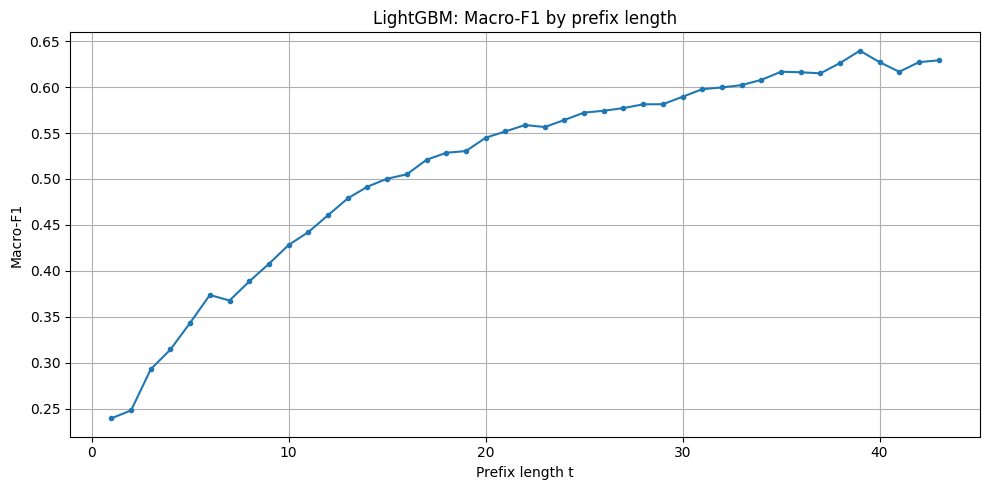

In [70]:
# -- 5.6 Macro-F1 by prefix length t --

predictions_df = prefix_test[["session_id", "t", "y_true"]].copy()
predictions_df["y_pred"] = y_pred

by_t = evaluate_by_t(predictions_df)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(by_t["t"], by_t["macro_f1"], marker="o", markersize=3)
ax.set_xlabel("Prefix length t")
ax.set_ylabel("Macro-F1")
ax.set_title("LightGBM: Macro-F1 by prefix length")
ax.grid(True)
plt.tight_layout()
plt.show()

**5.6 Result:**

Test Macro-F1: **0.5431**

| Class | Precision | Recall | F1 |
|---|---|---|---|
| Buyer | 0.3793 | 0.1709 | 0.2356 |
| Intent | 0.5947 | 0.4377 | 0.5042 |
| Researcher | 0.4863 | 0.6491 | 0.5560 |
| Browser | 0.8682 | 0.8849 | 0.8765 |

Macro-F1 grows steadily with prefix length, from ~0.24 at $t=1$ to ~0.62 at $t \geq 40$. The steepest gain occurs at $t < 10$, where the model begins to distinguish event patterns. Performance gains slow after $t \approx 30$. Buyer F1 remains the weakest class (0.24 overall), driven by low recall on purchase signals that often occur late in the session.

In [71]:
# -- 5.6 Save test predictions to local and GCS --

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

# -- local (no timestamp, always overwritten) --
_local_preds = "/content/exp2_artifacts/lgbm_test_predictions.parquet"
predictions_df.to_parquet(_local_preds, index=False)

# -- GCS (with timestamp) --
_bucket.blob(f"lgbm_test_predictions_{_ts}.parquet").upload_from_filename(_local_preds)

print(f"Saved lgbm_test_predictions.parquet locally")
print(f"Saved lgbm_test_predictions_{_ts}.parquet to gs://{GCS_BUCKET}/")
print(f"  Rows: {len(predictions_df):,}")

Saved lgbm_test_predictions.parquet locally
Saved lgbm_test_predictions_250226_1304.parquet to gs://exp2data/
  Rows: 497,852


In [72]:
# --- Intermediate cleanup: free test predictions and matrices after saving ---
to_del = ["X_test", "y_test", "y_pred", "y_pred_encoded", "y_true"]
for name in to_del:
    if name in globals():
        del globals()[name]
gc.collect()

3585

### 5.7 SHAP Analysis

We apply SHAP (SHapley Additive exPlanations) to the trained LightGBM model
to identify which features drive classification decisions. SHAP values are
computed using `TreeExplainer` on a random sample of 10,000 test prefixes
to keep computation tractable.

We report:

- Global feature importance: mean absolute SHAP values aggregated across
  samples and classes, identifying the most influential features overall
- Per-class SHAP summary: top features for each of the four session classes

In [73]:
# -- 5.7 SHAP Analysis: compute SHAP values on test sample --
# -- align prefix_test columns before sampling --
_sample = prefix_test.copy()
for col in FEATURE_COLS:
    if col not in _sample.columns:
        _sample[col] = 0

_sample = _sample.sample(n=10_000, random_state=42)
X_shap = _sample[FEATURE_COLS]

explainer = shap.TreeExplainer(lgbm_final)
shap_values_raw = explainer.shap_values(X_shap)

# -- handle 3D output (n_samples, n_features, n_classes) --
if isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    shap_values = [shap_values_raw[:, :, i] for i in range(shap_values_raw.shape[2])]
else:
    shap_values = shap_values_raw

print(f"SHAP values computed: {len(shap_values)} classes, {X_shap.shape} matrix")

SHAP values computed: 4 classes, (10000, 219) matrix


In [74]:
# -- 5.7 Global feature importance: mean absolute SHAP aggregated across classes --

shap_abs_mean = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # (n_samples, n_features)
global_importance = pd.DataFrame({
    "feature": FEATURE_COLS,
    "mean_abs_shap": shap_abs_mean.mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

print("Top 20 features by global SHAP importance:")
print(global_importance.head(20).to_string(index=False))

Top 20 features by global SHAP importance:
              feature  mean_abs_shap
      count_view_item       0.592492
    count_add_to_cart       0.519960
     freq_first_visit       0.153283
           ctx_region       0.135813
          ctx_country       0.126871
  ctx_device_language       0.125722
     time_since_start       0.124425
     freq_add_to_cart       0.098919
               avg_dt       0.096362
       freq_view_item       0.095449
           prefix_len       0.080999
      count_page_view       0.077685
    count_first_visit       0.073952
count_user_engagement       0.064022
 count_view_promotion       0.063957
    count_select_item       0.060313
        ctx_device_os       0.056916
         count_scroll       0.056040
          ctx_browser       0.046571
              entropy       0.046445


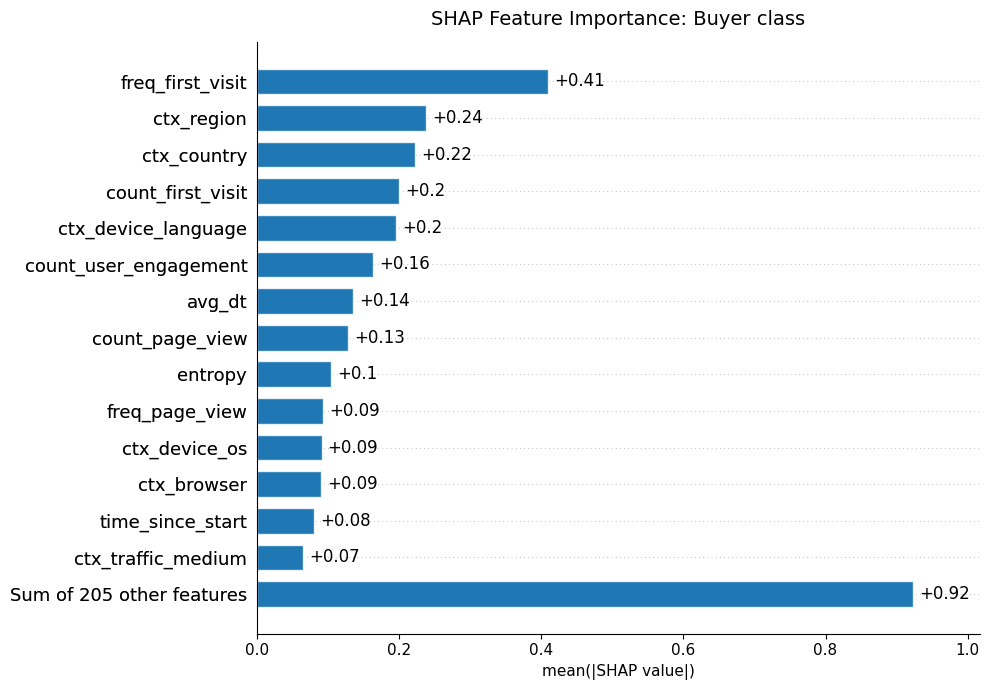

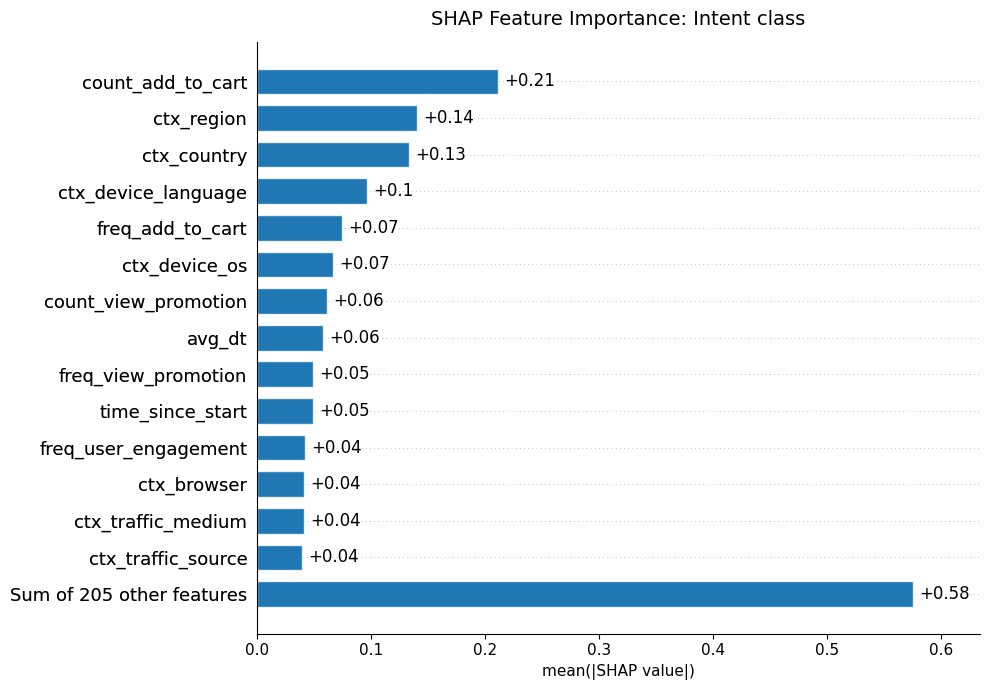

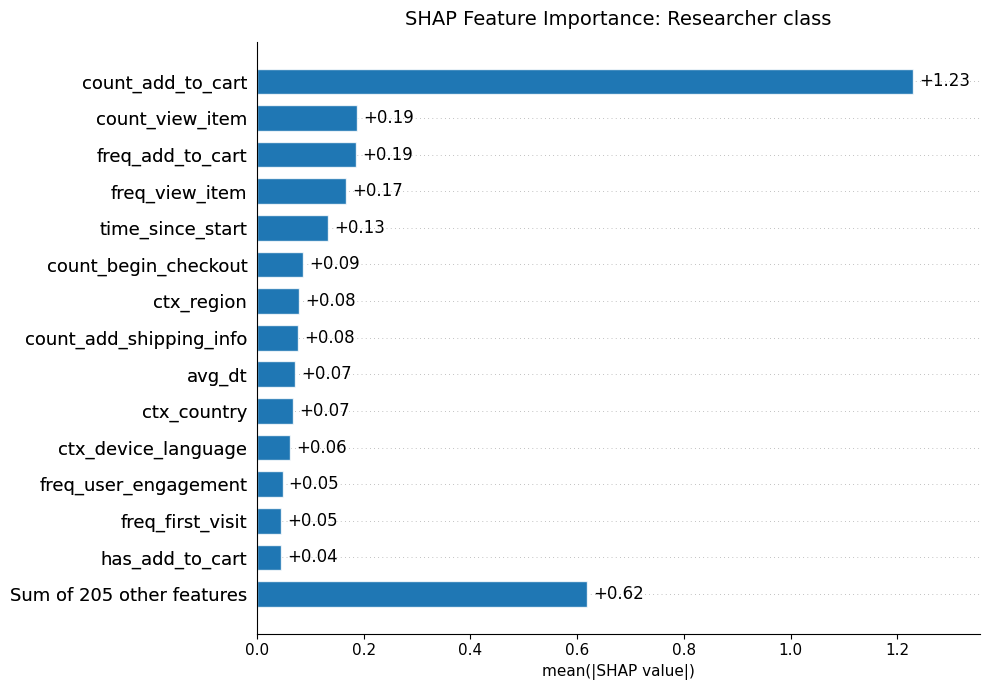

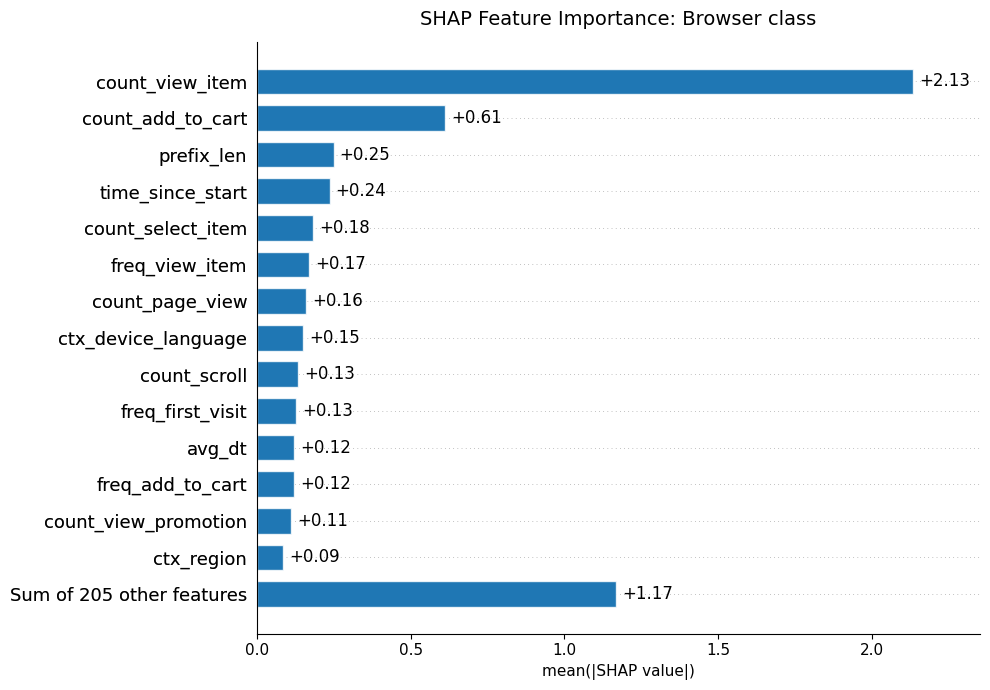

In [75]:
# -- 5.7 Per-class SHAP summary plots --

for i, label in enumerate(LABELS):
    shap_exp = shap.Explanation(
        values=shap_values[i],
        data=X_shap.values,
        feature_names=FEATURE_COLS,
    )
    fig, ax = plt.subplots(figsize=(10, 7))
    shap.plots.bar(shap_exp, max_display=15, show=False, ax=ax)
    ax.set_title(f"SHAP Feature Importance: {label} class", fontsize=14, pad=12)
    ax.set_xlabel("mean(|SHAP value|)", fontsize=11)
    for bar in ax.patches:
        bar.set_facecolor("#1f77b4")
    for text in ax.texts:
        text.set_color("black")
    plt.tight_layout()
    plt.show()

**5.7 Result:**

SHAP values were computed using `TreeExplainer` on 10,000 randomly sampled
test prefixes. Global importance confirms that product-interaction features
dominate: `count_view_item` and `count_add_to_cart` are the top drivers
overall, followed by temporal features (`time_since_start`, `avg_dt`) and
contextual features (`ctx_region`, `ctx_country`, `ctx_device_language`).

Per-class analysis reveals distinct behavioral signatures. For **Browser**,
`count_view_item` (mean |SHAP| = 1.98) dominates by a large margin, reflecting
a pure browsing pattern with high view volume and no conversion signals. For
**Researcher**, `count_add_to_cart` (1.11) is the strongest signal,
distinguishing active product exploration from passive browsing, alongside
`view_item` and `time_since_start` indicating longer, deeper sessions. For
**Intent**, `count_add_to_cart` (0.23) again leads, with geo/language context
providing secondary separation. For **Buyer**, the top feature is
`freq_first_visit` (0.44), suggesting that contextual and session-structure
features play a larger role relative to direct purchase signals at prefix
level, which helps explain the low recall observed in Section 5.6.

Contextual features (`ctx_region`, `ctx_country`, `ctx_device_language`)
appear consistently across all classes as secondary signals, confirming that
geo and device context adds predictive value beyond behavior alone.

### Section 5 Summary

Section 5 trained and evaluated a LightGBM classifier on prefix-level feature vectors, achieving **Macro-F1 = 0.5431** on the test set -- a **28.7% relative improvement** over the Markov-3 baseline (0.4221) established in Section 4.

**Feature engineering** produced 219 features per prefix across five groups:
sequence statistics (counts, frequencies, entropy), key event flags and
time-since-last-event, temporal features (avg_dt, time_since_start),
n-gram suffix indicators (bigram/trigram), and session-level context. All
encoding artifacts were fitted exclusively on the training set.

**Hyperparameter tuning** via Optuna TPE (50 trials, sequential, `TPESampler(seed=42)`) selected
`num_leaves=255`, `learning_rate=0.0749`, `n_estimators=653`, achieving
Macro-F1 = 0.5512 on the tuning holdout. The final model was trained on
all 2,362,299 train prefixes with per-prefix sample weights.

**Evaluation** shows strong Browser F1 (0.8765) and moderate Researcher F1
(0.5560), while Buyer (0.2356) and Intent (0.5042) remain weaker, consistent
with class imbalance and late purchase signals. Macro-F1 grows steadily with
prefix length, from 0.24 at $t=1$ to 0.62 at $t \geq 40$, with gains
slowing after $t \approx 30$.

**SHAP analysis** confirms that product-interaction features
(`count_view_item`, `count_add_to_cart`) are the primary drivers, with
temporal and contextual features playing a secondary role. Each class exhibits
a distinct behavioral signature consistent with the session labeling scheme.

## Section 6 — SASRec+ Ablations

Section 5 showed that LightGBM with engineered features (including time
intervals, n-grams, and static session context) reached Macro-F1 0.5431,
confirming that temporal and contextual signals carry meaningful information
for session classification. However, gradient boosting is not designed to
learn sequence representations end-to-end.

This section applies SASRec — a transformer-based sequential model — to
prefix-level session classification. We conduct an ablation study with four
configurations: base SASRec (event-token prefixes only), +Time (inter-event
intervals), +Context (static session-context embeddings: device, traffic
source, browser, platform, geo), and +Time+Context (full model). The goal is
twofold: quantify the marginal contribution of each signal type within a
neural architecture, and test whether their combination yields the best
SASRec variant.

The temporal split and evaluation procedures follow Section 3 (temporal
split, prefix-level evaluation, Macro-F1); model-specific training details
are described in Section 6.4. Prefix datasets and vocabulary from Section 1
(data pipeline and vocabulary) are reused. Absolute comparison with Markov-3
and LightGBM is reported in Section 7.

### 6.1 Model Description

SASRec (Self-Attentive Sequential Recommendation) is a transformer-based
model originally proposed for next-item prediction in recommender systems
(Kang & McAuley, 2018). It processes a sequence of item embeddings through
causal self-attention layers, where the attention mask prevents each position
from attending to future tokens. This produces a contextualised
representation at each position that captures dependencies across the
preceding sequence.

In this work, SASRec is adapted for prefix-level session classification.
Instead of predicting the next event, the model takes a prefix of event
tokens $(x_1, x_2, \ldots, x_t)$ and outputs a probability distribution
over four session classes (Buyer, Intent, Researcher, Browser). The
classification head is a linear projection from the hidden state at
position $t$ (the last real token before padding) to four class logits.
The base model includes learned positional embeddings to encode event order;
time and context signals are incorporated as additional inputs in the
ablation variants (see Section 6.2).

**Inputs:**
- Event-token indices from the vocabulary ($|V|$ = 19, including `<PAD>`
  and `<UNK>`; see Section 1)
- Sequences are right-padded to `T_MAX` = 43 (p95 of train session length,
  set in Section 1.5)

**Output:** predicted class probabilities $\hat{y} \in \mathbb{R}^4$

**Objective:** cross-entropy loss on logits with optional class weighting
to address label imbalance (details in Section 6.4)

### 6.2 Ablation Variants

The ablation study isolates the contribution of two signal types, temporal
and contextual, by training four model configurations on the same data and
evaluation protocol.

| Variant | Event tokens | Positional emb. | Time ($\Delta t$) | Session context |
|---|---|---|---|---|
| **Base** | yes | yes | no | no |
| **+Time** | yes | yes | yes | no |
| **+Context** | yes | yes | no | yes |
| **+Time+Context** | yes | yes | yes | yes |

**Time signal ($\Delta t$).** For each event $x_i$ ($i \geq 2$), the
inter-event interval $\Delta t_i = ts_i - ts_{i-1}$ (in seconds) is
computed; $\Delta t_1 = 0$ for the first event. Values are clipped at
`MAX_DT` = 585.71 s (p99 of train inter-event intervals, from Section 5.2)
and normalised to $[0, 1]$ by dividing by `MAX_DT`. The resulting scalar is
projected through a linear layer to match `hidden_dim` and added to the
event embedding at position $i$.

**Context signal.** Ten static session-level fields from
`CONTEXT_FIELDS_ALL` (defined in Section 5.2) are used: `ctx_device_category`,
`ctx_continent`, `ctx_traffic_source`, `ctx_traffic_medium`, `ctx_device_os`,
`ctx_browser`, `ctx_device_language`, `ctx_country`, `ctx_region`,
`ctx_traffic_campaign`. High-cardinality fields (`country`, `region`,
`traffic_campaign`) use top-K = 50 encoding with an `<OTHER>` bucket, fitted
on train only (see Section 5.2). Each field is passed through a learned
embedding layer; the ten resulting vectors are summed into a single context
vector $c \in \mathbb{R}^{h}$ and concatenated with the hidden state at
position $t$, producing a $2h$-dimensional input to the classification head.
This global integration approach keeps the transformer layers unchanged
across all variants.

All four variants share the same architecture hyperparameters (Section 6.5)
and training protocol (Section 6.4), differing only in the input signals
described above.

### 6.3 Data Preparation

SASRec operates on padded tensor sequences, not on flat feature vectors as
in Section 5. This subsection prepares the input data by converting
session-level lists from `sessions.parquet` into PyTorch tensors.

For each session prefix of length $t$, the following tensors are constructed:

- **Token indices:** first $t$ elements of `tokens_idx`, right-padded with
  `<PAD>` = 0 to length `T_MAX` = 43
- **Attention mask:** 1 for the first $t$ positions, 0 for padding positions
- **$\Delta t$ values (for +Time variants):** first $t$ elements of `dt`,
  clipped at `MAX_DT` = 585.71 and divided by `MAX_DT` to normalise to
  $[0, 1]$, right-padded with 0
- **Context field indices (for +Context variants):** ten integer-encoded
  fields from `CONTEXT_FIELDS_ALL`, reusing the encoding artifacts from
  Section 5.2 (top-K = 50 for high-cardinality fields, `<OTHER>` bucket,
  fitted on train only). Embedding lookup happens inside the model
- **Label:** integer class index following `LABELS` order (Buyer = 0,
  Intent = 1, Researcher = 2, Browser = 3), consistent with Section 3.2

Prefix generation is performed on the fly via a PyTorch `Dataset` that
iterates over all (session, $t$) pairs within a split. This avoids
materialising the full prefix dataset in memory (2.3M+ rows for train).
`DataLoader` handles batching; shuffling is enabled for the training
loader only.

In [76]:
# -- 6.3 Imports and constants for Section 6 --

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
CUDA available: True
GPU: NVIDIA H100 80GB HBM3


In [77]:
# -- 6.3 Load preprocessing constants for Section 6 --

with open("/content/exp2_artifacts/fe_artifacts.json") as f:
    fe_artifacts = json.load(f)

VOCAB_SIZE = len(vocab)
MAX_DT = fe_artifacts["MAX_DT"]
top_k_artifacts = {k: set(v) for k, v in fe_artifacts["top_k_artifacts"].items()}

print(f"Vocab size: {VOCAB_SIZE}")
print(f"MAX_DT: {MAX_DT}")
print(f"Top-K fields: {list(top_k_artifacts.keys())}")

Vocab size: 19
MAX_DT: 585.7067381999956
Top-K fields: ['country', 'region', 'traffic_campaign']


In [78]:
# -- 6.3 Load sessions dataset --

sessions = pd.read_parquet("/content/exp2_artifacts/sessions.parquet")
print(f"Sessions: {sessions.shape[0]:,} x {sessions.shape[1]}")
print(f"Splits: {sessions['split'].value_counts().to_dict()}")

Sessions: 360,129 x 20
Splits: {'train': 252090, 'test': 54020, 'val': 54019}


In [79]:
# -- 6.3 Context fields and label encoders for embedding lookup --

CONTEXT_FIELDS_ALL = [
    "device_category", "continent", "traffic_source", "traffic_medium",
    "device_os", "browser", "device_language",
    "country", "region", "traffic_campaign",
]

CONTEXT_FIELDS_C = ["country", "region", "traffic_campaign"]
TOP_K = 50

train_sessions = sessions[sessions["split"] == "train"]

ctx_encoders = {}
ctx_vocab_sizes = {}

for field in CONTEXT_FIELDS_ALL:
    values = train_sessions[field].fillna("MISSING").astype(str)

    if field in CONTEXT_FIELDS_C:
        allowed = top_k_artifacts[field] | {"MISSING"}
        values = values.where(values.isin(allowed), other="OTHER")

    unique_vals = sorted(values.unique())
    enc = {v: i + 1 for i, v in enumerate(unique_vals)}  # 0 reserved for unseen
    ctx_encoders[field] = enc
    ctx_vocab_sizes[field] = len(enc) + 1  # +1 for index 0 (unseen)

    print(f"{field}: {len(enc)} categories (+1 unseen = {ctx_vocab_sizes[field]})")

del train_sessions

device_category: 3 categories (+1 unseen = 4)
continent: 6 categories (+1 unseen = 7)
traffic_source: 5 categories (+1 unseen = 6)
traffic_medium: 6 categories (+1 unseen = 7)
device_os: 6 categories (+1 unseen = 7)
browser: 6 categories (+1 unseen = 7)
device_language: 10 categories (+1 unseen = 11)
country: 51 categories (+1 unseen = 52)
region: 51 categories (+1 unseen = 52)
traffic_campaign: 5 categories (+1 unseen = 6)


In [80]:
# -- 6.3 Preloaded PyTorch Dataset --

class PrefixDatasetPreloaded(Dataset):
    def __init__(self, sessions_df, token2idx, ctx_encoders,
                 max_t=T_MAX, max_dt=MAX_DT):
        unk_idx = token2idx["<UNK>"]
        label2idx = {label: i for i, label in enumerate(LABELS)}
        allowed_sets = {
            field: top_k_artifacts[field] | {"MISSING"}
            for field in CONTEXT_FIELDS_C
        }

        all_token_ids = []
        all_masks = []
        all_dt = []
        all_ctx = []
        all_labels = []
        all_t = []

        for _, row in tqdm(sessions_df.iterrows(), total=len(sessions_df), desc="  Building"):
            tokens = row["tokens"]
            dt_raw = row["dt"]

            if not isinstance(tokens, (list, np.ndarray)):
                continue
            seq_len = len(tokens)
            if seq_len == 0:
                continue

            # -- encode full sequence once per session --
            full_ids = [token2idx.get(tok, unk_idx) for tok in tokens]
            full_dt = [min(d, max_dt) / max_dt for d in dt_raw]

            # -- encode context once per session --
            ctx_indices = []
            for field in CONTEXT_FIELDS_ALL:
                val = row.get(field)
                val = str(val) if pd.notna(val) else "MISSING"
                if field in allowed_sets:
                    if val not in allowed_sets[field]:
                        val = "OTHER"
                ctx_indices.append(ctx_encoders[field].get(val, 0))

            label = label2idx[row["y"]]

            # -- generate all prefixes for this session --
            for t in range(1, min(seq_len, max_t) + 1):
                padded = full_ids[:t] + [0] * (max_t - t)
                mask = [1] * t + [0] * (max_t - t)
                dt_padded = full_dt[:t] + [0.0] * (max_t - t)

                all_token_ids.append(padded)
                all_masks.append(mask)
                all_dt.append(dt_padded)
                all_ctx.append(ctx_indices)
                all_labels.append(label)
                all_t.append(t)

        # -- convert to tensors --
        self.token_ids = torch.tensor(all_token_ids, dtype=torch.long)
        self.masks = torch.tensor(all_masks, dtype=torch.long)
        self.dt = torch.tensor(all_dt, dtype=torch.float)
        self.ctx = torch.tensor(all_ctx, dtype=torch.long)
        self.labels = torch.tensor(all_labels, dtype=torch.long)
        self.t_values = torch.tensor(all_t, dtype=torch.long)

        print(f"  Prefixes: {len(self.labels):,} | "
              f"Memory: {(self.token_ids.nbytes + self.masks.nbytes + self.dt.nbytes + self.ctx.nbytes + self.labels.nbytes) / 1e9:.2f} GB")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return {
            "token_ids": self.token_ids[i],
            "mask": self.masks[i],
            "dt": self.dt[i],
            "ctx": self.ctx[i],
            "label": self.labels[i],
            "t": self.t_values[i],
        }

In [81]:
# -- 6.3 Smoke test: PrefixDatasetPreloaded on 5 train sessions --

_smoke = sessions[sessions["split"] == "train"].head(5)
_ds = PrefixDatasetPreloaded(_smoke, token2idx, ctx_encoders)

_sample = _ds[0]
print(f"Keys: {list(_sample.keys())}")
print(f"token_ids shape: {_sample['token_ids'].shape}")
print(f"mask shape:      {_sample['mask'].shape}")
print(f"dt shape:        {_sample['dt'].shape}")
print(f"ctx shape:       {_sample['ctx'].shape}")
print(f"label:           {_sample['label']} ({LABELS[_sample['label']]})")
print(f"t:               {_sample['t']}")
print(f"mask sum == t:   {_sample['mask'].sum().item() == _sample['t'].item()}")

del _smoke, _ds, _sample

  Building: 100%|██████████| 5/5 [00:00<00:00, 6429.04it/s]

  Prefixes: 27 | Memory: 0.00 GB
Keys: ['token_ids', 'mask', 'dt', 'ctx', 'label', 't']
token_ids shape: torch.Size([43])
mask shape:      torch.Size([43])
dt shape:        torch.Size([43])
ctx shape:       torch.Size([10])
label:           3 (Browser)
t:               1
mask sum == t:   True


In [82]:
# -- 6.3 Instantiate preloaded datasets --

print("Building train dataset...")
ds_train = PrefixDatasetPreloaded(sessions[sessions["split"] == "train"], token2idx, ctx_encoders)

print("Building val dataset...")
ds_val = PrefixDatasetPreloaded(sessions[sessions["split"] == "val"], token2idx, ctx_encoders)

print("Building test dataset...")
ds_test = PrefixDatasetPreloaded(sessions[sessions["split"] == "test"], token2idx, ctx_encoders)

Building train dataset...


  Building: 100%|██████████| 252090/252090 [00:27<00:00, 9142.61it/s]


  Prefixes: 2,362,299 | Memory: 2.24 GB
Building val dataset...


  Building: 100%|██████████| 54019/54019 [00:03<00:00, 15908.48it/s]


  Prefixes: 465,782 | Memory: 0.44 GB
Building test dataset...


  Building: 100%|██████████| 54020/54020 [00:05<00:00, 9968.63it/s]


  Prefixes: 497,852 | Memory: 0.47 GB


In [83]:
# -- 6.3 DataLoaders --

BATCH_SIZE = 512

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Train batches: {len(dl_train):,}")
print(f"Val batches:   {len(dl_val):,}")
print(f"Test batches:  {len(dl_test):,}")

Train batches: 4,614
Val batches:   910
Test batches:  973


**6.3 Result:**

Three `PrefixDataset` instances were created from `sessions.parquet`,
covering all (session, $t$) prefix pairs per split:

| Split | Prefixes | Batches (512) |
|---|---|---|
| Train | 2,362,299 | 4,614 |
| Val | 465,782 | 910 |
| Test | 497,852 | 973 |

Each sample contains: `token_ids` (int, length 43), `mask` (int,
length 43), `dt` (float, length 43), `ctx` (int, length 10), `label`
(int), and prefix length `t`. Context field indices use train-only
encoders with unseen = 0; high-cardinality fields (`country`, `region`,
`traffic_campaign`) apply top-K = 50 filtering.

### 6.4 Training Protocol

All four ablation variants are trained under an identical protocol to ensure
that performance differences reflect only the input signals, not training
choices.

**Loss function:** cross-entropy on logits. Class weights are computed from
train session-level label frequencies via
`compute_class_weight("balanced", ...)`, as defined in Section 3.4, and
passed to `nn.CrossEntropyLoss(weight=...)`.

**Early stopping:** training runs for up to `MAX_EPOCHS` epochs. Val
Macro-F1 is evaluated after each epoch; training stops if no improvement
is observed for `PATIENCE` consecutive epochs. The checkpoint with the
best val Macro-F1 is retained. Specific values are listed in Section 6.5.

**Reproducibility:** each configuration is trained `N_RUNS` times with
sequential seeds starting from `SEED` = 42. The run with the median val
Macro-F1 is selected as the representative result; mean and standard
deviation across runs are also reported.

**Optimizer:** AdamW (`torch.optim.AdamW`). No learning rate scheduler
or gradient clipping is applied.

### 6.5 Hyperparameter Configuration

| Parameter | Value |
|---|---|
| `hidden_dim` | 64 |
| `num_heads` | 2 |
| `num_layers` | 2 |
| `dropout` | 0.2 |
| `learning_rate` | 1e-3 |
| `weight_decay` | 1e-4 |
| `batch_size` | 512 |
| `max_epochs` | 30 |
| `patience` | 5 |
| `n_runs` | 5 |
| `max_seq_len` (`T_MAX`) | 43 |
| `ctx_emb_dim` | 8 |

Each of the ten context fields is embedded into $\mathbb{R}^{8}$
(`ctx_emb_dim`). The ten vectors are summed and projected to `hidden_dim`
via a linear layer, then concatenated with the last hidden state, giving
a $2 \times 64 = 128$-dimensional input to the classification head. The
time signal path uses a separate linear projection ($1 \to$ `hidden_dim`)
with no additional hyperparameters.

### 6.6 Training & Evaluation

This subsection implements the SASRec architecture, trains all four ablation
variants under the protocol defined in Section 6.4, and evaluates each on
val and test. The best configuration is selected by val Macro-F1; test
metrics are reported only for final comparison.

In [84]:
# -- 6.6 SASRec model --

class SASRec(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_heads, num_layers,
                 max_seq_len, num_classes=4, dropout=0.2,
                 use_time=False, use_context=False,
                 ctx_vocab_sizes=None, ctx_emb_dim=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.use_time = use_time
        self.use_context = use_context

        # -- event token + positional embeddings --
        self.token_emb = nn.Embedding(vocab_size, hidden_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_seq_len, hidden_dim)

        # -- time projection (1 -> hidden_dim), added to event embedding --
        if use_time:
            self.time_proj = nn.Linear(1, hidden_dim)

        # -- context embeddings: per-field embedding + sum + project --
        if use_context:
            self.ctx_embeddings = nn.ModuleList([
                nn.Embedding(ctx_vocab_sizes[field], ctx_emb_dim)
                for field in CONTEXT_FIELDS_ALL
            ])
            self.ctx_proj = nn.Linear(ctx_emb_dim, hidden_dim)

        # -- transformer encoder --
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # -- classification head: 2*hidden_dim if context, else hidden_dim --
        head_dim = hidden_dim * 2 if use_context else hidden_dim
        self.classifier = nn.Linear(head_dim, num_classes)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, token_ids, mask, dt=None, ctx=None):
        B, L = token_ids.shape

        # -- embeddings: token + position --
        positions = torch.arange(L, device=token_ids.device).unsqueeze(0)
        x = self.token_emb(token_ids) + self.pos_emb(positions)

        # -- add time signal --
        if self.use_time and dt is not None:
            t_emb = self.time_proj(dt.unsqueeze(-1))
            x = x + t_emb

        x = self.layer_norm(x)
        x = self.dropout(x)

        # -- causal mask: True = ignore (upper triangle) --
        causal_mask = torch.triu(
            torch.ones(L, L, device=x.device, dtype=torch.bool), diagonal=1
        )

        # -- padding mask: True = ignore --
        pad_mask = (mask == 0)

        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=pad_mask)

        # -- extract hidden state at last real token per sample --
        lengths = mask.sum(dim=1) - 1
        h = x[torch.arange(B, device=x.device), lengths]

        # -- concatenate context if used --
        if self.use_context and ctx is not None:
            ctx_parts = [emb(ctx[:, i]) for i, emb in enumerate(self.ctx_embeddings)]
            c = torch.stack(ctx_parts, dim=0).sum(dim=0)
            c = self.ctx_proj(c)
            h = torch.cat([h, c], dim=-1)

        logits = self.classifier(h)
        return logits

In [85]:
# -- 6.6 Smoke test: forward pass for all 4 ablation variants --

_batch = next(iter(dl_train))

for _use_time, _use_ctx, _name in [
    (False, False, "Base"),
    (True,  False, "+Time"),
    (False, True,  "+Context"),
    (True,  True,  "+Time+Context"),
]:
    _model = SASRec(
        vocab_size=VOCAB_SIZE, hidden_dim=64, num_heads=2, num_layers=2,
        max_seq_len=T_MAX, dropout=0.2,
        use_time=_use_time, use_context=_use_ctx,
        ctx_vocab_sizes=ctx_vocab_sizes, ctx_emb_dim=8,
    ).to(DEVICE)

    _logits = _model(
        token_ids=_batch["token_ids"].to(DEVICE),
        mask=_batch["mask"].to(DEVICE),
        dt=_batch["dt"].to(DEVICE) if _use_time else None,
        ctx=_batch["ctx"].to(DEVICE) if _use_ctx else None,
    )
    print(f"{_name:16s} -> logits {_logits.shape}, "
          f"params {sum(p.numel() for p in _model.parameters()):,}")

del _batch, _model, _logits

Base             -> logits torch.Size([512, 4]), params 104,324
+Time            -> logits torch.Size([512, 4]), params 104,452
+Context         -> logits torch.Size([512, 4]), params 106,428
+Time+Context    -> logits torch.Size([512, 4]), params 106,556


In [86]:
# -- 6.6 Class weights for CrossEntropyLoss --

train_labels = sessions[sessions["split"] == "train"]["y"].values
cw = compute_class_weight("balanced", classes=np.array(LABELS), y=train_labels)
class_weights = torch.tensor(cw, dtype=torch.float).to(DEVICE)

for label, w in zip(LABELS, class_weights):
    print(f"{label:12s}: {w:.4f}")

del train_labels

Buyer       : 16.6462
Intent      : 5.3875
Researcher  : 4.3285
Browser     : 0.2838


In [87]:
# -- 6.6 Training and evaluation functions --

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    n_samples = 0

    for batch in loader:
        token_ids = batch["token_ids"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        dt = batch["dt"].to(DEVICE)
        ctx = batch["ctx"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = model(token_ids, mask, dt=dt, ctx=ctx)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        n_samples += labels.size(0)

    return total_loss / n_samples


def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_t = []

    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["token_ids"].to(DEVICE),
                batch["mask"].to(DEVICE),
                dt=batch["dt"].to(DEVICE),
                ctx=batch["ctx"].to(DEVICE),
            )
            all_preds.append(logits.argmax(dim=-1).cpu())
            all_labels.append(batch["label"])
            all_t.append(batch["t"])

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_t = torch.cat(all_t).numpy()

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    return macro_f1, all_preds, all_labels, all_t

In [88]:
# -- 6.6 Smoke test: train + eval on 2 batches --

_model = SASRec(
    vocab_size=VOCAB_SIZE, hidden_dim=64, num_heads=2, num_layers=2,
    max_seq_len=T_MAX, dropout=0.2,
    use_time=True, use_context=True,
    ctx_vocab_sizes=ctx_vocab_sizes, ctx_emb_dim=8,
).to(DEVICE)

_criterion = nn.CrossEntropyLoss(weight=class_weights)
_optimizer = torch.optim.AdamW(_model.parameters(), lr=1e-3, weight_decay=1e-4)

# -- mini train: 2 batches --
_mini_loader = DataLoader(ds_train, batch_size=512, shuffle=True)
_model.train()
for _i, _batch in enumerate(_mini_loader):
    if _i >= 2:
        break
    _logits = _model(
        _batch["token_ids"].to(DEVICE), _batch["mask"].to(DEVICE),
        dt=_batch["dt"].to(DEVICE), ctx=_batch["ctx"].to(DEVICE),
    )
    _loss = _criterion(_logits, _batch["label"].to(DEVICE))
    _optimizer.zero_grad()
    _loss.backward()
    _optimizer.step()
    print(f"Batch {_i}: loss={_loss.item():.4f}")

# -- mini eval: 2 batches --
_mini_val = DataLoader(ds_val, batch_size=512, shuffle=False)
_model.eval()
_preds, _labels = [], []
with torch.no_grad():
    for _i, _batch in enumerate(_mini_val):
        if _i >= 2:
            break
        _logits = _model(
            _batch["token_ids"].to(DEVICE), _batch["mask"].to(DEVICE),
            dt=_batch["dt"].to(DEVICE), ctx=_batch["ctx"].to(DEVICE),
        )
        _preds.append(_logits.argmax(-1).cpu())
        _labels.append(_batch["label"])

_f1 = f1_score(torch.cat(_labels).numpy(), torch.cat(_preds).numpy(), average="macro")
print(f"Mini-val Macro-F1 (2 batches): {_f1:.4f}")

del _model, _criterion, _optimizer, _mini_loader, _mini_val
del _preds, _labels, _logits, _loss, _batch, _f1

Batch 0: loss=1.5020
Batch 1: loss=1.3653
Mini-val Macro-F1 (2 batches): 0.0894


In [89]:
# -- 6.3 Save context encoding artifacts --

_ctx_artifacts = {
    "ctx_encoders": ctx_encoders,
    "ctx_vocab_sizes": ctx_vocab_sizes,
}

_ts = datetime.now().strftime("%d%m%y_%H%M")

# -- local --
with open("/content/exp2_artifacts/ctx_artifacts.json", "w") as f:
    json.dump(_ctx_artifacts, f, indent=2)

# -- GCS --
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)
_blob = _bucket.blob(f"ctx_artifacts_{_ts}.json")
_blob.upload_from_filename("/content/exp2_artifacts/ctx_artifacts.json")

print(f"Saved ctx_artifacts.json locally and to GCS (ts={_ts})")

del _ctx_artifacts, _gcs_client, _bucket, _blob, _ts

Saved ctx_artifacts.json locally and to GCS (ts=250226_1310)


In [90]:
# -- 6.6 Lightweight val evaluation (F1 only, no preds stored) --

def eval_val_f1(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["token_ids"].to(DEVICE),
                batch["mask"].to(DEVICE),
                dt=batch["dt"].to(DEVICE),
                ctx=batch["ctx"].to(DEVICE),
            )
            all_preds.append(logits.argmax(dim=-1).cpu())
            all_labels.append(batch["label"])

    return f1_score(
        torch.cat(all_labels).numpy(),
        torch.cat(all_preds).numpy(),
        average="macro",
    )

In [91]:
# -- TEMPORARY: benchmark 1 epoch Base variant --

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

_model = SASRec(
    vocab_size=VOCAB_SIZE, hidden_dim=64,
    num_heads=2, num_layers=2,
    max_seq_len=T_MAX, dropout=0.2,
    use_time=False, use_context=False,
    ctx_vocab_sizes=ctx_vocab_sizes, ctx_emb_dim=8,
).to(DEVICE)

_criterion = nn.CrossEntropyLoss(weight=class_weights)
_optimizer = torch.optim.AdamW(_model.parameters(), lr=1e-3, weight_decay=1e-4)

t0 = time.time()
_loss = train_one_epoch(_model, dl_train, _optimizer, _criterion)
t1 = time.time()
_val_f1 = eval_val_f1(_model, dl_val)
t2 = time.time()

print(f"Train: {t1-t0:.0f}s | Val: {t2-t1:.0f}s | Total: {t2-t0:.0f}s")
print(f"Loss: {_loss:.4f} | Val F1: {_val_f1:.4f}")

del _model, _criterion, _optimizer, _loss, _val_f1
gc.collect()
torch.cuda.empty_cache()

Train: 50s | Val: 6s | Total: 56s
Loss: 0.9784 | Val F1: 0.4197


In [92]:
# -- 6.6 Training loop with early stopping and multi-run --

HIDDEN_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 1e-3
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 30
PATIENCE = 5
N_RUNS = 5

ABLATIONS = [
    {"name": "Base",         "use_time": False, "use_context": False},
    {"name": "+Time",        "use_time": True,  "use_context": False},
    {"name": "+Context",     "use_time": False, "use_context": True},
    {"name": "+Time+Context","use_time": True,  "use_context": True},
]

results = {}

for abl in ABLATIONS:
    print(f"\n{'='*60}")
    print(f"Ablation: {abl['name']}")
    print(f"{'='*60}")

    run_metrics = []

    for run in range(N_RUNS):
        run_seed = SEED + run
        random.seed(run_seed)
        np.random.seed(run_seed)
        torch.manual_seed(run_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(run_seed)

        model = SASRec(
            vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM,
            num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
            max_seq_len=T_MAX, dropout=DROPOUT,
            use_time=abl["use_time"], use_context=abl["use_context"],
            ctx_vocab_sizes=ctx_vocab_sizes, ctx_emb_dim=8,
        ).to(DEVICE)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

        best_val_f1 = -1.0
        best_state = None
        patience_counter = 0

        for epoch in range(MAX_EPOCHS):
            t0 = time.time()
            train_loss = train_one_epoch(model, dl_train, optimizer, criterion)
            val_f1 = eval_val_f1(model, dl_val)
            elapsed = time.time() - t0

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                marker = " *"
            else:
                patience_counter += 1
                marker = ""

            print(f"  Run {run+1}/{N_RUNS} | Epoch {epoch+1:2d} | "
                  f"loss={train_loss:.4f} | val_f1={val_f1:.4f}{marker} | "
                  f"{elapsed:.0f}s")

            if patience_counter >= PATIENCE:
                print(f"  Early stop at epoch {epoch+1}")
                break

        run_metrics.append({"run": run, "seed": run_seed,
                            "best_val_f1": best_val_f1,
                            "best_state": best_state})
        del model, criterion, optimizer
        gc.collect()
        torch.cuda.empty_cache()

    # -- select median run --
    run_metrics.sort(key=lambda x: x["best_val_f1"])
    median_idx = len(run_metrics) // 2
    selected = run_metrics[median_idx]

    val_scores = [r["best_val_f1"] for r in run_metrics]
    print(f"\n  Val F1 across runs: {[f'{v:.4f}' for v in val_scores]}")
    print(f"  Mean={np.mean(val_scores):.4f} | Std={np.std(val_scores):.4f}")
    print(f"  Selected run {selected['run']+1} (median): val_f1={selected['best_val_f1']:.4f}")

    results[abl["name"]] = {
        "val_scores": val_scores,
        "mean_val_f1": float(np.mean(val_scores)),
        "std_val_f1": float(np.std(val_scores)),
        "selected_val_f1": selected["best_val_f1"],
        "best_state": selected["best_state"],
        "config": abl,
    }

    # -- save checkpoint after each ablation --
    _abl_tag = abl["name"].replace("+", "plus").replace(" ", "").lower()
    _ts = datetime.now().strftime("%d%m%y_%H%M")

    _ckpt = {
        "state_dict": selected["best_state"],
        "val_scores": val_scores,
        "selected_val_f1": selected["best_val_f1"],
        "config": abl,
    }
    _local_path = f"/content/exp2_artifacts/sasrec_{_abl_tag}.pt"
    torch.save(_ckpt, _local_path)

    _gcs_client = storage.Client(project=PROJECT_ID)
    _bucket = _gcs_client.bucket(GCS_BUCKET)
    _blob = _bucket.blob(f"sasrec_{_abl_tag}_{_ts}.pt")
    _blob.upload_from_filename(_local_path)
    print(f"  Saved {_local_path} -> GCS (ts={_ts})")

    # -- free non-selected states --
    for r in run_metrics:
        if r is not selected:
            del r["best_state"]
    del _ckpt, _gcs_client, _bucket, _blob, run_metrics
    gc.collect()
    torch.cuda.empty_cache()


Ablation: Base
  Run 1/5 | Epoch  1 | loss=0.9784 | val_f1=0.4197 * | 59s
  Run 1/5 | Epoch  2 | loss=0.9588 | val_f1=0.3866 | 59s
  Run 1/5 | Epoch  3 | loss=0.9537 | val_f1=0.4124 | 59s
  Run 1/5 | Epoch  4 | loss=0.9501 | val_f1=0.4162 | 60s
  Run 1/5 | Epoch  5 | loss=0.9470 | val_f1=0.4427 * | 59s
  Run 1/5 | Epoch  6 | loss=0.9444 | val_f1=0.4296 | 57s
  Run 1/5 | Epoch  7 | loss=0.9426 | val_f1=0.4266 | 55s
  Run 1/5 | Epoch  8 | loss=0.9399 | val_f1=0.4385 | 57s
  Run 1/5 | Epoch  9 | loss=0.9383 | val_f1=0.4328 | 58s
  Run 1/5 | Epoch 10 | loss=0.9371 | val_f1=0.4401 | 56s
  Early stop at epoch 10
  Run 2/5 | Epoch  1 | loss=0.9804 | val_f1=0.3471 * | 56s
  Run 2/5 | Epoch  2 | loss=0.9595 | val_f1=0.3845 * | 57s
  Run 2/5 | Epoch  3 | loss=0.9540 | val_f1=0.3637 | 54s
  Run 2/5 | Epoch  4 | loss=0.9500 | val_f1=0.3952 * | 55s
  Run 2/5 | Epoch  5 | loss=0.9466 | val_f1=0.4277 * | 56s
  Run 2/5 | Epoch  6 | loss=0.9440 | val_f1=0.4193 | 56s
  Run 2/5 | Epoch  7 | loss=0.9415 

### 6.7 Results & Ablation Comparison

We evaluate the selected (median) model from each ablation variant on the
test set and compare per-class metrics. The best variant is identified by
val Macro-F1; test metrics are reported for final comparison only. Absolute
comparison with Markov-3 and LightGBM is deferred to Section 7.

In [93]:
# -- 6.7 Test evaluation for all ablation variants --

ablation_test_results = {}

for name, r in results.items():
    model = SASRec(
        vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM,
        num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
        max_seq_len=T_MAX, dropout=DROPOUT,
        use_time=r["config"]["use_time"],
        use_context=r["config"]["use_context"],
        ctx_vocab_sizes=ctx_vocab_sizes, ctx_emb_dim=8,
    ).to(DEVICE)
    model.load_state_dict(r["best_state"])

    macro_f1, y_pred, y_true, t_vals = eval_model(model, dl_test)

    report = classification_report(
        y_true, y_pred,
        target_names=LABELS,
        output_dict=True,
        zero_division=0,
    )

    ablation_test_results[name] = {
        "macro_f1": macro_f1,
        "report": report,
        "y_pred": y_pred,
        "y_true": y_true,
        "t_vals": t_vals,
    }

    print(f"\n{'='*40}")
    print(f"{name} | Test Macro-F1: {macro_f1:.4f}")
    print(f"{'='*40}")
    print(classification_report(y_true, y_pred, target_names=LABELS, digits=4, zero_division=0))

    del model
    gc.collect()
    torch.cuda.empty_cache()


Base | Test Macro-F1: 0.4570
              precision    recall  f1-score   support

       Buyer     0.1313    0.5090    0.2087     28550
      Intent     0.7277    0.3359    0.4597     62761
  Researcher     0.3409    0.6607    0.4497     77448
     Browser     0.9165    0.5794    0.7100    329093

    accuracy                         0.5573    497852
   macro avg     0.5291    0.5213    0.4570    497852
weighted avg     0.7581    0.5573    0.6092    497852


+Time | Test Macro-F1: 0.4570
              precision    recall  f1-score   support

       Buyer     0.1514    0.5110    0.2336     28550
      Intent     0.6859    0.3042    0.4215     62761
  Researcher     0.3371    0.7029    0.4556     77448
     Browser     0.9151    0.5899    0.7174    329093

    accuracy                         0.5669    497852
   macro avg     0.5224    0.5270    0.4570    497852
weighted avg     0.7525    0.5669    0.6116    497852


+Context | Test Macro-F1: 0.4369
              precision    recall  

In [ ]:
# -- 6.7 Ablation comparison table --

print(f"{'Variant':<18} {'Val F1 (median)':>15} {'Val F1 (mean±std)':>20} {'Test Macro-F1':>15}")
print("-" * 72)

for name in ["Base", "+Time", "+Context", "+Time+Context"]:
    r = results[name]
    t = ablation_test_results[name]
    print(f"{name:<18} {r['selected_val_f1']:>15.4f} "
          f"{r['mean_val_f1']:>11.4f}±{r['std_val_f1']:.4f} "
          f"{t['macro_f1']:>15.4f}")

# -- identify best variant by val --
best_name = max(results, key=lambda k: results[k]["selected_val_f1"])
best_val = results[best_name]["selected_val_f1"]
best_test = ablation_test_results[best_name]["macro_f1"]
print(f"\nBest variant (by val): {best_name} "
      f"(Val={best_val:.4f}, Test={best_test:.4f})")

In [105]:
# -- 6.7 Per-class F1 comparison across ablations --

print(f"{'Variant':<18}", end="")
for label in LABELS:
    print(f" {label:>12}", end="")
print()
print("-" * 70)

for name in ["Base", "+Time", "+Context", "+Time+Context"]:
    r = ablation_test_results[name]["report"]
    print(f"{name:<18}", end="")
    for label in LABELS:
        print(f" {r[label]['f1-score']:>12.4f}", end="")
    print()

Variant                   Buyer       Intent   Researcher      Browser
----------------------------------------------------------------------
Base                     0.2087       0.4597       0.4497       0.7100
+Time                    0.2336       0.4215       0.4556       0.7174
+Context                 0.2306       0.3959       0.4219       0.6993
+Time+Context            0.2244       0.4107       0.4325       0.7035


In [106]:
# -- 6.7 Save ablation summary --

_summary = {}
for name, r in results.items():
    _test = ablation_test_results[name]
    _summary[name] = {
        "val_scores": r["val_scores"],
        "mean_val_f1": r["mean_val_f1"],
        "std_val_f1": r["std_val_f1"],
        "selected_val_f1": r["selected_val_f1"],
        "config": r["config"],
        "test_macro_f1": _test["macro_f1"],
        "test_report": _test["report"],
    }

_ts = datetime.now().strftime("%d%m%y_%H%M")

# -- local --
with open("/content/exp2_artifacts/sasrec_ablation_summary.json", "w") as f:
    json.dump(_summary, f, indent=2)

# -- GCS --
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)
_bucket.blob(f"sasrec_ablation_summary_{_ts}.json").upload_from_filename(
    "/content/exp2_artifacts/sasrec_ablation_summary.json")
print(f"Saved sasrec_ablation_summary.json -> GCS (ts={_ts})")

del _summary, _test, _gcs_client, _bucket, _ts

Saved sasrec_ablation_summary.json -> GCS (ts=250226_1715)


In [97]:
# -- 6.7 Save SASRec Base test predictions to local and GCS --

_best = ablation_test_results["Base"]

# -- reconstruct session_id from iteration order (matches PrefixDatasetPreloaded) --
_test_sessions = sessions[sessions["split"] == "test"]
_session_ids = []
for _, row in _test_sessions.iterrows():
    seq_len = len(row["tokens"])
    n_prefixes = min(seq_len, T_MAX)
    _session_ids.extend([row["session_id"]] * n_prefixes)

assert len(_session_ids) == len(_best["y_pred"]), \
    f"session_id count {len(_session_ids)} != predictions count {len(_best['y_pred'])}"

_preds_df = pd.DataFrame({
    "session_id": _session_ids,
    "t": _best["t_vals"],
    "y_true": _best["y_true"],
    "y_pred": _best["y_pred"],
})

_ts = datetime.now().strftime("%d%m%y_%H%M")
_gcs_client = storage.Client(project=PROJECT_ID)
_bucket = _gcs_client.bucket(GCS_BUCKET)

_preds_df.to_parquet(
    "/content/exp2_artifacts/sasrec_base_test_predictions.parquet", index=False)
_bucket.blob(f"sasrec_base_test_predictions_{_ts}.parquet").upload_from_filename(
    "/content/exp2_artifacts/sasrec_base_test_predictions.parquet")

print(f"Saved to /content/exp2_artifacts/ and gs://{GCS_BUCKET}/:")
print(f"  sasrec_base_test_predictions.parquet — {len(_preds_df):,} rows")

del _best, _test_sessions, _session_ids, _preds_df, _ts, _gcs_client, _bucket

Saved to /content/exp2_artifacts/ and gs://exp2data/:
  sasrec_base_test_predictions.parquet — 497,852 rows


**6.7 Result:**

| Variant | Val F1 (median) | Val F1 (mean±std) | Test Macro-F1 |
|---|---|---|---|
| Base | 0.4502 | 0.4494±0.0045 | 0.4570 |
| +Time | 0.4494 | 0.4484±0.0063 | 0.4570 |
| +Context | 0.4299 | 0.4328±0.0070 | 0.4369 |
| +Time+Context | 0.4347 | 0.4310±0.0095 | 0.4428 |

Best variant (by val): **Base** (Val F1 = 0.4502, Test Macro-F1 = 0.4570).

Per-class F1 on test (median-run checkpoint):

| Variant | Buyer | Intent | Researcher | Browser |
|---|---|---|---|---|
| Base | 0.2087 | 0.4597 | 0.4497 | 0.7100 |
| +Time | 0.2336 | 0.4215 | 0.4556 | 0.7174 |
| +Context | 0.2306 | 0.3959 | 0.4219 | 0.6993 |
| +Time+Context | 0.2244 | 0.4107 | 0.4325 | 0.7035 |

Neither temporal nor contextual enrichment improves upon the base SASRec
variant. Adding context increases training instability (higher std, earlier
stopping) and lowers overall performance. The time signal is neutral at the
aggregate level, though it slightly improves Buyer F1 (+0.025) at the cost
of Intent F1 (-0.038). Absolute comparison with Markov-3 and LightGBM is
reported in Section 7.

### 6.8 Prefix-Length Analysis

We analyse how classification quality changes with prefix length $t$ for
the best SASRec variant (selected in Section 6.7). This mirrors the
prefix-level evaluation in Sections 4 and 5, enabling direct comparison
in Section 7. The focus is on early prefixes ($t \leq 10$), where key
purchase events typically have not yet occurred and classification relies
on indirect signals.

In [98]:
# -- 6.8 Macro-F1 by prefix length for best variant --

best_res = ablation_test_results[best_name]
y_true = best_res["y_true"]
y_pred = best_res["y_pred"]
t_values = best_res["t_vals"]

unique_t = sorted(set(t_values))
f1_by_t = []

for t in unique_t:
    mask = t_values == t
    if mask.sum() < 10:
        continue
    f1 = f1_score(y_true[mask], y_pred[mask], average="macro", zero_division=0)
    f1_by_t.append({"t": t, "macro_f1": f1, "n_samples": int(mask.sum())})

f1_by_t_df = pd.DataFrame(f1_by_t)
print(f"Best variant: {best_name}")
print(f"Prefix lengths: {len(f1_by_t_df)} (t=1..{f1_by_t_df['t'].max()})")
print(f"\nEarly prefixes (t <= 10):")
print(f1_by_t_df[f1_by_t_df["t"] <= 10].to_string(index=False))

Best variant: Base
Prefix lengths: 43 (t=1..43)

Early prefixes (t <= 10):
 t  macro_f1  n_samples
 1  0.220065      54020
 2  0.231558      53751
 3  0.259605      50152
 4  0.274911      47400
 5  0.306931      41926
 6  0.299732      29118
 7  0.199975      19148
 8  0.287479      16751
 9  0.279685      14780
10  0.285574      12835


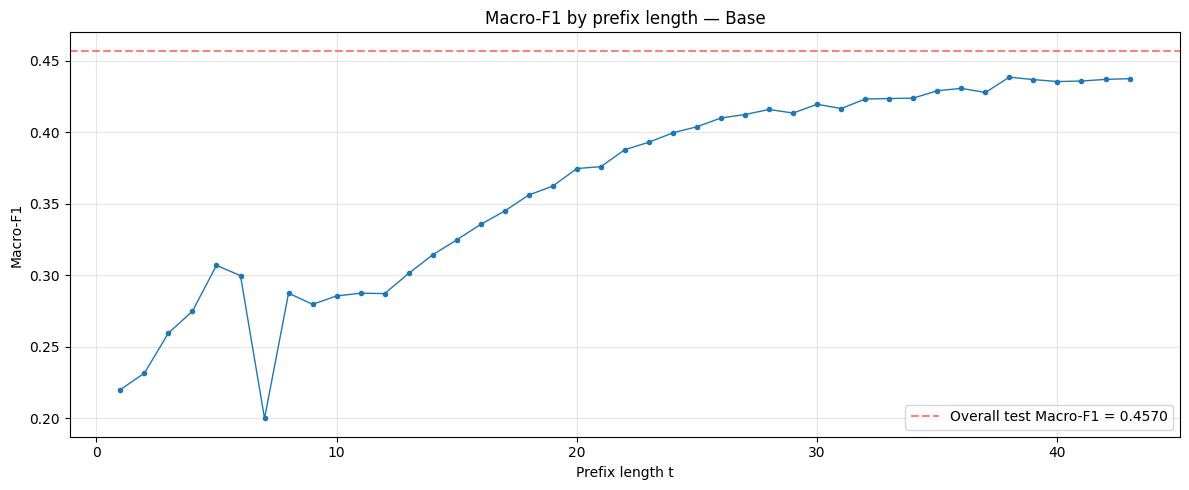

In [99]:
# -- 6.8 Macro-F1 by prefix length plot --

plt.figure(figsize=(12, 5))
plt.plot(f1_by_t_df["t"], f1_by_t_df["macro_f1"], marker=".", linewidth=1)
plt.axhline(y=best_res["macro_f1"], color="r", linestyle="--", alpha=0.5,
            label=f"Overall test Macro-F1 = {best_res['macro_f1']:.4f}")
plt.xlabel("Prefix length t")
plt.ylabel("Macro-F1")
plt.title(f"Macro-F1 by prefix length — {best_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

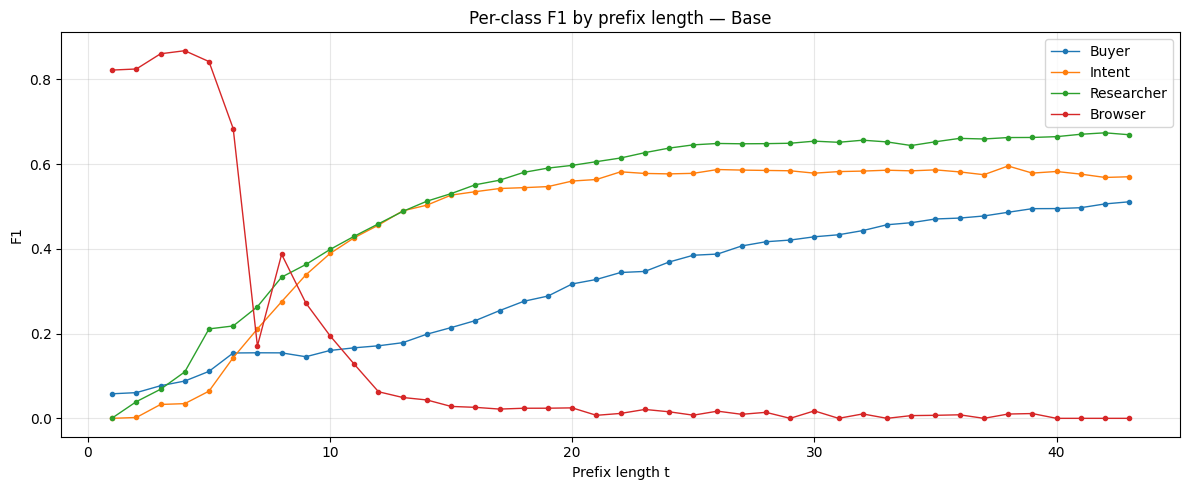

In [100]:
# -- 6.8 Per-class F1 by prefix length --

per_class_by_t = []

for t in unique_t:
    mask = t_values == t
    if mask.sum() < 10:
        continue
    f1_per_class = f1_score(y_true[mask], y_pred[mask],
                            average=None, labels=range(4), zero_division=0)
    row = {"t": t}
    for i, label in enumerate(LABELS):
        row[label] = f1_per_class[i]
    per_class_by_t.append(row)

pc_df = pd.DataFrame(per_class_by_t)

plt.figure(figsize=(12, 5))
for label in LABELS:
    plt.plot(pc_df["t"], pc_df[label], marker=".", linewidth=1, label=label)
plt.xlabel("Prefix length t")
plt.ylabel("F1")
plt.title(f"Per-class F1 by prefix length — {best_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [101]:
# -- 6.8 TEMPORARY: support per class by prefix length --

for t_range, label in [("t <= 5", t_values <= 5),
                        ("t 6-10", (t_values >= 6) & (t_values <= 10)),
                        ("t 11-20", (t_values >= 11) & (t_values <= 20)),
                        ("t 21-30", (t_values >= 21) & (t_values <= 30)),
                        ("t 31-43", t_values >= 31)]:
    subset = y_true[label]
    total = len(subset)
    if total == 0:
        continue
    print(f"\n{t_range} (n={total:,}):")
    for i, cls in enumerate(LABELS):
        n = (subset == i).sum()
        print(f"  {cls:12s}: {n:>7,} ({100*n/total:.1f}%)")


t <= 5 (n=247,249):
  Buyer       :   3,435 (1.4%)
  Intent      :   9,871 (4.0%)
  Researcher  :  14,877 (6.0%)
  Browser     : 219,066 (88.6%)

t 6-10 (n=92,632):
  Buyer       :   3,435 (3.7%)
  Intent      :   9,693 (10.5%)
  Researcher  :  14,568 (15.7%)
  Browser     :  64,936 (70.1%)

t 11-20 (n=80,762):
  Buyer       :   6,870 (8.5%)
  Intent      :  17,050 (21.1%)
  Researcher  :  23,037 (28.5%)
  Browser     :  33,805 (41.9%)

t 21-30 (n=42,678):
  Buyer       :   6,754 (15.8%)
  Intent      :  13,411 (31.4%)
  Researcher  :  14,338 (33.6%)
  Browser     :   8,175 (19.2%)

t 31-43 (n=34,531):
  Buyer       :   8,056 (23.3%)
  Intent      :  12,736 (36.9%)
  Researcher  :  10,628 (30.8%)
  Browser     :   3,111 (9.0%)


**6.8 Result:**

Macro-F1 increases overall from 0.22 (t=1) to ~0.44 (t=43), with a
localised dip at t=7. Early prefixes (t ≤ 10) remain below 0.31.

Per-class dynamics reveal a label-support shift across prefix lengths.
At short prefixes Browser dominates the test set (88.6% of prefixes at
t ≤ 5) and the model defaults to the majority class (Browser F1 ~0.83),
leaving Buyer and Intent near zero. As t increases, the class distribution
rebalances: longer prefixes disproportionately belong to non-Browser
sessions (Browser drops to 9.0% at t ≥ 31), since short sessions are
overwhelmingly Browser-class. Consequently, Browser F1 falls while
Buyer, Intent, and Researcher F1 rise as discriminative events accumulate.

This pattern is driven by two factors: (1) the natural correlation between
session length and session class, and (2) the progressive appearance of
key intent events. It is consistent with the LightGBM results in Section 5
and confirms that early classification quality is constrained by the
absence of discriminative signals in short prefixes, for both LightGBM
and the SASRec baseline.

### 6.9 Error Analysis

We examine the confusion matrix of the best SASRec variant (Base) on the
test set to identify systematic misclassification patterns. The analysis
focuses on which classes are most frequently confused and whether errors
concentrate at specific prefix lengths.

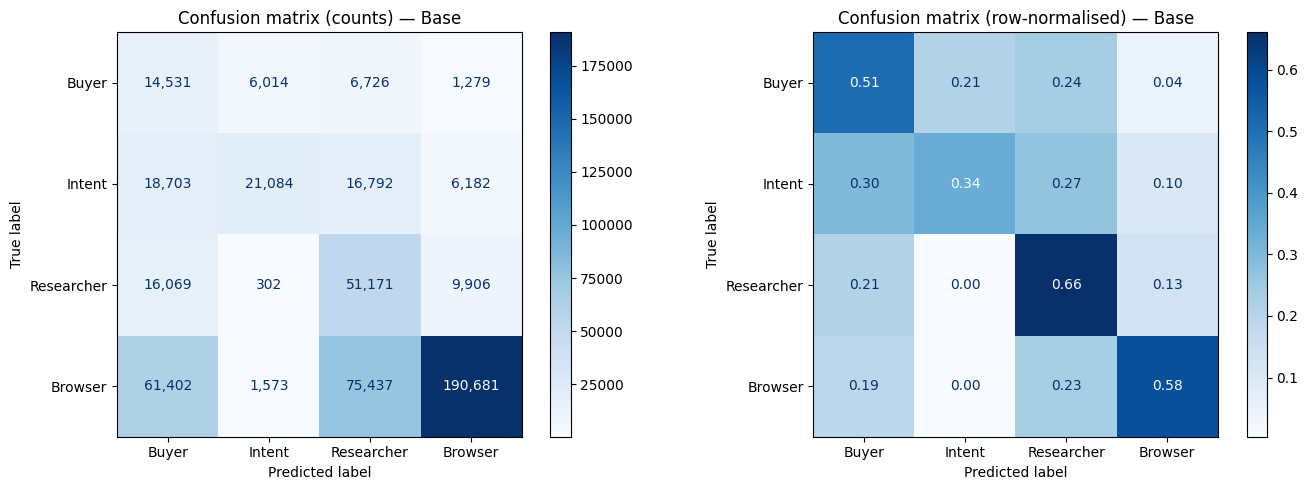

In [102]:
# -- 6.9 Confusion matrix --

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_res = ablation_test_results[best_name]
y_true = best_res["y_true"]
y_pred = best_res["y_pred"]

cm = confusion_matrix(y_true, y_pred, labels=range(4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -- absolute counts --
ConfusionMatrixDisplay(cm, display_labels=LABELS).plot(
    ax=axes[0], cmap="Blues", values_format=",")
axes[0].set_title(f"Confusion matrix (counts) — {best_name}")

# -- row-normalised (recall per class) --
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm_norm, display_labels=LABELS).plot(
    ax=axes[1], cmap="Blues", values_format=".2f")
axes[1].set_title(f"Confusion matrix (row-normalised) — {best_name}")

plt.tight_layout()
plt.show()

In [103]:
# -- 6.9 Top misclassification pairs --

pairs = []
for i, true_label in enumerate(LABELS):
    for j, pred_label in enumerate(LABELS):
        if i != j:
            pairs.append({
                "true": true_label,
                "pred": pred_label,
                "count": int(cm[i, j]),
                "rate": float(cm_norm[i, j]),
            })

pairs_df = pd.DataFrame(pairs).sort_values("count", ascending=False)
print("Top 5 misclassification pairs (by count):\n")
print(f"{'True':<12} {'Pred':<12} {'Count':>8} {'Rate':>8}")
print("-" * 42)
for _, row in pairs_df.head(5).iterrows():
    print(f"{row['true']:<12} {row['pred']:<12} {row['count']:>8,} {row['rate']:>8.2f}")

Top 5 misclassification pairs (by count):

True         Pred            Count     Rate
------------------------------------------
Browser      Researcher     75,437     0.23
Browser      Buyer          61,402     0.19
Intent       Buyer          18,703     0.30
Intent       Researcher     16,792     0.27
Researcher   Buyer          16,069     0.21


**6.9 Result:**

The confusion matrix reveals three systematic error patterns:

1. **Browser misclassification is the largest error source by volume.**
   Browser recall is 0.58 (from test classification report), with 19%
   misclassified as Buyer and 23% as Researcher — the two largest error
   flows (61,402 and 75,437 prefixes respectively). As shown in Section 6.8,
   Browser support shifts sharply with prefix length, which contributes to
   these errors.

2. **Intent is the most confused class.** Only 34% of Intent prefixes are
   correctly classified; 30% are predicted as Buyer and 27% as Researcher.
   This reflects the ambiguity between adjacent classes on the commercial
   intent spectrum: Intent sessions share early event patterns with both
   Buyer (cart/checkout events) and Researcher (product views).

3. **Directional bias toward Buyer.** Buyer is over-predicted across all
   classes (precision = 0.13, from test classification report), absorbing
   errors from Browser, Intent, and Researcher. This is likely amplified
   by the high class weight (16.65) assigned to compensate for Buyer's
   low session-level base rate (1.35%, Section 2.1), which encourages the model to
   predict Buyer aggressively.

These patterns are consistent with the LightGBM error analysis in
Section 5 and suggest that label ambiguity in event sequences is a major
contributor to misclassification across both model families.

### Section 6 Summary

Section 6 evaluated whether enriching the SASRec transformer with temporal
(inter-event intervals) and contextual (device, geo, traffic source) signals
improves prefix-level session classification.

**Setup:** Four ablation variants (Base, +Time, +Context, +Time+Context) were
trained with identical hyperparameters (hidden_dim=64, 2 heads, 2 layers,
dropout=0.2, AdamW lr=1e-3, early stopping patience=5). Each variant was
trained 5 times with different seeds; the median run by val Macro-F1 was
selected for test evaluation.

**Main result:** The Base model (event tokens + positional embeddings only)
achieved the highest val Macro-F1 (0.4502) and tied-best test Macro-F1
(0.4570, matching +Time). Neither temporal nor contextual enrichment improved
performance:

| Variant | Val Macro-F1 (selected run) | Test Macro-F1 |
|---|---|---|
| Base | 0.4502 | 0.4570 |
| +Time | 0.4494 | 0.4570 |
| +Context | 0.4299 | 0.4369 |
| +Time+Context | 0.4347 | 0.4428 |

Adding context degraded performance and increased training instability
(cross-run std: Base ±0.0045, +Context ±0.0070, +Time+Context ±0.0095).
The time signal was neutral at the aggregate level.

**Error patterns:** The confusion matrix showed three systematic issues:
Browser misclassification as Buyer/Researcher (largest error flows by volume),
Intent as the most confused class (34% recall), and directional over-prediction
of Buyer consistent with high class weights. These overlap partially with
LightGBM error patterns (e.g., Buyer-Intent and Researcher-Browser boundaries),
but with different biases.

**Prefix-length analysis:** Per-prefix-length Macro-F1 increases overall
from 0.22 (t=1) to ~0.44 (t=43); the higher aggregate test score (0.4570)
reflects the weighted contribution of all prefix lengths. Per-class F1
dynamics are driven by a label-support shift: Browser dominates short
prefixes (88.6% at t ≤ 5) but drops to 9.0% at t ≥ 31, reflecting the
correlation between session length and session class.

**Implication for Section 7:** The best SASRec variant (Base, 0.4570) falls
between Markov-3 (0.4221, Section 4) and LightGBM (0.5431, Section 5).
Cross-model comparison and diagnostic analysis follow in Section 7.

## Section 7: Comparative Results & Diagnostics

Sections 4-6 evaluated three modeling approaches independently: higher-order Markov chains (S4), gradient boosting with engineered features (S5), and SASRec transformer with ablations (S6). Each section used the same temporal split, prefix evaluation setup, and tokenization/vocabulary where applicable, following the protocol established in Sections 1-3.

This section brings all results into a unified comparison. We select the best representative from each model family: Markov-3 (best within the Markov family, per S4), LightGBM (single trained model with fixed seed), and SASRec Base (selected by val Macro-F1 per S6 protocol, median of 5 runs). Models are compared across aggregate metrics, prefix-length diagnostics, confusion patterns, and error analysis. The goal is to identify which limitations are systematic (shared across all approaches) and which are model-specific, and to empirically characterize the prefix-information ceiling for sequential and tabular methods on this task.

### 7.1 Setup & Protocol Recap

All three models are evaluated on the same test set (54,020 sessions, 497,852 prefixes) using identical prefix lengths $t = 1 \ldots 43$. No downsampling or filtering is applied: every test prefix is scored by every model. For Markov-3 at $t < 3$, stepwise backoff to lower orders is used as established in S4.

**Comparison protocol:**

- **Primary metric:** Macro-F1 (unweighted average of per-class F1)
- **Class-wise F1:** computed one-vs-rest per class (Buyer, Intent, Researcher, Browser)
- **Prefix-level evaluation:** Macro-F1(t) and class-wise F1(t) computed across all prefixes of length t, not aggregated by session

**Models compared:**

| Model | Source | Nature of estimate |
|---|---|---|
| Markov-3 | S4 | Deterministic (count-based) |
| LightGBM | S5 | Single trained model, fixed seed and training configuration |
| SASRec Base | S6 | Median of 5 runs, selected by val Macro-F1 |

**Artifacts required:** per-t prefix-level predictions (`session_id`, `t`, `y_true`, `y_pred`) for each model on the test set. Here `session_id` is the concatenated key `{user_pseudo_id}-{ga_session_id}` as constructed in S1. All models use the same label encoding: Buyer=0, Intent=1, Researcher=2, Browser=3. Availability is verified in the code cell below.

In [107]:
# -- 7.1 Load and validate prediction artifacts --

markov3_preds = pd.read_parquet("/content/exp2_artifacts/markov3_test_predictions.parquet")
lgbm_preds = pd.read_parquet("/content/exp2_artifacts/lgbm_test_predictions.parquet")
sasrec_preds = pd.read_parquet("/content/exp2_artifacts/sasrec_base_test_predictions.parquet")

# -- unify label format: SASRec int -> string --
_idx2label = {i: label for i, label in enumerate(LABELS)}
sasrec_preds["y_true"] = sasrec_preds["y_true"].map(_idx2label)
sasrec_preds["y_pred"] = sasrec_preds["y_pred"].map(_idx2label)
del _idx2label

all_preds = {
    "Markov-3": markov3_preds,
    "LightGBM": lgbm_preds,
    "SASRec Base": sasrec_preds,
}

EXPECTED_PREFIXES = 497_852
EXPECTED_T = set(range(1, 44))
VALID_LABELS = set(LABELS)

for name, df in all_preds.items():
    assert set(df.columns) >= {"session_id", "t", "y_true", "y_pred"}, f"{name}: missing columns"
    assert len(df) == EXPECTED_PREFIXES, f"{name}: expected {EXPECTED_PREFIXES}, got {len(df)}"
    assert df[["session_id", "t", "y_true", "y_pred"]].isna().sum().sum() == 0, f"{name}: NaN found"
    assert df.duplicated(subset=["session_id", "t"]).sum() == 0, f"{name}: duplicate (session_id, t)"
    assert set(df["t"].unique()) == EXPECTED_T, f"{name}: t values != {{1..43}}"
    assert set(df["y_true"].unique()) <= VALID_LABELS, f"{name}: invalid y_true"
    assert set(df["y_pred"].unique()) <= VALID_LABELS, f"{name}: invalid y_pred"
    print(f"{name}: {len(df):,} prefixes, t in [1, 43], all checks passed")

# -- sort all by (session_id, t) for row-wise comparison --
for name, df in all_preds.items():
    all_preds[name] = df.sort_values(["session_id", "t"]).reset_index(drop=True)
markov3_preds, lgbm_preds, sasrec_preds = all_preds["Markov-3"], all_preds["LightGBM"], all_preds["SASRec Base"]

# -- identical keys row-wise --
assert (markov3_preds["session_id"].values == lgbm_preds["session_id"].values).all(), "session_id mismatch: Markov vs LightGBM"
assert (markov3_preds["session_id"].values == sasrec_preds["session_id"].values).all(), "session_id mismatch: Markov vs SASRec"
assert (markov3_preds["t"].values == lgbm_preds["t"].values).all(), "t mismatch: Markov vs LightGBM"
assert (markov3_preds["t"].values == sasrec_preds["t"].values).all(), "t mismatch: Markov vs SASRec"

# -- y_true consistent --
assert (markov3_preds["y_true"].values == lgbm_preds["y_true"].values).all(), "y_true mismatch: Markov vs LightGBM"
assert (markov3_preds["y_true"].values == sasrec_preds["y_true"].values).all(), "y_true mismatch: Markov vs SASRec"

# -- prefix count per t identical --
_counts_m = markov3_preds.groupby("t").size()
_counts_l = lgbm_preds.groupby("t").size()
_counts_s = sasrec_preds.groupby("t").size()
assert (_counts_m == _counts_l).all() and (_counts_m == _counts_s).all(), "prefix count per t mismatch"

print(f"\nAll models: {EXPECTED_PREFIXES:,} prefixes, identical keys, consistent y_true, matching t-distribution.")
del _counts_m, _counts_l, _counts_s

Markov-3: 497,852 prefixes, t in [1, 43], all checks passed
LightGBM: 497,852 prefixes, t in [1, 43], all checks passed
SASRec Base: 497,852 prefixes, t in [1, 43], all checks passed

All models: 497,852 prefixes, identical keys, consistent y_true, matching t-distribution.


### 7.2 Aggregate Performance Table

Overall test Macro-F1 and class-wise F1 (computed one-vs-rest per class) for each model. Markov-3 is deterministic (count-based), LightGBM is a single trained model with fixed seed, and SASRec Base is the median of 5 runs selected by val Macro-F1 per S6 protocol.

In [108]:
# -- 7.2 Aggregate performance table --

_reference_y_true = markov3_preds["y_true"].values

rows = []
for name, df in all_preds.items():
    y_true = df["y_true"].values
    assert (y_true == _reference_y_true).all(), f"{name}: y_true order mismatch"

    macro_f1, per_class = evaluate(y_true, y_pred=df["y_pred"].values)
    rows.append({
        "Model": name,
        "Test Macro-F1": macro_f1,
        "Buyer F1": per_class.loc["Buyer", "f1-score"],
        "Intent F1": per_class.loc["Intent", "f1-score"],
        "Researcher F1": per_class.loc["Researcher", "f1-score"],
        "Browser F1": per_class.loc["Browser", "f1-score"],
        "Estimate": {"Markov-3": "deterministic (count-based)", "LightGBM": "single run, fixed seed", "SASRec Base": "median of 5 runs"}[name],
    })

agg_table = pd.DataFrame(rows).sort_values("Test Macro-F1", ascending=False).reset_index(drop=True)
print(agg_table.to_string(index=False, float_format="%.4f"))

del _reference_y_true

      Model  Test Macro-F1  Buyer F1  Intent F1  Researcher F1  Browser F1                    Estimate
   LightGBM         0.5431    0.2356     0.5042         0.5560      0.8765      single run, fixed seed
SASRec Base         0.4570    0.2087     0.4597         0.4497      0.7100            median of 5 runs
   Markov-3         0.4221    0.1106     0.2843         0.4417      0.8518 deterministic (count-based)


**7.2 Result:**

| Model | Test Macro-F1 | Buyer F1 | Intent F1 | Researcher F1 | Browser F1 | Estimate |
|---|---|---|---|---|---|---|
| LightGBM | **0.5431** | 0.2356 | 0.5042 | 0.5560 | 0.8765 | single run, fixed seed |
| SASRec Base | 0.4570 | 0.2087 | 0.4597 | 0.4497 | 0.7100 | median of 5 runs |
| Markov-3 | 0.4221 | 0.1106 | 0.2843 | 0.4417 | 0.8518 | deterministic (count-based) |

LightGBM leads with Macro-F1 = 0.5431, a 28.7% relative improvement over Markov-3 and 18.8% over SASRec Base. The gain is concentrated in Buyer (+0.125 vs Markov-3) and Intent (+0.220 vs Markov-3), where engineered features capture purchase signals more effectively than raw token sequences. Browser F1 is high across all models (0.71-0.88), reflecting the dominant class.

### 7.3 Macro-F1 by Prefix Length

Macro-F1 as a function of prefix length $t$ for all three models on the same test set. This diagnostic reveals how early each model can discriminate between the four session classes and whether performance gains are uniform or concentrated at specific prefix lengths.

In [ ]:
help(evaluate_by_t)

Saved f1_by_t_all_models.csv (43 rows)


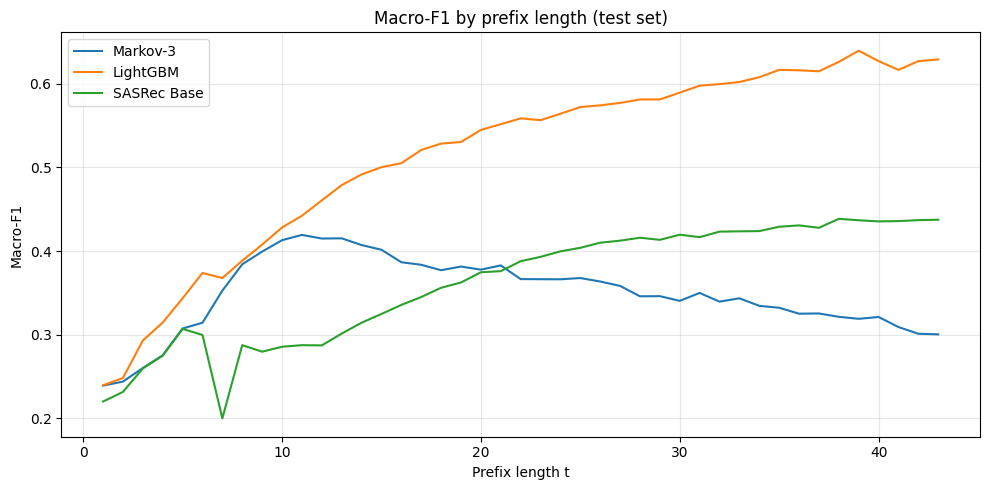

In [109]:
# -- 7.3 Macro-F1 by prefix length --

f1_by_t = {}
for name, df in all_preds.items():
    f1_by_t[name] = evaluate_by_t(df)

# -- verify n_prefixes identical across models (same test set, validated in 7.1) --
for name in all_preds:
    assert (f1_by_t[name]["n_prefixes"].values == f1_by_t["Markov-3"]["n_prefixes"].values).all(), \
        f"n_prefixes mismatch: Markov-3 vs {name}"

# -- combine into single DataFrame for saving --
f1_by_t_combined = f1_by_t["Markov-3"][["t", "n_prefixes"]].copy()
for name in all_preds:
    assert (f1_by_t[name]["t"].values == f1_by_t_combined["t"].values).all(), \
        f"t order mismatch: {name}"
    f1_by_t_combined[name] = f1_by_t[name]["macro_f1"].values

f1_by_t_combined.to_csv("/content/exp2_artifacts/f1_by_t_all_models.csv", index=False)
print(f"Saved f1_by_t_all_models.csv ({len(f1_by_t_combined)} rows)")

# -- plot --
fig, ax = plt.subplots(figsize=(10, 5))
for name in all_preds:
    ax.plot(f1_by_t_combined["t"], f1_by_t_combined[name], label=name, linewidth=1.5)

ax.set_xlabel("Prefix length t")
ax.set_ylabel("Macro-F1")
ax.set_title("Macro-F1 by prefix length (test set)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [110]:
# -- 7.3 DEBUG: SASRec dip at t=7 --

_sasrec_t7 = sasrec_preds[sasrec_preds["t"] == 7]
_sasrec_t6 = sasrec_preds[sasrec_preds["t"] == 6]
_sasrec_t8 = sasrec_preds[sasrec_preds["t"] == 8]

for t_val, subset in [(6, _sasrec_t6), (7, _sasrec_t7), (8, _sasrec_t8)]:
    f1, report = evaluate(subset["y_true"].values, y_pred=subset["y_pred"].values)
    per_class = {c: round(report.loc[c, "f1-score"], 3) for c in LABELS}
    print(f"t={t_val}: n={len(subset)}, Macro-F1={f1:.4f}")
    print(f"  y_true dist: {subset['y_true'].value_counts().to_dict()}")
    print(f"  per-class F1: {per_class}")
    print()

del _sasrec_t6, _sasrec_t7, _sasrec_t8

t=6: n=29118, Macro-F1=0.2997
  y_true dist: {'Browser': 23500, 'Researcher': 2967, 'Intent': 1964, 'Buyer': 687}
  per-class F1: {'Buyer': np.float64(0.154), 'Intent': np.float64(0.143), 'Researcher': np.float64(0.218), 'Browser': np.float64(0.684)}

t=7: n=19148, Macro-F1=0.2000
  y_true dist: {'Browser': 13546, 'Researcher': 2956, 'Intent': 1959, 'Buyer': 687}
  per-class F1: {'Buyer': np.float64(0.155), 'Intent': np.float64(0.211), 'Researcher': np.float64(0.263), 'Browser': np.float64(0.171)}

t=8: n=16751, Macro-F1=0.2875
  y_true dist: {'Browser': 11189, 'Researcher': 2928, 'Intent': 1947, 'Buyer': 687}
  per-class F1: {'Buyer': np.float64(0.154), 'Intent': np.float64(0.275), 'Researcher': np.float64(0.333), 'Browser': np.float64(0.387)}



In [ ]:
# -- 7.3 DEBUG: t=6,7,8 across all models --

for name, df in all_preds.items():
    print(f"=== {name} ===")
    for t_val in [6, 7, 8]:
        subset = df[df["t"] == t_val]
        f1, report = evaluate(subset["y_true"].values, y_pred=subset["y_pred"].values)
        browser_f1 = report.loc["Browser", "f1-score"]
        browser_pred = (subset["y_pred"] == "Browser").sum()
        print(f"  t={t_val}: Macro-F1={f1:.4f}, Browser F1={browser_f1:.3f}, Browser preds={browser_pred}/{len(subset)}")
    print()

**7.3 Result:**

LightGBM dominates at all evaluated prefix lengths, rising steadily from ~0.24 ($t=1$) to ~0.63 ($t=43$). SASRec Base starts comparably to Markov-3 at short prefixes but exhibits a localised dip at $t=7$, then recovers and surpasses Markov-3 around $t=21$, reaching ~0.44.

The $t=7$ dip is SASRec-specific: at this prefix length the model predicts Browser for only 7.5% of prefixes despite 70.7% true Browser support, collapsing Browser F1 from 0.68 ($t=6$) to 0.17 ($t=7$). Markov-3 and LightGBM maintain Browser prediction rates above 65% at the same $t$. This coincides with the cohort shift at $t=7$ (short Browser sessions drop out, leaving a harder subset), but only SASRec responds by abandoning Browser predictions. This is discussed further in Section 7.6.

Markov-3 peaks around $t=8$-$10$ (~0.42) and then declines steadily to ~0.30 at $t=43$, suggesting that additional context beyond a fixed trigram does not translate into better discrimination under this model.

The gap between LightGBM and the other two models widens with prefix length, indicating that engineered features scale more effectively with additional events than token-only sequential modeling.

### 7.4 Confusion Matrices

Side-by-side confusion matrices (recall-normalized) for all three models on the full test set. This reveals systematic vs model-specific misclassification patterns: which classes each model confuses, and whether error flows are shared across models or unique to a particular approach.

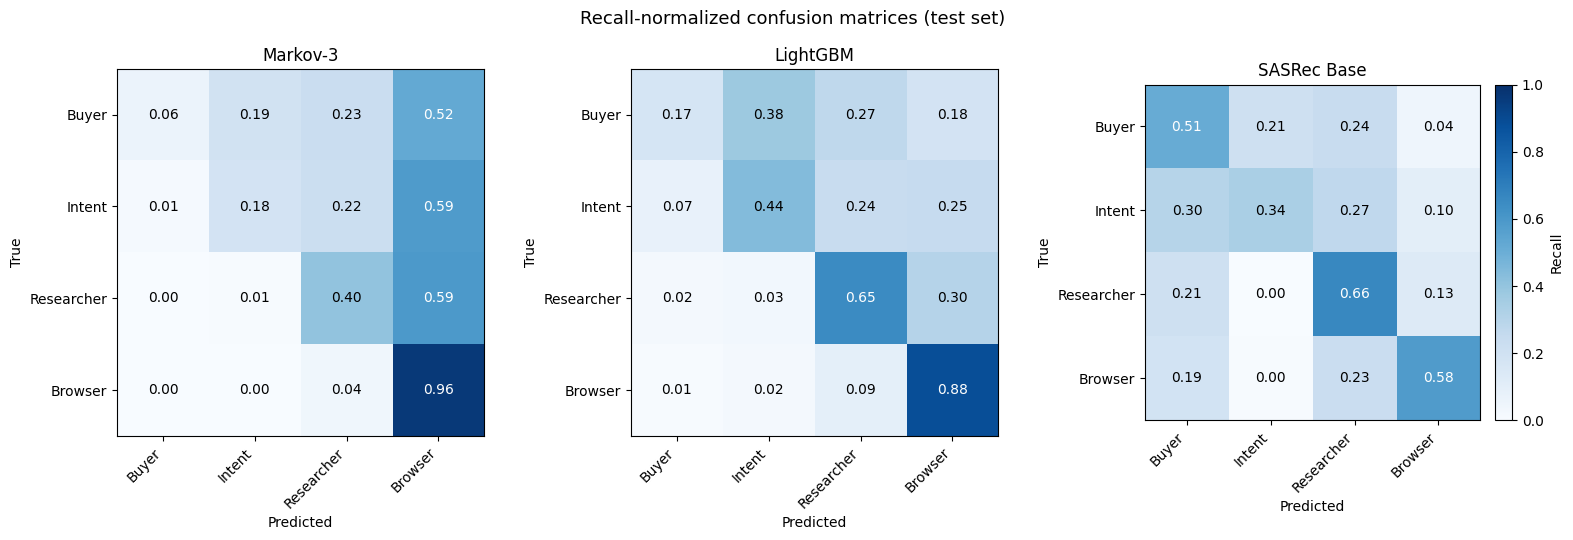

Saved confusion_matrices.npz


In [111]:
# -- 7.4 Confusion matrices (recall-normalized) --

from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm_data = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.4, top=0.88)

for ax, (name, df) in zip(axes, all_preds.items()):
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=LABELS)
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm.astype(float), row_sums, where=(row_sums != 0), out=np.zeros_like(cm, dtype=float))
    cm_data[name] = {"counts": cm, "normalized": cm_norm}

    im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(len(LABELS)))
    ax.set_yticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS, rotation=45, ha="right")
    ax.set_yticklabels(LABELS)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{name}")

    for i in range(len(LABELS)):
        for j in range(len(LABELS)):
            color = "white" if cm_norm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color=color, fontsize=10)

# -- colorbar on last axis only --
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(im, cax=cax, label="Recall")

fig.suptitle("Recall-normalized confusion matrices (test set)", fontsize=13)
plt.show()

# -- save confusion matrices --
np.savez("/content/exp2_artifacts/confusion_matrices.npz",
         **{f"{name}_counts": cm_data[name]["counts"] for name in cm_data},
         **{f"{name}_normalized": cm_data[name]["normalized"] for name in cm_data},
         labels=LABELS)
print("Saved confusion_matrices.npz")

**7.4 Result:**

Three distinct error profiles emerge:

**Markov-3** defaults to the majority class: 52-59% of true Buyer, Intent, and Researcher prefixes are predicted as Browser. Browser recall is 0.96, but Buyer (0.06) and Intent (0.18) recall are very low. Researcher recall is moderate (0.40) but still loses 59% to Browser.

**LightGBM** is the most balanced overall. It achieves strong Intent recall (0.44) and Researcher recall (0.65) alongside high Browser recall (0.88), without collapsing into a single class. The primary error flow is Buyer $\to$ Intent (0.38), reflecting genuine ambiguity between purchase and pre-purchase behavior. Researcher $\to$ Browser leakage (0.30) is the second-largest off-diagonal.

**SASRec Base** shows the opposite bias to Markov: it over-predicts Buyer (19-51% of every true class is predicted as Buyer), achieving the highest Buyer recall (0.51) but the lowest Browser recall (0.58). The largest off-diagonal is Intent $\to$ Buyer (0.30), followed by Researcher $\to$ Buyer (0.21) and Browser $\to$ Buyer (0.19).

**Shared vs model-specific patterns:** Buyer-Intent ambiguity is prominent in LightGBM and SASRec, while Markov tends to map both to Browser. Researcher $\to$ Browser misclassification is present in all three models, as Researcher sessions (no cart/checkout actions) are behaviorally similar to browsing.

### 7.5 Cross-Model Agreement Analysis

We examine how often the three models agree or disagree on individual prefix predictions. Agreement is measured at the prefix level on identical $(session\_id, t)$ keys: 3-way agreement (all three models predict the same class) and pairwise agreement for each model pair. Overall agreement is heavily influenced by Browser dominance, so the key analysis is the per-class breakdown by true label. Disagreement patterns reveal whether models produce overlapping errors (suggesting limited separability in observed prefixes) or complementary errors (which may indicate diversity useful for future ensemble exploration).

In [112]:
# -- 7.5 Cross-model agreement analysis --

_m = markov3_preds["y_pred"].values
_l = lgbm_preds["y_pred"].values
_s = sasrec_preds["y_pred"].values
_y_true = markov3_preds["y_true"].values

n = len(_m)

# -- 3-way agreement (unanimous) --
agree_3 = (_m == _l) & (_l == _s)
print(f"Unanimous (3-way agree): {agree_3.sum():,} / {n:,} ({agree_3.mean():.3f})")

# -- all-different (no two models agree) --
all_diff = (_m != _l) & (_m != _s) & (_l != _s)
print(f"All-different:           {all_diff.sum():,} / {n:,} ({all_diff.mean():.3f})")

# -- 2-of-3 agree (exactly two models agree, one differs) --
two_of_3 = (~agree_3) & (~all_diff)
print(f"2-of-3 agree:            {two_of_3.sum():,} / {n:,} ({two_of_3.mean():.3f})")

# -- pairwise agreement --
print("\nPairwise agreement:")
for name_a, name_b, a, b in [
    ("Markov-3", "LightGBM", _m, _l),
    ("Markov-3", "SASRec Base", _m, _s),
    ("LightGBM", "SASRec Base", _l, _s),
]:
    pct = (a == b).mean()
    print(f"  {name_a} vs {name_b}: {pct:.3f}")

# -- breakdown by true class --
print("\nBy true class:         Unanimous  2-of-3   All-diff")
for label in LABELS:
    mask = _y_true == label
    cnt = mask.sum()
    r3 = agree_3[mask].mean()
    r2 = two_of_3[mask].mean()
    rd = all_diff[mask].mean()
    print(f"  {label:12s} (n={cnt:>7,}): {r3:.3f}     {r2:.3f}    {rd:.3f}")

del _m, _l, _s

Unanimous (3-way agree): 259,348 / 497,852 (0.521)
All-different:           33,774 / 497,852 (0.068)
2-of-3 agree:            204,730 / 497,852 (0.411)

Pairwise agreement:
  Markov-3 vs LightGBM: 0.789
  Markov-3 vs SASRec Base: 0.540
  LightGBM vs SASRec Base: 0.645

By true class:         Unanimous  2-of-3   All-diff
  Buyer        (n= 28,550): 0.256     0.558    0.186
  Intent       (n= 62,761): 0.314     0.552    0.135
  Researcher   (n= 77,448): 0.456     0.457    0.086
  Browser      (n=329,093): 0.599     0.361    0.040


**7.5 Result:**

Models agree unanimously on 52.1% of prefixes, with 2-of-3 agreement on 41.1% and all-different predictions on only 6.8%. Unanimous agreement is Browser-driven (0.60 for Browser vs 0.26 for Buyer), consistent with Browser being the easiest class for all models.

**Pairwise agreement** reveals model similarity: Markov-3 and LightGBM agree most often (0.789), while Markov-3 and SASRec Base agree least (0.540). The high Markov-LightGBM agreement is consistent with their shared tendency to predict Browser for ambiguous prefixes, whereas SASRec's Buyer over-prediction (Section 7.4) makes it the most dissimilar model.

**Per-class disagreement:** Buyer has the highest all-different rate (0.186) and lowest unanimity (0.256), confirming it as the hardest class to classify consistently. Intent follows a similar pattern (all-different 0.135, unanimity 0.314). Researcher and Browser show progressively higher agreement, reflecting clearer behavioral signatures for these classes.

The 2-of-3 agreement rate exceeding 41% suggests that in most disagreements, two models converge while one diverges, indicating moderate complementarity at the prefix level rather than fully independent errors.

### 7.6 Error Pattern Analysis

Top misclassification flows for each model, sliced by prefix length (short: $t \leq 10$, long: $t > 10$). The boundary $t=10$ is chosen before the Markov-3 performance peak and before the long-prefix support shift becomes pronounced (Section 7.3). Flows are reported by count and by share normalized within each slice to account for different prefix volumes.

In [113]:
# -- 7.6 Error pattern analysis: top misclassification flows --

def top_misclass_flows(y_true, y_pred, top_n=5):
    """Return top misclassification flows by count."""
    mask = y_true != y_pred
    errors = pd.DataFrame({"y_true": y_true[mask], "y_pred": y_pred[mask]})
    flows = errors.groupby(["y_true", "y_pred"]).size().reset_index(name="count")
    flows = flows.sort_values("count", ascending=False).reset_index(drop=True)
    flows["share"] = flows["count"] / mask.sum()
    return flows.head(top_n)

slice_summary_rows = []
all_flows = []

for name, df in all_preds.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")

    for slice_name, slice_mask in [("short (t<=10)", df["t"] <= 10), ("long (t>10)", df["t"] > 10)]:
        _sub = df[slice_mask]
        n_total = len(_sub)
        n_errors = (_sub["y_true"] != _sub["y_pred"]).sum()
        error_rate = n_errors / n_total
        print(f"\n  {slice_name}: {n_total:,} prefixes, {n_errors:,} errors ({error_rate:.3f})")

        slice_summary_rows.append({
            "model": name, "slice": slice_name,
            "n_total": n_total, "n_errors": n_errors, "error_rate": error_rate,
        })

        flows = top_misclass_flows(_sub["y_true"].values, _sub["y_pred"].values)
        flows["model"] = name
        flows["slice"] = slice_name
        all_flows.append(flows)

        for _, row in flows.iterrows():
            print(f"    {row['y_true']:>12s} -> {row['y_pred']:<12s}  {row['count']:>7,}  ({row['share']:.3f})")

# -- save artifacts --
pd.DataFrame(slice_summary_rows).to_csv(
    "/content/exp2_artifacts/error_rate_by_slice.csv", index=False)
pd.concat(all_flows, ignore_index=True).to_csv(
    "/content/exp2_artifacts/top_misclass_flows.csv", index=False)
print("\nSaved error_rate_by_slice.csv and top_misclass_flows.csv")


Markov-3

  short (t<=10): 339,881 prefixes, 55,683 errors (0.164)
      Researcher -> Browser        22,501  (0.404)
          Intent -> Browser        15,493  (0.278)
         Browser -> Researcher      8,368  (0.150)
           Buyer -> Browser         5,541  (0.100)
          Intent -> Researcher      2,248  (0.040)

  long (t>10): 157,971 prefixes, 81,357 errors (0.515)
      Researcher -> Browser        23,314  (0.287)
          Intent -> Browser        21,268  (0.261)
          Intent -> Researcher     11,511  (0.141)
           Buyer -> Browser         9,403  (0.116)
           Buyer -> Researcher      5,672  (0.070)

LightGBM

  short (t<=10): 339,881 prefixes, 63,217 errors (0.186)
      Researcher -> Browser        18,611  (0.294)
         Browser -> Researcher     15,681  (0.248)
          Intent -> Browser        12,248  (0.194)
          Intent -> Researcher      4,033  (0.064)
           Buyer -> Browser         3,924  (0.062)

  long (t>10): 157,971 prefixes, 60,795 er

**7.6 Result:**

**Error rates by slice:**

| Model | Short ($t \leq 10$) | Long ($t > 10$) |
|---|---|---|
| Markov-3 | 0.164 | 0.515 |
| LightGBM | 0.186 | 0.385 |
| SASRec Base | 0.392 | 0.552 |

Markov-3 has the lowest short-prefix error rate (0.164), consistent with its tendency to default to Browser when Browser dominates support; its error rate more than triples on long prefixes as Browser support drops. LightGBM is the only model where long-prefix errors (0.385) are lower than SASRec short-prefix errors (0.392).

**Top misclassification flows:**

*Markov-3:* Dominated by X $\to$ Browser flows in both slices. Researcher $\to$ Browser is the single largest flow (0.404 short, 0.287 long), followed by Intent $\to$ Browser. Compared to the Browser collapse, within-minority confusions are secondary.

*LightGBM:* More varied error structure. On short prefixes, Researcher $\to$ Browser leads (0.294), but on long prefixes the pattern shifts: Browser $\to$ Researcher (0.240) and Intent $\to$ Researcher (0.182) become dominant, with Buyer $\to$ Intent (0.163) emerging as a major flow. This shift is consistent with LightGBM gaining discriminative power at longer prefixes but struggling with Buyer-Intent separation.

*SASRec Base:* Short-prefix errors are dominated by Browser $\to$ Buyer (0.388) and Browser $\to$ Researcher (0.317) — together accounting for 70% of short-prefix errors. This confirms the Buyer over-prediction pattern from Section 7.4. On long prefixes, Browser $\to$ Researcher (0.380) becomes the largest flow, with Intent $\to$ Buyer (0.142) as the second.

**Shared pattern:** Researcher $\to$ Browser confusion appears in all models on short prefixes, reflecting the behavioral overlap between product-viewing sessions. On long prefixes, error diversity increases for LightGBM and SASRec, while Markov remains dominated by X $\to$ Browser flows.

### 7.7 Diagnostic Conclusions

Structured synthesis of findings from Sections 7.2-7.6: what each model performs well vs poorly on, and the likely reasons based on observed error patterns. All conclusions are grounded in the experimental evidence presented above; no external claims are made.

**7.7 Result:**

| Model | Strengths | Weaknesses | Likely reason |
|---|---|---|---|
| Markov-3 | Lowest short-prefix error rate (0.164); highest Browser recall (0.96) | Degrades after $t=10$; near-zero Buyer recall (0.06) | Fixed trigram window cannot exploit growing sequences; defaults to majority class |
| LightGBM | Best Macro-F1 (0.5431); most balanced confusion profile; scales with prefix length to ~0.63 | Buyer recall remains low (0.17); Buyer $\to$ Intent is largest error flow on long prefixes | Engineered features capture cumulative signals but cannot resolve Buyer-Intent ambiguity when purchase events are absent |
| SASRec Base | Highest Buyer recall (0.51); surpasses Markov-3 on long prefixes ($t > 21$) | Lowest Browser recall (0.58); Buyer over-prediction drives 70% of short-prefix errors; sensitive to cohort shift at $t=7$ | Tends to over-allocate probability mass to Buyer without explicit count/flag anchors for Browser and Researcher classification |

**Cross-cutting diagnostics:**

1. *Buyer-Intent ambiguity is the primary bottleneck for LightGBM and SASRec.* The shared event vocabulary between purchase and pre-purchase sessions limits separability. Markov-3 sidesteps this by collapsing most ambiguous prefixes into Browser.

2. *Label-support shift strongly influences prefix-length dynamics, especially at early $t$.* Short prefixes are Browser-dominated (~89%), making early classification trivial for Browser but near-impossible for minority classes.

3. *Model diversity is moderate.* Unanimous agreement at 52% and all-different at only 6.8% indicate partially overlapping errors. Ensemble gains are possible but bounded by the shared difficulty of separating Buyer from Intent.

### Section 7 Summary

Section 7 compared three model families on identical test data (54,020 sessions, 497,852 prefixes, $t=1 \ldots 43$).

**Aggregate performance (Macro-F1):** LightGBM 0.5431, SASRec Base 0.4570, Markov-3 0.4221. LightGBM's 28.7% relative improvement over Markov-3 is driven by gains in Buyer (+0.125) and Intent (+0.220) F1.

**Prefix-length dynamics:** LightGBM dominates at all evaluated $t$, reaching ~0.63 at $t=43$. Markov-3 peaks at $t=8$-$10$ and degrades beyond. SASRec Base surpasses Markov-3 around $t=21$ but exhibits a localised $t=7$ dip caused by Browser F1 collapse under cohort shift.

**Error profiles:** Each model has a distinct bias. Markov-3 collapses minority classes into Browser (recall 0.96 Browser, 0.06 Buyer). LightGBM is the most balanced but struggles with Buyer $\to$ Intent (0.38). SASRec over-predicts Buyer (51% of true Buyer recalled, but 19% of true Browser predicted as Buyer and 23% as Researcher), spreading errors across multiple classes.

**Agreement:** Models agree unanimously on 52.1% of prefixes. Buyer is the hardest class (unanimity 0.256, all-different 0.186). Markov-3 and LightGBM are most similar (pairwise 0.789); SASRec is the most dissimilar.

**Primary bottleneck:** Buyer-Intent separation, most pronounced for LightGBM and SASRec, driven by overlapping event vocabularies in purchase and pre-purchase sessions. Markov largely maps this ambiguity to Browser. Label-support shift across prefix lengths strongly influences early-$t$ performance for all models.

## Section 8: Experiment 2 Discussion

Sections 4-6 evaluated three model families independently; Section 7 brought
their results into a unified comparison across aggregate metrics, prefix-length
diagnostics, confusion patterns, and error flows. This section interprets those
results at the experiment level.

The discussion proceeds from observations to explanations: we first recap the
key findings (8.1), then examine why each model behaves the way it does on
this specific task and dataset (8.2-8.4), analyse the role of label
distribution shift by prefix length $t$ as a cross-cutting factor (8.5), and
close with a structured summary of what is systematic across all models versus
what is model-specific (8.6). All claims in this section are grounded in
results reported in Sections 4-7; no external benchmarks or theoretical
arguments are introduced.

### 8.1 Key Findings Recap

Experiment 2 evaluated three model families on the same test set (54,020
sessions, 497,852 prefixes) using the protocol defined in Section 3. The
aggregate results are:

| Model | Test Macro-F1 | Buyer F1 | Intent F1 | Researcher F1 | Browser F1 |
|---|---|---|---|---|---|
| LightGBM | 0.5431 | 0.2356 | 0.5042 | 0.5560 | 0.8765 |
| SASRec Base | 0.4570 | 0.2087 | 0.4597 | 0.4497 | 0.7100 |
| Markov-3 | 0.4221 | 0.1106 | 0.2843 | 0.4417 | 0.8518 |

LightGBM leads across all classes. SASRec Base falls between LightGBM and
Markov-3 at the aggregate level, outperforming Markov-3 on Buyer, Intent, and
Researcher while trailing on Browser. Markov-3 achieves high Browser F1 but
the weakest minority-class performance overall. Across all three models, Buyer
remains the hardest class (F1 range 0.11-0.24), and Browser the easiest
(F1 range 0.71-0.88). Detailed interpretation follows in 8.2-8.6.

### 8.2 Why LightGBM Wins

LightGBM achieves the highest Macro-F1 at every prefix length $t$ (Section
7.3), with a smooth monotonic improvement from ~0.24 at $t=1$ to ~0.63 at
$t=43$ and no local dips. The gap over other models widens with $t$, which is
consistent with how the model processes information: engineered prefix features
aggregate cumulative event counts, frequencies, n-gram suffixes, and temporal
statistics up to position $t$. As $t$ grows, these aggregates become
increasingly informative, and the model benefits directly.

The error rate analysis (Section 7.6) confirms this: LightGBM has the lowest
error rate on the long-prefix slice ($t > 10$, error rate 0.385) and the most
balanced confusion matrix across all three models (Section 7.4). On the
short-prefix slice ($t \leq 10$), its error rate (0.186) is slightly higher
than Markov-3 (0.164), which reflects Markov-3's tendency to default to
Browser in the early regime (consistent with Section 7.4 and 7.6) rather than
a structural weakness of LightGBM.

LightGBM does not model event order explicitly and relies on engineered
aggregates. The results show that for this task and dataset, cumulative feature
aggregation over the prefix was sufficient in this experiment to outperform
both the sequence-aware Markov model and the transformer-based SASRec.

### 8.3 Why Markov-3 Degrades for Long Prefixes

Markov-3 peaks at $t=8$-$10$ (Section 7.3), then degrades steadily, with
error rate rising from 0.164 on the short-prefix slice ($t \leq 10$) to 0.515
on the long-prefix slice ($t > 10$) - the largest such increase across all
three models (Section 7.6). The top misclassification flows on the long slice
are dominated by X->Browser patterns, with the model increasingly defaulting
to the majority class as prefix length grows.

This is consistent with the coverage analysis in Section 4.6: as $t$ increases,
the state (last 3 tokens) becomes more diverse, unseen states become more
frequent, and the backoff strategy falls back toward the class prior. Since
the prior is Browser-dominated (~89% overall, similar in train), longer
prefixes increasingly receive Browser predictions regardless of the actual
event sequence.

On short prefixes, the state space is more constrained and coverage remains
high, which explains the competitive early performance. The degradation pattern
is therefore not a failure of the backoff strategy per se, but a structural
consequence of the n-gram state representation: it poorly generalizes across
unseen token combinations.

### 8.4 Why SASRec Shifts Mass Away from Browser

SASRec Base shows a localised Browser F1 drop at $t=7$ (from ~0.68 at $t=6$
to ~0.17 at $t=7$), confirmed by the debug analysis in Section 7.3: at $t=7$,
only 7.5% of SASRec predictions are Browser despite 70.7% true Browser labels.
This is the sharpest single-step shift observed across all three models.

Two factors contribute. First, a cohort shift at $t=7$: only sessions of
length $\geq 7$ contribute prefixes at that position, forming a harder subset
where Browser sessions are less distinguishable by token sequence alone.
Second, class weighting in the training loss (Section 6.6): Browser receives
the lowest weight (0.2838) while Buyer receives the highest (16.6462), which
encourages minority-class predictions under imbalance. The combination of a
harder Browser cohort and high minority-class incentive produces the observed
mass shift. The confusion matrix (Section 7.4) confirms both directions:
Browser->Buyer and Browser->Researcher are among the largest error flows for
SASRec.

On longer prefixes, as more discriminative tokens accumulate, the model
partially recovers Browser recall. Macro-F1($t$) recovers after the dip and
approaches ~0.44 by $t=43$, consistent with the aggregate Macro-F1 = 0.4570
being an average over all prefix lengths. The net effect is that SASRec trades
Browser recall for increased Buyer and Researcher sensitivity, at the cost of
Buyer precision, which under Macro-F1 does not pay off relative to LightGBM's
more balanced profile.

### 8.5 Role of Label Distribution Shift by Prefix Length $t$

Across all three models, the composition of prefixes by class changes
substantially with $t$. At $t \leq 5$, Browser sessions account for ~88.6%
of prefixes; by $t \geq 31$, this drops to ~9.0%, while Buyer, Intent, and
Researcher prefixes become proportionally dominant (Section 6.8). This shift
is a direct consequence of the correlation between session length and session
class: minority-class sessions tend to be longer.

This has two consequences for interpreting the results. First, at early $t$,
Macro-F1 is constrained by limited information for separating minority classes.
Even if Browser recall is high, Macro-F1 remains low because it averages
performance across all four classes equally. A model that defaults to Browser
on short prefixes (as Markov-3 does) therefore does not gain a Macro-F1
advantage from this alone. Second, Macro-F1($t$) reflects both increasing
information within prefixes and the changing cohort composition induced by the
$\text{length} \geq t$ filtering: as $t$ grows, the surviving cohort is
increasingly composed of longer, more information-rich sessions from
minority classes.

What the label distribution shift does not explain: the SASRec dip at $t=7$
is a local anomaly that runs counter to the general trend (Section 8.4), and
LightGBM's smooth monotonic improvement across $t$ without local dips persists
even as the class composition changes. These patterns are better explained by
model-specific factors discussed in 8.2-8.4 than by the distribution shift
alone.

### 8.6 What Is Systematic vs Model-Specific

The results across Sections 7.2-7.6 reveal a set of error patterns that are
shared by all three models, and a set that are specific to individual
approaches.

**Systematic across all models:**

- Buyer is the hardest class (F1 range 0.11-0.24). Low Buyer F1 is universal,
  though the underlying trade-off differs: Markov-3 and LightGBM show low
  Buyer recall (0.06 and 0.17 respectively), while SASRec achieves higher
  recall (0.51) at the cost of low precision due to over-prediction.
- Buyer-Intent ambiguity is prominent: Buyer->Intent is a major long-prefix
  misclassification flow for LightGBM, while Intent->Buyer is a major
  long-prefix flow for SASRec (Section 7.6).
- Early-$t$ performance is limited across all models, driven by the
  near-absence of discriminative signals before key events occur (Section 8.5).

**Model-specific:**

- Markov-3: degradation on long prefixes due to state-space sparsity and
  backoff to Browser-dominated prior (Section 8.3).
- SASRec Base: mass shift away from Browser at $t=7$, driven by the
  combination of cohort shift and class-weight incentives (Section 8.4).
- LightGBM: smooth improvement across $t$ without local dips, consistent with
  cumulative feature aggregation (Section 8.2). No structural pathology
  observed in the error flows.

The distinction between systematic and model-specific patterns is relevant for
future modeling choices: systematic limitations suggest a fundamental
information constraint at early $t$, while model-specific pathologies indicate
addressable design decisions.

### Section 8 Summary

Section 8 interpreted the Experiment 2 results at the experiment level, moving
from observations in Sections 4-7 to explanations.

LightGBM achieved the highest Macro-F1 (0.5431) across all prefix lengths,
with smooth monotonic improvement consistent with cumulative feature
aggregation. Markov-3 peaked at $t=8$-$10$ then degraded due to state-space
sparsity and backoff to the Browser-dominated prior. SASRec Base showed a
localised Browser F1 collapse at $t=7$, consistent with the combination of
cohort shift and class-weight incentives, recovering partially on longer
prefixes.

Label distribution shift by $t$ is a cross-cutting factor: the $\text{length}
\geq t$ cohort filtering changes class composition and apparent difficulty
across prefix lengths, and contributes, alongside increased information within
longer prefixes, to the rising Macro-F1($t$) curves observed in all models.

Two types of limitations were identified. Systematic: low Buyer F1 across all
models, Buyer-Intent ambiguity, and limited early-$t$ performance due to
absent discriminative signals. Model-specific: Markov-3 sparsity on long
prefixes, SASRec class-weight-driven mass shift, and LightGBM's reliance on
engineered aggregates without explicit order modelling. These distinctions are
relevant for future modeling choices.

## Section 9: Limitations and Threats to Validity

This section documents the principal limitations of Experiment 2 and the
assumptions that constrain the interpretation of its results. The goal is not
to undermine the findings reported in Sections 4-8, but to bound the claims
that can legitimately be made from this experiment and to make the methodology
transparent for replication and extension.

Limitations are grouped into five categories: labeling assumptions (9.1),
prefix evaluation caveats (9.2), data and split dependence (9.3), model
comparison caveats (9.4), and metric caveats under class imbalance (9.5).

### 9.1 Labeling Assumptions

Session labels are assigned by a deterministic rule-based hierarchy: Buyer >
Intent > Researcher > Browser, based on the presence of specific events in the
full session (Section 1.3). This approach is transparent and reproducible, but
introduces several assumptions that affect label quality.

First, the hierarchy treats any session containing a purchase event as Buyer,
regardless of session structure. A session with a single accidental purchase
followed by many browsing events receives the same label as a session with a
clear purchase intent trajectory. The label reflects the outcome, not the
behavioral pattern.

Second, the boundary between Intent and Researcher is defined by the presence
of cart or checkout events. This is a proxy: a user who extensively researches
products but never adds to cart is labeled Researcher, while a user who adds
to cart and immediately removes it is labeled Intent. The resulting classes
are outcome-based approximations of behavioral intent, not ground-truth
behavioral annotations.

Third, Browser is a residual class: any session not matching Buyer, Intent, or
Researcher criteria is labeled Browser. This means Browser is heterogeneous by
construction and may include sessions with weak research or intent signals that
did not cross the event thresholds.

These labeling choices serve as a pragmatic proxy for behavioral intent and are
consistent with those used in Experiment 1. However, label noise and boundary
ambiguity are present and likely contribute to the Buyer-Intent ambiguity
manifested either as Buyer->Intent confusion (LightGBM, SASRec) or collapse
to Browser (Markov-3), as observed in Section 8.6.

### 9.2 Prefix Evaluation Caveats

All models are evaluated on prefixes of length $t = 1 \ldots T_{\text{max}}$,
where $T_{\text{max}} = 43$ (p95 of train session lengths, Section 1.5). This
design introduces three caveats.

First, each prefix is treated as an independent evaluation instance. This means
a single session of length $T$ contributes $T$ rows to the test evaluation,
with longer sessions contributing more prefixes to the prefix-level aggregate.
Macro-F1 reported in Section 7.2 is computed over all 497,852 prefixes, not
over 54,020 sessions.

Second, the $t$-slice evaluation has a cohort effect: the set of sessions
contributing a prefix at position $t$ is restricted to sessions with length
$\geq t$. As discussed in Section 8.5, this means the class composition and
difficulty of the evaluated cohort changes with $t$, and Macro-F1($t$) curves
reflect both model improvement and cohort shift simultaneously, and can include
model-specific effects not explained by the shift alone.

Third, the choice of $t = 10$ as the boundary between short and long prefix
slices in Sections 7.6 and 8 is arbitrary. It was selected to broadly separate
early-session from mid-to-late-session behavior, but results at this boundary
are sensitive to the exact threshold. No sensitivity analysis over alternative
thresholds was performed.

### 9.3 Data and Split Dependence

All models in Experiment 2 are trained and evaluated on a single dataset:
the BigQuery public GA4 e-commerce sample. This is an obfuscated dataset from
a single e-commerce property over a fixed time period. The generalizability of
the results to other properties, product categories, or time periods is unknown.

The temporal split (70/15/15 by `session_end_ts`) ensures that no future
sessions leak into training, which is the appropriate choice for a
time-ordered dataset. However, the split boundaries are fixed at the p70 and
p85 quantiles of the session end timestamp distribution. Different boundary
choices would produce different train/val/test compositions and could affect
model selection and reported test metrics.

User-level overlap across splits is possible: a user whose sessions span the
split boundary will have some sessions in train and others in val or test.
This is a deliberate choice consistent with the session-level framing of the
task (each session is classified independently), but means that the same user
appears in multiple splits, and their behavioral patterns are represented
across train and test without any user-level isolation.

### 9.4 Model Comparison Caveats

The three models compared in Section 7 differ in their reproducibility
guarantees, which affects the strength of conclusions drawn from pairwise
comparisons.

Markov-3 is fully deterministic: given the same training data and vocabulary,
the transition counts and backoff predictions are identical across runs. No
stochasticity is involved.

LightGBM is deterministic under the fixed configuration used here: Optuna
tuning was run with `TPESampler(seed=42)` and `n_jobs=1` (Section 5.4), and
the final model was trained with a fixed seed. A single training run was
performed; no multi-run variance estimate is available for LightGBM.

SASRec was trained 5 times per variant with different seeds, and the median
run by val Macro-F1 was selected for test evaluation (Section 6.6). This
provides a limited estimate of training variance (reported in Section 6.7),
but the selected checkpoint is still a single run. The reported test Macro-F1
for SASRec Base (0.4570) reflects one checkpoint, not an average.

As a result, the three models are compared under different reproducibility
conditions: one deterministic model (Markov-3), one single-run model
(LightGBM), and one median-selected model from 5 runs (SASRec). This
asymmetry should be taken into account when interpreting small differences
in reported Macro-F1 values.

### 9.5 Metric Caveats Under Class Imbalance

The primary metric used throughout Experiment 2 is Macro-F1: the unweighted
average of per-class F1 scores across all four classes. This is an appropriate
choice under severe class imbalance, as it gives equal weight to each class
regardless of support. However, it has limitations that affect interpretation.

First, Macro-F1 treats all four classes as equally important. In practice,
downstream objectives may prioritize Buyer and Intent, while Browser
represents the majority of sessions. A model that improves Buyer F1 by 0.05
at the cost of Browser F1 by 0.05 receives the same Macro-F1, but the
practical implications differ substantially.

Second, per-class F1 aggregates precision and recall into a single number.
As observed in Section 8.6, SASRec achieves higher Buyer recall (0.51, from
the recall-normalized confusion matrix in Section 7.4) than LightGBM (0.17),
but lower Buyer precision. Macro-F1 does not distinguish between these
profiles, and the choice between high-recall and high-precision operating
points depends on the downstream application.

Third, Macro-F1 computed over all prefixes (prefix-level) differs from
Macro-F1 computed over final-prefix predictions only (session-level). The
prefix-level metric reported here reflects average performance across all
$t$, and is dominated by the many short prefixes where all models perform
poorly. A session-level metric would weight each session equally regardless
of length, and may yield different rankings.

### Section 9 Summary

Section 9 documented the principal limitations of Experiment 2 across five
categories.

Labeling is rule-based and outcome-driven, producing class boundaries that are
pragmatic proxies for behavioral intent rather than ground-truth annotations.
Label noise at the Buyer-Intent and Intent-Researcher boundaries is present by
construction.

Prefix-level evaluation introduces a cohort effect by $t$: the evaluated
session subset changes with prefix length, and aggregate Macro-F1($t$) curves
reflect both model behavior and cohort composition simultaneously. The
short/long slice boundary at $t=10$ is arbitrary and untested for sensitivity.

Results are derived from a single e-commerce property over a fixed time period.
Temporal split boundaries are fixed quantiles, and user-level isolation across
splits was not enforced.

The three models carry different reproducibility guarantees: Markov-3 is fully
deterministic, LightGBM is a single fixed-seed run, and SASRec is a
median-selected checkpoint from 5 runs. Direct comparison of small Macro-F1
differences should account for this asymmetry.

Macro-F1 weights all four classes equally and aggregates precision and recall
into a single score, which obscures class-specific trade-offs. Prefix-level
and session-level Macro-F1 are not equivalent and may yield different model
rankings.

## Section 10: Reproducibility and Artifacts

This section serves as a technical reference for Experiment 2. It documents
the artifact inventory, naming conventions, minimal rerun instructions, and
versioning decisions. The goal is to make the experiment self-contained for
anyone inspecting the notebook or repository without reading the full
experimental narrative.

### 10.1 Artifact Inventory

All artifacts are stored in `/content/exp2_artifacts/` (local) and
`gs://exp2data/` (GCS, with timestamp suffix). The table below lists the
final artifacts used for reporting.

**Data artifacts:**

| File | Description | Produced in |
|---|---|---|
| `sessions.parquet` | Session-level dataset with labels, splits, token sequences, dt, context | S1 |
| `prefix_train.parquet` | Prefix-level feature matrix for LightGBM (engineered features), train | S5 |
| `prefix_val.parquet` | Prefix-level feature matrix for LightGBM (engineered features), val | S5 |
| `prefix_test.parquet` | Prefix-level feature matrix for LightGBM (engineered features), test | S5 |
| `split_boundaries.json` | p70/p85 timestamp cutoffs | S1 |

**Preprocessing artifacts:**

| File | Description | Produced in |
|---|---|---|
| `vocab.json` | Event vocabulary | S1 |
| `class_weights.json` | Balanced class weights from train | S3 |
| `fe_artifacts.json` | Feature engineering constants (MAX_DT, n-gram vocab, top-K context) | S5 |
| `label_encoders.pkl` | Categorical encoders for context fields | S5 |
| `ctx_artifacts.json` | Context encoding artifacts for SASRec | S6 |

**Model artifacts:**

| File | Description | Produced in |
|---|---|---|
| `markov_best_alphas.json` | Best smoothing alphas for Markov-2/3 | S4 |
| `lgbm_best_params.json` | Best Optuna hyperparameters | S5 |
| `lgbm_final.pkl` | Trained LightGBM model | S5 |
| `sasrec_base.pt` | SASRec Base checkpoint (median run) | S6 |
| `sasrec_plustime.pt` | SASRec +Time checkpoint | S6 |
| `sasrec_pluscontext.pt` | SASRec +Context checkpoint | S6 |
| `sasrec_plustimepluscontext.pt` | SASRec +Time+Context checkpoint | S6 |
| `sasrec_ablation_summary.json` | Val/test metrics for all ablation variants | S6 |

**Prediction artifacts:**

| File | Description | Produced in |
|---|---|---|
| `markov3_test_predictions.parquet` | Markov-3 test predictions | S4 |
| `lgbm_test_predictions.parquet` | LightGBM test predictions | S5 |
| `sasrec_base_test_predictions.parquet` | SASRec Base test predictions | S6 |

### 10.2 Naming and Source of Truth

Local artifacts in `/content/exp2_artifacts/` use fixed names without
timestamps and are overwritten on each run. These are the files loaded by
downstream sections and should be treated as the current source of truth.

GCS artifacts in `gs://exp2data/` use timestamped names
(`{name}_{ddmmyy_HHMM}.ext`) and are never overwritten. They serve as
versioned backups and allow recovery of intermediate states if a local
artifact is lost or corrupted.

For final reported numbers, the authoritative files are:

| Metric | Source file |
|---|---|
| LightGBM test Macro-F1 | `lgbm_test_predictions.parquet` + `evaluate()` |
| Markov-3 test Macro-F1 | `markov3_test_predictions.parquet` + `evaluate()` |
| SASRec Base test Macro-F1 | `sasrec_base_test_predictions.parquet` + `evaluate()` |
| LightGBM hyperparameters | `lgbm_best_params.json` |
| SASRec ablation results | `sasrec_ablation_summary.json` |

Any discrepancy between text in the notebook and the output of `evaluate()`
applied to the prediction parquets should be resolved in favor of the
parquet-based computation.

### 10.3 Minimal Rerun Recipe

A full end-to-end rerun executes all cells sequentially after removing the
two stopper cells (cells containing `raise RuntimeError("STOP")` before the
Optuna search in S5 and before the SASRec training loop in S6). GPU is
required for S6; other sections run on CPU. Full rerun takes approximately
6-8 hours.

If local artifacts from a previous run are available, the following sections
can be skipped by loading artifacts directly:

| Section | Skip condition |
|---|---|
| S1 Data Pipeline | `sessions.parquet` and `split_boundaries.json` exist |
| S4 Markov | `markov_best_alphas.json` and `markov3_test_predictions.parquet` exist |
| S5 Feature Engineering | `prefix_train/val/test.parquet` and `fe_artifacts.json` exist |
| S5 Hyperparameter Tuning | `lgbm_best_params.json` exists |
| S5 Model Training | `lgbm_final.pkl` and `lgbm_test_predictions.parquet` exist |
| S6 Training Loop | `sasrec_*.pt`, `sasrec_ablation_summary.json`, and `sasrec_base_test_predictions.parquet` exist |

If model artifacts exist but prediction parquets do not, S7 will require
inference to be re-run: LightGBM predictions can be regenerated from
`lgbm_final.pkl`, and SASRec Base predictions from `sasrec_base.pt`.

Each section that supports artifact loading contains a clearly marked
`# -- TEMPORARY: manually restore ... --` cell that can be activated in place
of the full computation. Sections S2, S3, S7, S8, S9 have no long-running
steps and always execute from scratch.

### 10.4 Versioning

The following constants and parameters are fixed for Experiment 2 and must
not be changed between runs to ensure reproducibility:

| Parameter | Value | Set in |
|---|---|---|
| `T_MAX` | 43 | S1 (p95 train session length) |
| `SEED` | 42 | S6 (base seed for SASRec multi-run) |
| `TPESampler(seed=42)` | 42 | S5 (Optuna) |
| Optuna `n_jobs` | 1 | S5 (sequential trials) |
| LightGBM `n_jobs` | 1 | S5 (deterministic training) |
| `BATCH_SIZE` | 512 | S6 |
| `HIDDEN_DIM` | 64 | S6 |
| Context encoding order | fixed in `ctx_artifacts.json` | S6 |
| Context field encoders | fixed in `label_encoders.pkl` | S5 |
| Vocab token-to-index mapping | fixed in `vocab.json` | S1 |

**Class label mapping** (fixed, not stored as a separate artifact):

| Class | Index |
|---|---|
| Buyer | 0 |
| Intent | 1 |
| Researcher | 2 |
| Browser | 3 |

SASRec was trained with `N_RUNS=5`, using seeds `[42, 43, 44, 45, 46]`
(`run_seed = SEED + run`). The reported checkpoint is the median-selected run
by val Macro-F1. Results may vary across hardware and CUDA versions despite
fixed seeds.

LightGBM is fully deterministic under fixed `TPESampler(seed=42)`,
`n_jobs=1` in both Optuna and LightGBM training. A single training run is
sufficient for reproduction.

Markov-3 is fully deterministic and requires no seed.

### Section 10 Summary

Section 10 provides a technical reference for Experiment 2.

The artifact inventory (10.1) lists 21 files across four categories: data,
preprocessing, model, and prediction artifacts. Local files in
`/content/exp2_artifacts/` are the source of truth for reported numbers;
GCS timestamped backups serve as versioned recovery points. In case of any
discrepancy between notebook text and computed metrics, the prediction
parquets combined with `evaluate()` take precedence (10.2).

A full rerun requires removing two stopper cells and a GPU instance for S6,
taking approximately 6-8 hours. Individual sections can be skipped if their
artifacts exist locally; Section 7 additionally requires prediction parquets
to run without recomputation (10.3).

Key versioning parameters include `T_MAX=43`, `SEED=42` (base seed for
SASRec 5-run protocol with seeds `[42..46]`), and fixed `n_jobs=1` for both
Optuna and LightGBM training. The class label mapping
(Buyer=0, Intent=1, Researcher=2, Browser=3) is fixed by the `LABELS`
constant in Section 3.2 (10.4).

---
*Last updated: {date}*
